# Engenius '20 - Sales Prediction

## Overview

The Main goal is to predict the quantities sold of a set of products within a 4 months time frame.

# Table of Contents

- Exploratory Data Analysis
    -  Missing & Erroneous Value Treatment
    -  Distribution of Products Sold
    - Product Insights
- Product And Sector Investigation
- Missing & Erroneous Value Treatment
- Acquisition of Socio-Economical And Demographical Data
    - Gross Domestic Product By City
    - Life Expectancy By City
    - Population By City
    - Population Growth Rate And Population Density By City
    - Retail Purchases Monthly Change With WAT Without Seasonal Influences
- Feature Creation
- Resources

# Exploratory Data Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import math
import seaborn as sns

#https://github.com/nalepae/pandarallel
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=6)


product_sheets = ['PRODUCT_A', 'PRODUCT_B', 'PRODUCT_C', 'PRODUCT_V', 'PRODUCT_X']
products = product_sheets
data = {}

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:

for s in product_sheets:
    data[s] = pd.read_excel('datasets/Data2017-2019.xls', s)
    

In [3]:
# merge data frames for all 5 products vertically
df_all5 = data[product_sheets[0]]
for i,s in enumerate(product_sheets):
    if i != 0:
        df_all5 = df_all5.append(data[s], ignore_index=True)


In [4]:
df_all5.shape

(58032, 5)

In [5]:
df_all5.Product.value_counts()

PRODUCT_C    17980
PRODUCT_B    17962
PRODUCT_A    17371
PRODUCT_X     2920
PRODUCT_V     1799
Name: Product, dtype: int64

### Missing & Erroneous Value Treatment
- ratio of null values
  No null values as seen below

In [6]:
(df_all5.isnull().sum() / df_all5.shape[0])

Year        0.0
Period      0.0
Product     0.0
Province    0.0
Quantity    0.0
dtype: float64

In [7]:
def internationalize_the_text(text):
    result = text.upper().replace('Ü','U').replace('Ğ','G').replace('İ','I').replace('Ş','S').replace('Ç','C').replace('Ö','O').replace('AFYONKARAHISAR', 'AFYON').replace('MERSIN', 'ICEL')
    return result

#### ratio of transactions (sales) with negative quantities
 - probably product return

In [8]:
(df_all5[df_all5.Quantity < 0].shape[0] / df_all5.shape[0])

0.0016197959746346844

In [9]:
data_sorted = df_all5.sort_values(by=['Period', 'Province', 'Product']).reset_index(drop=True)
data_sorted.head(5)

,Year,Period,Product,Province,Quantity
0,2017,201701,PRODUCT_A,ADANA,11
1,2017,201701,PRODUCT_A,ADANA,25
2,2017,201701,PRODUCT_A,ADANA,54
3,2017,201701,PRODUCT_A,ADANA,17
4,2017,201701,PRODUCT_A,ADANA,30


In [10]:
print('there is a typo in province names')
len(data_sorted.Province.unique())

there is a typo in province names


82

In [11]:
data_sorted = df_all5.sort_values(by=['Period', 'Province', 'Product']).reset_index(drop=True)
data_sorted.head(5)

,Year,Period,Product,Province,Quantity
0,2017,201701,PRODUCT_A,ADANA,11
1,2017,201701,PRODUCT_A,ADANA,25
2,2017,201701,PRODUCT_A,ADANA,54
3,2017,201701,PRODUCT_A,ADANA,17
4,2017,201701,PRODUCT_A,ADANA,30


In [12]:
# fixes ıstanbul typo
data_sorted['Province'] = data_sorted.Province.apply(lambda x: 'ISTANBUL' if x == 'İSTANBUL' else x)
data_sorted['Province'] = data_sorted.Province.apply(lambda x: 'CANAKKALE' if x == 'ÇANAKKKALE' else x)

In [13]:
#aggragate products sold
data_aggregated = data_sorted.groupby(['Period', 'Province', 'Product'])['Quantity'].sum().reset_index()
data_aggregated.head(8)

,Period,Province,Product,Quantity
0,201701,ADANA,PRODUCT_A,346
1,201701,ADANA,PRODUCT_B,4838
2,201701,ADANA,PRODUCT_C,1004
3,201701,ADANA,PRODUCT_V,20
4,201701,ADANA,PRODUCT_X,910
5,201701,ADIYAMAN,PRODUCT_A,36
6,201701,ADIYAMAN,PRODUCT_B,45
7,201701,ADIYAMAN,PRODUCT_C,206


In [14]:
data_aggregated.shape

(13343, 4)

### Filling mising sample rows due to no sale

In [15]:
data_aggregated.head()

,Period,Province,Product,Quantity
0,201701,ADANA,PRODUCT_A,346
1,201701,ADANA,PRODUCT_B,4838
2,201701,ADANA,PRODUCT_C,1004
3,201701,ADANA,PRODUCT_V,20
4,201701,ADANA,PRODUCT_X,910


In [16]:
cr_indices = data_aggregated.set_index(['Period', 'Province', 'Product']).index.tolist()
all_possible_combinations = []
# let's populate all possible index value combinations (vertical)
for period in data_aggregated.Period.value_counts().index.tolist():
    for province in data_aggregated.Province.value_counts().index.tolist():
        for product in data_aggregated.Product.value_counts().index.tolist():
            all_possible_combinations.append((period, province, product))

# detecting missing ones
missing_index_combinations = all_possible_combinations
for e in cr_indices:
    missing_index_combinations.remove(e)
len(missing_index_combinations)

#populating the missing entries
data_missing = pd.DataFrame(columns=['Period', 'Province', 'Product', 'Quantity'])
for i,m in enumerate(missing_index_combinations):
    if i == 0:
        print(m)
    data_missing.loc[i] = list(m) + [0]
    
print(data_missing.head())
print(data_missing.shape)
data_aggregated = data_aggregated.append(data_missing).sort_values(by=['Period', 'Province', 'Product'], ascending=True).reset_index(drop=True)
data_aggregated.tail()

(201910, 'MALATYA', 'PRODUCT_V')
   Period  Province    Product Quantity
0  201910   MALATYA  PRODUCT_V        0
1  201910    BURDUR  PRODUCT_V        0
2  201910     SİVAS  PRODUCT_V        0
3  201910    MARDIN  PRODUCT_V        0
4  201910  ADIYAMAN  PRODUCT_V        0
(1237, 4)


,Period,Province,Product,Quantity
14575,201912,ŞIRNAK,PRODUCT_A,28
14576,201912,ŞIRNAK,PRODUCT_B,144
14577,201912,ŞIRNAK,PRODUCT_C,323
14578,201912,ŞIRNAK,PRODUCT_V,0
14579,201912,ŞIRNAK,PRODUCT_X,27


#### The most common cities which did not received any specific product in a month
 - The small towns surely have a weak impulse in demand and low inventory turnover rate.

In [17]:
data_missing.Province.value_counts()[:8]

ARDAHAN    51
HAKKARİ    51
TUNCELİ    46
BAYBURT    42
SİİRT      41
KİLİS      36
IĞDIR      36
MUŞ        35
Name: Province, dtype: int64

#### The most common products which did not delivered to any specific city in a month
- Product V -the vitamin- appears to be the most dispensable product of all 5.
- Or it might be due to tug of wars, competetive weaknes and/or minor market share in terms of that very product category.

In [18]:
data_missing.Product.value_counts()

PRODUCT_V    1153
PRODUCT_A      48
PRODUCT_X      32
PRODUCT_B       4
Name: Product, dtype: int64

In [19]:
new_periods = ["{}{}".format(a,b) for a, b in zip(4*['2020'], ['01', '02', '03', '04'])]
cols = data_aggregated.columns
new_data = []
for c in data_aggregated.Province.unique().tolist():
    for tp in new_periods:
        for p in product_sheets:
            cr_data = [tp, c, p, 0 ]
            #print(type(cr_data))
            new_data.append(cr_data)

data_enlargement = pd.DataFrame(columns=cols, data=new_data)
data_enlargement.head()

,Period,Province,Product,Quantity
0,202001,ADANA,PRODUCT_A,0
1,202001,ADANA,PRODUCT_B,0
2,202001,ADANA,PRODUCT_C,0
3,202001,ADANA,PRODUCT_V,0
4,202001,ADANA,PRODUCT_X,0


In [20]:
data_aggregated.head()

,Period,Province,Product,Quantity
0,201701,ADANA,PRODUCT_A,346
1,201701,ADANA,PRODUCT_B,4838
2,201701,ADANA,PRODUCT_C,1004
3,201701,ADANA,PRODUCT_V,20
4,201701,ADANA,PRODUCT_X,910


In [21]:
data_aggregated_enlarged = data_aggregated.append(data_enlargement)
data_aggregated_enlarged.Quantity = data_aggregated_enlarged.Quantity.astype(int)
data_aggregated_enlarged.tail()

,Period,Province,Product,Quantity
1615,202004,ŞIRNAK,PRODUCT_A,0
1616,202004,ŞIRNAK,PRODUCT_B,0
1617,202004,ŞIRNAK,PRODUCT_C,0
1618,202004,ŞIRNAK,PRODUCT_V,0
1619,202004,ŞIRNAK,PRODUCT_X,0


In [22]:
#split the composite period feature also into its year and month components
data_aggregated['Month'] = data_aggregated['Period'].apply(lambda x: int(str(x)[4:]))
data_aggregated['Year'] = data_aggregated['Period'].apply(lambda x: int(str(x)[:4]))

data_aggregated_enlarged['Month'] = data_aggregated_enlarged['Period'].apply(lambda x: int(str(x)[4:]))
data_aggregated_enlarged['Year'] = data_aggregated_enlarged['Period'].apply(lambda x: int(str(x)[:4]))

In [23]:
data_aggregated_enlarged.head()

,Period,Province,Product,Quantity,Month,Year
0,201701,ADANA,PRODUCT_A,346,1,2017
1,201701,ADANA,PRODUCT_B,4838,1,2017
2,201701,ADANA,PRODUCT_C,1004,1,2017
3,201701,ADANA,PRODUCT_V,20,1,2017
4,201701,ADANA,PRODUCT_X,910,1,2017


In [24]:
data_aggregated_country = data_aggregated_enlarged.groupby(['Period', 'Product'])['Quantity'].sum().reset_index()
data_aggregated_country.head()

,Period,Product,Quantity
0,201701,PRODUCT_A,12289
1,201701,PRODUCT_B,152632
2,201701,PRODUCT_C,52767
3,201701,PRODUCT_V,4905
4,201701,PRODUCT_X,19375


In [25]:
data_aggregated_country.shape

(200, 3)

In [26]:
data_aggregated.to_csv('datasets/data_aggregated.csv', index=False)

In [27]:
data_aggregated_country.to_csv('datasets/data_aggregated_country.csv', index=False)

#### Checkpoint-1

In [28]:
data_aggregated = pd.read_csv('datasets/data_aggregated.csv')

In [29]:
data_aggregated.head()

,Period,Province,Product,Quantity,Month,Year
0,201701,ADANA,PRODUCT_A,346,1,2017
1,201701,ADANA,PRODUCT_B,4838,1,2017
2,201701,ADANA,PRODUCT_C,1004,1,2017
3,201701,ADANA,PRODUCT_V,20,1,2017
4,201701,ADANA,PRODUCT_X,910,1,2017


In [30]:
data_aggregated_country = pd.read_csv('datasets/data_aggregated_country.csv')
data_aggregated_country['Month'] = data_aggregated_country['Period'].apply(lambda x: int(str(x)[4:]))
data_aggregated_country['Year'] = data_aggregated_country['Period'].apply(lambda x: int(str(x)[:4]))
data_aggregated_country.head()

,Period,Product,Quantity,Month,Year
0,201701,PRODUCT_A,12289,1,2017
1,201701,PRODUCT_B,152632,1,2017
2,201701,PRODUCT_C,52767,1,2017
3,201701,PRODUCT_V,4905,1,2017
4,201701,PRODUCT_X,19375,1,2017


In [31]:
# standardizes all province names for further usage and make easy to integrate more datasets
data_aggregated.Province = data_aggregated.Province.apply(lambda x: internationalize_the_text(x))

In [32]:
data_aggregated.shape

(14580, 6)

### Distribution of Products Sold

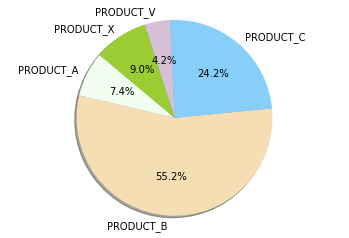

Product
PRODUCT_A     576747
PRODUCT_B    4291439
PRODUCT_C    1879572
PRODUCT_V     324499
PRODUCT_X     696845
Name: Quantity, dtype: int64

In [33]:
labels = product_sheets
sizes = data_aggregated.groupby(['Product'])['Quantity'].sum().sort_index().tolist()
colors = ['honeydew', 'wheat', 'lightskyblue', 'thistle', 'yellowgreen']
#explode = (0.1, 0)  # explode 1st slice

plt.pie(sizes, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

data_aggregated.groupby(['Product'])['Quantity'].sum().sort_index()

### Geographical Distribution of Sales By City

In [34]:
#cities world-countries.json > the coordinates file is cited (please look at Resources #1)
turkey_cities_json_source = 'geo_json/tr-cities-utf8.json'

In [35]:
data_heat_general = data_aggregated[['Province', 'Quantity']]
data_heat_general = data_heat_general.groupby(['Province'])['Quantity'].sum().reset_index()
data_heat_general['Province'] = data_heat_general['Province'].apply(lambda x: x.capitalize().replace('i̇', 'i')) 
data_heat_general.head()

data_heat_general.sort_values(by=['Province'], ascending=True).reset_index(drop=True)[:5]

,Province,Quantity
0,Adana,202564
1,Adiyaman,21711
2,Afyon,60131
3,Agri,47827
4,Aksaray,46315


In [36]:
# matching and correcting city names
city_correction_dict = {}
city_correction_dict['Adiyaman'] = 'Adıyaman'
city_correction_dict['Agri'] = 'Ağrı'
city_correction_dict['Aydin'] = 'Aydın'
city_correction_dict['Balikesir'] = 'Balıkesir'
city_correction_dict['Bartin'] = 'Bartın'
city_correction_dict['Bingol'] = 'Bingöl'
city_correction_dict['Corum'] = 'Çorum'
city_correction_dict['Canakkkale'] = 'Çanakkale'
city_correction_dict['Cankiri'] = 'Çankırı'
city_correction_dict['Diyarbakir'] = 'Diyarbakır'
city_correction_dict['Duzce'] = 'Düzce'
city_correction_dict['Elazig'] = 'Elazığ'
city_correction_dict['Eskisehir'] = 'Eskişehir'
city_correction_dict['Gumushane'] = 'Gümüşhane'
city_correction_dict['Igdir'] = 'Iğdır'
city_correction_dict['Istanbul'] = 'İstanbul'
city_correction_dict['Izmir'] = 'İzmir'
city_correction_dict['Karabuk'] = 'Karabük'
city_correction_dict['Kahramanmaras'] = 'Kahramanmaraş'
city_correction_dict['Kirikkale'] = 'Kırıkkale'
city_correction_dict['Kirklareli'] = 'Kırklareli'
city_correction_dict['Kirsehir'] = 'Kırşehir'
city_correction_dict['Kutahya'] = 'Kütahya'
city_correction_dict['Icel'] = 'Mersin'
city_correction_dict['Mugla'] = 'Muğla'
city_correction_dict['Nevsehir'] = 'Nevşehir'
city_correction_dict['Nigde'] = 'Niğde'
city_correction_dict['Sanliurfa'] = 'Şanlıurfa'
city_correction_dict['Sirnak'] = 'Şırnak'
city_correction_dict['Mus'] = 'Muş'
city_correction_dict['Tekirdag'] = 'Tekirdağ'
city_correction_dict['Usak'] = 'Uşak'


data_heat_general['Province'] = data_heat_general['Province'].apply(lambda x: city_correction_dict[x] if x in city_correction_dict.keys() else x) 

In [37]:
data_heat_general['Quantity'] = data_heat_general['Quantity'].apply(lambda x: math.log(x+0.001))
data_heat_general.head(10)

,Province,Quantity
0,Adana,12.218811
1,Adıyaman,9.985574
2,Afyon,11.004281
3,Ağrı,10.775346
4,Aksaray,10.743221
5,Amasya,10.457574
6,Ankara,13.036670
7,Antalya,12.732808
8,Ardahan,7.971431
9,Artvin,9.007367


In [38]:
# An open source geographical heat map library used for data visualization (please look at Resources #2)
import folium

turkey_heat_map_general_products_sold_by_city = folium.Map(
    location=[39.855555, 34.665873],
    #tiles='Stamen Terrain',
    zoom_start=5
)

turkey_heat_map_general_products_sold_by_city.choropleth(geo_data=turkey_cities_json_source, data=data_heat_general, columns=['Province', 'Quantity'], key_on='feature.properties.name',
                         fill_color='OrRd', fill_opacity=0.7,  line_opacity=0.2, nan_fill_color='black', nan_fill_opacity=0.2)

turkey_heat_map_general_products_sold_by_city

/home/a/anaconda3/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


## Product Insights

In [39]:
# plots the historical sales data for the wanted product
import seaborn as sns
def plot_historical_sales_data_for_the_product_wanted(product_name):
    data_sales_product = data_aggregated[data_aggregated['Product'] == product_name].groupby(['Period'])['Quantity'].sum().reset_index()
    data_sales_product['Period'] = data_sales_product['Period'].astype(str)
    fig,ax = plt.subplots(figsize=(12,4))
    ax.set_xticklabels(range(0,36))
    sns.lineplot(x="Period", y="Quantity", ax=ax, data=data_sales_product)
    plt.xticks(rotation=15)
    plt.title(product_name + ' Sales')
    plt.show()
    data_sales_product.set_index('Period').transpose()

In [40]:
#scatter plot Province/Quantity
def plot_scattered_mean_sales_by_city(product_name):
    data_province_quantity = data_aggregated[data_aggregated['Product'] == product_name].groupby(['Province'])['Quantity'].mean().reset_index()
    max_avg = data_province_quantity.Quantity.max()
    print("max_avg: {}".format(max_avg))
    print(data_province_quantity.sort_values(by=['Quantity'], ascending=False).head())
    
    var = 'Province'
    series_var = data_province_quantity[var].copy()
    for i in range(0, len(series_var)):
        series_var[i] = i+1
    
    data = pd.concat([data_province_quantity['Quantity'], series_var], axis=1)
    data.plot.scatter(x=var, y='Quantity', ylim=(0,max_avg*1.1));
    return data_province_quantity

In [41]:
def display_pie_chart(data_province_quantity):
    labels = data_province_quantity['Province'].tolist()
    sizes = data_province_quantity['Quantity'].tolist()
    labels = minor_label_filter(labels, sizes, 0.03)
    colors = ['honeydew', 'wheat', 'lightskyblue', 'thistle', 'yellowgreen']
    explode = (0.1, 0)  # explode 1st slice

    plt.pie(sizes, labels=labels, colors=colors, autopct=func_autopct, shadow=True, startangle=150)

    plt.axis('equal')
    plt.show()
    
def func_autopct(pct):
    return ('%.2f' % pct) if pct > 3 else ''
def minor_label_filter(labels, sizes, threshold_percent):
    for i,x in enumerate(sizes):
        if x/sum(sizes) < threshold_percent:
            labels[i] = ''
    return labels

## Product A

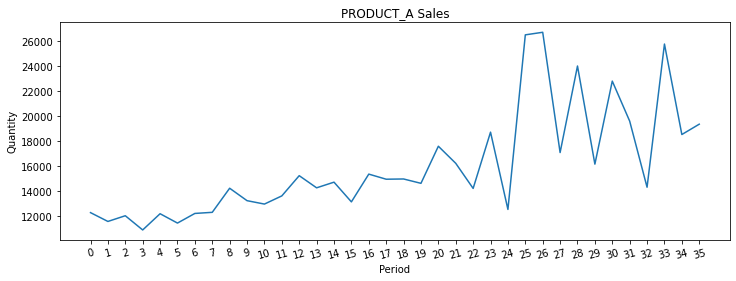

In [42]:
plot_historical_sales_data_for_the_product_wanted('PRODUCT_A')

max_avg: 3987.6666666666665
    Province     Quantity
40  ISTANBUL  3987.666667
6     ANKARA  1698.250000
41     IZMIR  1083.416667
7    ANTALYA   827.305556
0      ADANA   483.055556


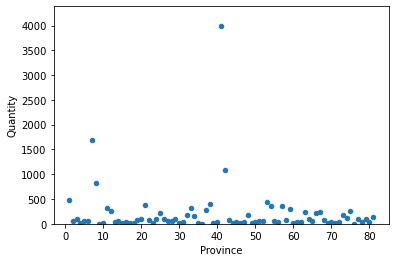

In [43]:
data_last_product = plot_scattered_mean_sales_by_city('PRODUCT_A')

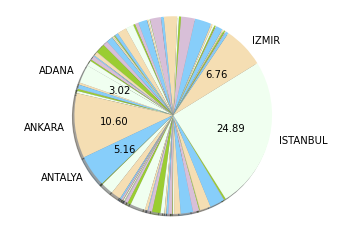

In [44]:
display_pie_chart(data_last_product)

## Product B

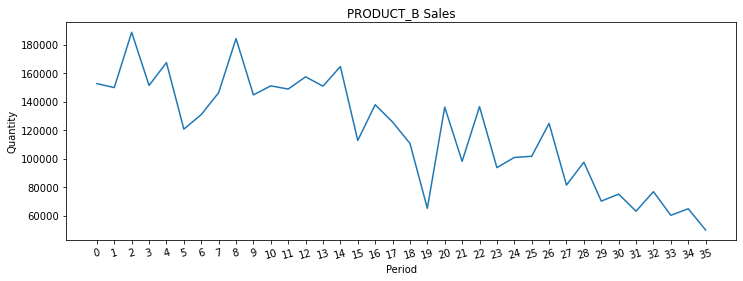

In [45]:
plot_historical_sales_data_for_the_product_wanted('PRODUCT_B')

## Product C

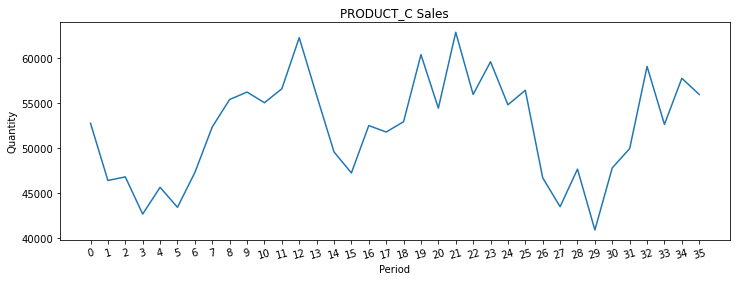

In [46]:
plot_historical_sales_data_for_the_product_wanted('PRODUCT_C')

## Product X

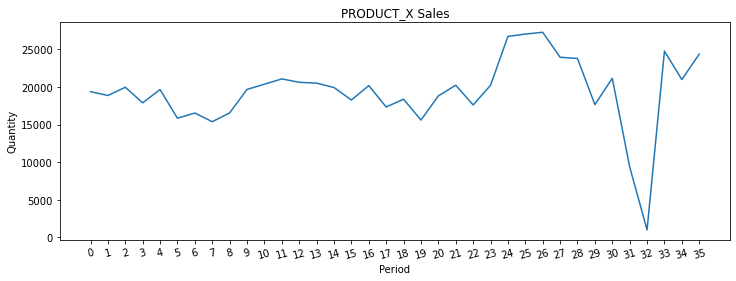

In [47]:
plot_historical_sales_data_for_the_product_wanted('PRODUCT_X')

## Product V

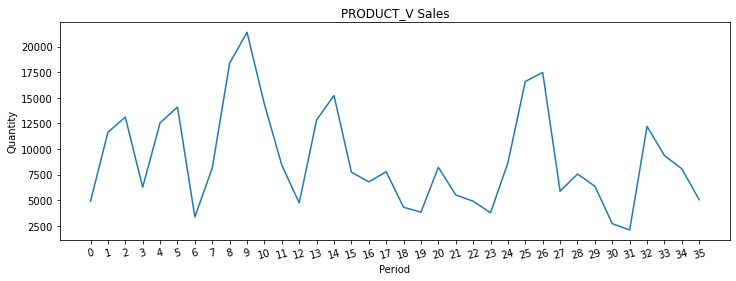

In [48]:
plot_historical_sales_data_for_the_product_wanted('PRODUCT_V')

# Product And Sector Investigation

# Acquisition of Socio-Economical And Demographical Data

### Gross Domestic Product By City
This demonstrates the accumulated wealth and flourishing of the city

In [49]:
# (please look at Resources #7)
data_gdp_by_city = pd.read_csv('datasets/tuik/gdp_by_city_2018.csv', delimiter='|')

In [50]:
data_gdp_by_city = data_gdp_by_city.transpose().reset_index().rename(columns={0: 'GDP by City', 'index': 'Province'})
data_gdp_by_city['city_id'] = pd.to_numeric(data_gdp_by_city['Province'].apply(lambda x: x.split('-')[1]))
data_gdp_by_city['city_id'] = data_gdp_by_city['city_id'].apply(lambda x: x-1)
data_gdp_by_city['Province'] = data_gdp_by_city['Province'].apply(lambda x: x.split('-')[0])
data_gdp_by_city = data_gdp_by_city.set_index('city_id').sort_index()

In [51]:
data_gdp_by_city.head(3)

,Province,GDP by City
city_id,,
0,Adana,72187342.0
1,Adıyaman,13958454.0
2,Afyonkarahisar,22804455.0


### Life Expectancy By City
This may indicate how much does an ordinary citizen cares of his/her health in that particular city

In [52]:
# (please look at Resources #8)
data_life_expectancy_by_city = pd.read_csv('datasets/tuik/life_expectancy_by_city.csv')
data_life_expectancy_by_city.tail(3)

,Province,life_expectancy
78,Kilis,76.1
79,Osmaniye,78.0
80,Düzce,77.5


### Population By City
This feature undisputedly should have a positive correlation with the number of products sold in that city.

In [53]:
# (please look at Resources #9)
data_population_by_city = pd.read_csv('datasets/tuik/population_by_city_2018.csv')
data_population_by_city['population'] = pd.to_numeric(data_population_by_city['population'].apply(lambda x: x.replace(" ", "")))
data_population_by_city.head(3)

,Province,population
0,Adana,2220125
1,Adıyaman,624513
2,Afyonkarahisar,725568


### Population Growth Rate And Population Density By City
Since it reveals the number of newborns and toddlers, Population Growth Rate most probably contributes to the performance of our models especially for PRODUCT_C to a certain extend.

In [54]:
# ((please look at Resources #10)
data_population_growth_rate_density_by_city = pd.read_csv('datasets/tuik/pop_density_and_growth_rate.csv')
#data_population_by_city['population'] = pd.to_numeric(data_population_by_city['population'].apply(lambda x: x.replace(" ", "")))
data_population_growth_rate_density_by_city.head(3)

,Province,pop_growth_rate_2016_2017,pop_growth_rate_2017_2018,pop_growth_rate_2018_2019,pop_density_2017,pop_density_2018,pop_density_2019
0,Adana,6.7,1.6,8.0,159,160,161
1,Adıyaman,7.5,15.2,3.1,87,89,89
2,Afyonkarahisar,1.6,13.7,5.4,50,51,51


### Retail Purchases Monthly Change With WAT Without Seasonal Influences (Base Prices - 2015)

- This data may demonstrate consumer behaviour in some sense.

- The monthly increase of 13.2% is remarkable for March, 2020 in which the first covid-19 case is announced in Turkey.

- We did not included online purchase data, since online drug purchases are strictly forbidden by local (Turkish) laws and regulations. In accordance with the law no. 6197, pharmacies are not even allowed to publish websites.

(please look at Resources #20 and #21)


In [55]:
# (please look at Resources #19)
data_monthly_retail_purchases_change = pd.read_csv('datasets/tuik/retail_purchases_monthly_with_wat_without_seasonal_influences_base_2015_prices.csv', delimiter='|')
data_monthly_retail_purchases_change = data_monthly_retail_purchases_change.set_index(['year']).transpose().reset_index(drop=True)
data_monthly_retail_purchases_change

year,2017,2018,2019,2020
0,0.1,2.2,-0.3,0.3
1,0.2,-1.3,-0.4,3.6
2,-0.1,0.7,2.5,13.2
3,1.5,0.7,-0.2,-4.2
4,1.4,0.8,1.4,NaN
5,-1.0,-1.7,-0.3,NaN
6,0.1,0.0,0.0,NaN
7,4.9,0.9,1.5,NaN
8,-4.4,-2.8,1.1,NaN
9,4.0,-3.3,0.2,NaN


### EUR/TRY, USD/TRY Exchange Rates, EUR/USD Parity and Monthly Turkish Minimum Wage in USD

In [56]:
data_forex = pd.read_csv('datasets/manual/USDTRYEUR.csv')
data_forex.tail()

,Period,USD/TRY_Price,USD/TRY_Change %,USD/TRY_mov_Change%,EUR/TRY_Price,EUR/TRY_Change %,EUR/TRY_mov_Change%,EUR/USD_Price,EUR/USD_Change %,EUR/USD_mov_Change%,mw_USD
35,201912,5.9489,3.51%,1.028926,6.6699,5.34%,1.059972,1.1212,1.77%,1.030165,339.558574
36,202001,5.9822,0.56%,0.971500,6.6367,-0.50%,0.944560,1.1094,-1.05%,0.972290,388.602855
37,202002,6.2427,4.35%,1.037689,6.8835,3.72%,1.042412,1.1027,-0.61%,1.004447,372.386948
38,202003,6.6143,5.95%,1.015333,7.2962,6.00%,1.021982,1.1031,0.04%,1.006540,351.465764
39,202004,6.9864,5.63%,0.996980,7.6550,4.92%,0.989811,1.0957,-0.67%,0.992903,332.746479


###  Consumer Price Index (TÜFE) and Producer Price Index  (ÜFE)

Although thier reliability is sometimes questionable, this may indicate some price changes on the market.

In [57]:
data_ufe_tufe = pd.read_csv('datasets/manual/ufe_tufe.csv')
data_ufe_tufe.tail()

,Period,TÜFE (Yıllık % Değişim),TÜFE (Aylık % Değişim),Yıllık Değişim ÜFE,ÜFE (Aylık % Değişim)
35,201912,11.84,0.74,7.36,0.69
36,202001,12.15,1.35,8.84,1.84
37,202002,12.37,0.35,9.26,0.48
38,202003,11.86,0.57,8.50,0.87
39,202004,10.94,0.85,6.71,1.28


### Number of Employees, Vechiles, Branches and Sales of Selcuk Ecza Deposu

In [58]:
data_selcuk_ecza = pd.read_csv('datasets/manual/SelcukEcza.csv')
data_selcuk_ecza.tail()

,Period,SelcukEcza_ADS,SelcukEcza_BDS,SelcukEcza_TPS,SelcukEcza_TAS,NetSales_mioTL
35,201912,27,85,6340,2418,4901.06
36,202001,27,86,6440,2464,5516.12
37,202002,27,86,6440,2464,5516.12
38,202003,27,86,6440,2464,5516.12
39,202004,27,86,6425,2412,4714.07


### Open Days for Pharmacies

We manually gathered the number of open days for each month. We counted saturdays as 0.5 since some of the pharmacies are open on these days and some does not.

In [59]:
data_open_days_for_pharmacies = pd.read_csv('datasets/manual/no_of_workdays_monthly.csv')
data_open_days_for_pharmacies.tail()

,Period,open_days_for_pharmacies
35,201912,24.0
36,202001,24.0
37,202002,22.5
38,202003,24.0
39,202004,23.0


# Feature Creation

## Acquiring Infant and Toddlers Distrubution By City (0-4) by processing children count by age and city

- This age bracket strongly correlates peculiarly with Product C as stressed in EnGenius '20 presentation document.   (please look at Resources #11)

In [60]:
# (please look at Resources #12)
data_children_count_by_age_and_city = pd.read_csv('datasets/tuik/children_number_by_age_and_city.csv', delimiter='|')
data_children_count_by_age_and_city = data_children_count_by_age_and_city.drop(columns=['Satırlar', 'Unnamed: 84'])
data_children_count_by_age_and_city = data_children_count_by_age_and_city.rename(columns={"Unnamed: 1": "category", "Unnamed: 2": "year"})
data_children_count_by_age_and_city['category'] = data_children_count_by_age_and_city['category'].fillna(method='ffill')
data_children_count_by_age_and_city['age'] = pd.to_numeric(data_children_count_by_age_and_city['category'].apply(lambda x: x.split(':')[2]))
data_children_count_by_age_and_city['gender'] = data_children_count_by_age_and_city['category'].apply(lambda x: (x.split(' ')[0]).split(':')[1])
data_children_count_by_age_and_city.head(10)

data_infants_and_toddlers = data_children_count_by_age_and_city[data_children_count_by_age_and_city.age < 5].drop(columns=['category', 'gender', 'age']).groupby(['year']).sum().reset_index()
data_infants_and_toddlers = data_infants_and_toddlers.rename(columns={'year': 'Province'}).set_index(['Province']).transpose()
data_infants_and_toddlers = data_infants_and_toddlers.reset_index()
data_infants_and_toddlers['Province'] = data_infants_and_toddlers['index'].apply(lambda x: x.split('-')[0])
data_infants_and_toddlers['index'] = pd.to_numeric(data_infants_and_toddlers['index'].apply(lambda x: x.split('-')[1]))
data_infants_and_toddlers = data_infants_and_toddlers.set_index('Province').sort_values(by=['index'], ascending=True)

data_infants_and_toddlers.head(3)

Province,index,2017,2018,2019
Province,,,,
Adana,1,190594.0,187842.0,181508.0
Adıyaman,2,62631.0,62989.0,61142.0
Afyonkarahisar,3,52997.0,52944.0,51359.0


## Acquiring Elderly Male Population Distrubution By City And Age Groups

- These age groups for male citizens substantially correlates especially with Product X as indicated in EnGenius '20 presentation document.  (please look at Resources #11)
- As revealed with our Investigation, Product X is most probably XALFU XL product which is firstly lisanced by 'Eczacıbaşı Ilaç Pazarlama' on 01/13/2016.  (please look at Resources #16)
- The elderly males who suffer from prostate enlargement in general are on medivation with XALFU XL. (Zorlu et al., 2014) (please look at Resources #13, #14)

In [61]:
# (please look at Resources #22)
data_by_city_gender_and_age_groups = pd.read_csv('datasets/tuik/population_by_city_gender_and_age_groups.csv', delimiter='|')
data_by_city_gender_and_age_groups = data_by_city_gender_and_age_groups.rename(columns={"Unnamed: 0": "year", "Unnamed: 1": "city_id"}).drop(columns=['Unnamed: 40'])
data_by_city_gender_and_age_groups['year'] = data_by_city_gender_and_age_groups['year'].fillna(method='ffill')
data_by_city_gender_and_age_groups['Province'] = data_by_city_gender_and_age_groups['city_id'].apply(lambda x: x.split('-')[0])
data_by_city_gender_and_age_groups['city_id'] = data_by_city_gender_and_age_groups['city_id'].apply(lambda x: x.split('-')[1])
data_by_city_gender_and_age_groups = data_by_city_gender_and_age_groups.set_index('Province').sort_index()

data_by_city_gender_and_age_groups.head()

,year,city_id,Erkek ve 0-4,Erkek ve 10-14,Erkek ve 15-19,Erkek ve 20-24,Erkek ve 25-29,Erkek ve 30-34,Erkek ve 35-39,Erkek ve 40-44,...,Kadın ve 50-54,Kadın ve 55-59,Kadın ve 5-9,Kadın ve 60-64,Kadın ve 65-69,Kadın ve 70-74,Kadın ve 75-79,Kadın ve 80-84,Kadın ve 85-89,Kadın ve 90+
Province,,,,,,,,,,,,,,,,,,,,,
Adana,2017.0,1,97512.0,93408.0,94576.0,83854.0,81203.0,84918.0,89858.0,79611.0,...,64703.0,54859.0,91647.0,47294.0,35249.0,23325.0,16475.0,10134.0,5981.0,2453.0
Adana,2019.0,1,92880.0,96793.0,89973.0,81930.0,79820.0,81952.0,88602.0,81661.0,...,62905.0,60161.0,92347.0,48575.0,38304.0,27956.0,17199.0,10966.0,6322.0,2843.0
Adana,2018.0,1,96048.0,95457.0,91990.0,80062.0,79326.0,82966.0,89395.0,80171.0,...,63809.0,57464.0,91203.0,47310.0,36409.0,25034.0,16748.0,10415.0,6232.0,2631.0
Adıyaman,2018.0,2,32473.0,30346.0,30310.0,25557.0,23911.0,23760.0,23287.0,19710.0,...,13215.0,11902.0,29255.0,9712.0,8964.0,6915.0,4598.0,3065.0,1781.0,1210.0
Adıyaman,2019.0,2,31328.0,30335.0,29195.0,25753.0,24037.0,23655.0,23084.0,19849.0,...,13312.0,12307.0,29630.0,9984.0,9001.0,7428.0,4832.0,3150.0,1788.0,1205.0


### Now Let's create a new dataset and extract the most useful information for our model into that.

In [62]:
data_male_elderly_pop_by_city_and_age_group = pd.DataFrame([pd.to_numeric(data_by_city_gender_and_age_groups['city_id'].unique()), data_by_city_gender_and_age_groups.index.unique()]).transpose().rename(columns={0: 'city_id', 1: 'Province'}).set_index('Province').sort_values(by=['city_id'], ascending=True)
gender_label = 'Erkek ve '

years = [2017, 2018, 2019]
for y in years:
    data_male_elderly_pop_by_city_and_age_group[str(y)+'_'+'90+'+'_male'] = data_by_city_gender_and_age_groups[data_by_city_gender_and_age_groups.year == y][gender_label+'90+']
    for i in range(10,18):
        data_male_elderly_pop_by_city_and_age_group[str(y)+'_'+str(i*5)+'-'+str((i+1)*5-1)+'_male'] = data_by_city_gender_and_age_groups[data_by_city_gender_and_age_groups.year == y][gender_label+str(i*5)+'-'+str((i+1)*5-1)]

data_male_elderly_pop_by_city_and_age_group.head()

,city_id,2017_90+_male,2017_50-54_male,2017_55-59_male,2017_60-64_male,2017_65-69_male,2017_70-74_male,2017_75-79_male,2017_80-84_male,2017_85-89_male,...,2018_85-89_male,2019_90+_male,2019_50-54_male,2019_55-59_male,2019_60-64_male,2019_65-69_male,2019_70-74_male,2019_75-79_male,2019_80-84_male,2019_85-89_male
Province,,,,,,,,,,,,,,,,,,,,,
Adana,1,835.0,64647.0,53873.0,46331.0,32148.0,18920.0,11984.0,6754.0,3089.0,...,3654.0,966.0,63073.0,58703.0,47689.0,35466.0,22956.0,12559.0,6675.0,3886.0
Adıyaman,2,234.0,15002.0,10660.0,9587.0,7423.0,4781.0,3837.0,2309.0,1192.0,...,1425.0,322.0,14761.0,12776.0,9797.0,8001.0,5689.0,3819.0,2250.0,1547.0
Afyonkarahisar,3,384.0,21013.0,19871.0,16599.0,12513.0,8320.0,6314.0,4143.0,1831.0,...,2244.0,508.0,21566.0,21045.0,17546.0,13774.0,9649.0,6206.0,3993.0,2249.0
Ağrı,4,140.0,9614.0,7135.0,6091.0,3585.0,2985.0,1755.0,1036.0,456.0,...,538.0,147.0,8519.0,8739.0,5941.0,4313.0,3118.0,1856.0,1049.0,557.0
Amasya,5,220.0,10689.0,9814.0,8957.0,7195.0,5400.0,3837.0,2720.0,1152.0,...,1438.0,295.0,10483.0,10867.0,9346.0,7627.0,6113.0,3777.0,2534.0,1597.0


## Stock Prices
    Investors, Brokers and Members of Fund Boards are sensitive to even "secondly" changes and follow all advancements closely. Many important factors are reported to KAP (public disclosure platform) as an obligation. Although, insider trading is considered as a crime, all kind of information is used during the investors decision making processes, legit or not. (please look at Resources #24)

In [63]:
dict_month_abbrevations = {}
dict_month_abbrevations['Jan'] = '01'
dict_month_abbrevations['Feb'] = '02'
dict_month_abbrevations['Mar'] = '03'
dict_month_abbrevations['Apr'] = '04'
dict_month_abbrevations['May'] = '05'
dict_month_abbrevations['Jun'] = '06'
dict_month_abbrevations['Jul'] = '07'
dict_month_abbrevations['Aug'] = '08'
dict_month_abbrevations['Sep'] = '09'
dict_month_abbrevations['Oct'] = '10'
dict_month_abbrevations['Nov'] = '11'
dict_month_abbrevations['Dec'] = '12'

In [64]:
# (please look at Resources #3, #4, #5, #6)
stock_names_list = ['ECILC', 'BIST100', 'DEVA', 'SELEC']
stock_data = {}

### ECILC (Eczacibasi Ilac Pazarlama Stocks) - Raw Form

In [65]:
data_ECILC = pd.read_csv('datasets/stock_prices/ECILC_Hist.csv')
data_ECILC.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,Apr 20,4.78,4.664,5.36,4.152,1.90B,0.21%
1,Mar 20,4.77,3.910,5.34,2.930,1.09B,24.87%
2,Feb 20,3.82,4.180,4.45,3.150,320.93M,-8.61%
3,Jan 20,4.18,3.720,4.35,3.530,546.74M,12.67%
4,Dec 19,3.71,3.490,3.85,3.440,535.85M,7.23%


### Organize and Normalize Stock Prices

In [66]:
def process_stock_data(stock_name):
    data = pd.read_csv('datasets/stock_prices/'+stock_name+'_Hist.csv')
    data['Period'] = data['Date'].apply(lambda x: '20'+x.split(' ')[1]+dict_month_abbrevations[x.split(' ')[0]]).astype(int)
    data['Change %'] = data['Change %'].apply(lambda x: x.replace('%', ''))
    data['Vol.'] = data['Vol.'].apply(lambda x: x[:-1])
    data = data.sort_values(by=['Period']).reset_index(drop=True)
    data = data.drop(columns=['Date'])
    
    for c in data.columns.tolist():
        if str(data.dtypes[c]) == 'object':
            data[c] = data[c].apply(lambda x: x.replace(',', ''))
            
    data = data.astype(float)
    data.Period = data.Period.astype(int)
    data = data.rename(columns={'Change %': 'Change'})
    data.columns = [str(col) + '_' + stock_name if col != 'Period' else str(col) for col in data.columns]
    
    return data

In [67]:
for s in stock_names_list:
    stock_data[s] = process_stock_data(s)
    print("\n"+s)
    print(stock_data[s].head())


ECILC
   Price_ECILC  Open_ECILC  High_ECILC  Low_ECILC  Vol._ECILC  Change_ECILC  \
0        2.418       2.321       2.470      2.210       79.45          4.18   
1        2.485       2.426       2.798      2.411       92.50          2.77   
2        2.738       2.485       2.790      2.485       97.86         10.18   
3        3.155       2.753       3.184      2.738       67.37         15.23   
4        3.908       3.199       4.278      3.057      217.92         23.87   

   Period  
0  201701  
1  201702  
2  201703  
3  201704  
4  201705  

BIST100
   Price_BIST100  Open_BIST100  High_BIST100  Low_BIST100  Vol._BIST100  \
0         862.96        779.07        867.17       756.57         18.36   
1         874.78        863.90        895.83       860.01         16.34   
2         889.47        877.20        914.97       876.39         16.46   
3         946.55        890.20        951.96       879.98         14.66   
4         975.42        949.94        987.95       930.00     

### Standardization of ECILC data based on references such as BIST1000 and XPHARM3

In [68]:
#rename columns and merge datasets
data_ECILC = stock_data['ECILC']
for s in stock_names_list:
    if s != 'ECILC':
        data_ECILC = pd.merge(data_ECILC, stock_data[s], how="left", left_on="Period", right_on="Period")

data_ECILC.head()

,Price_ECILC,Open_ECILC,High_ECILC,Low_ECILC,Vol._ECILC,Change_ECILC,Period,Price_BIST100,Open_BIST100,High_BIST100,...,High_DEVA,Low_DEVA,Vol._DEVA,Change_DEVA,Price_SELEC,Open_SELEC,High_SELEC,Low_SELEC,Vol._SELEC,Change_SELEC
0,2.418,2.321,2.470,2.210,79.45,4.18,201701,862.96,779.07,867.17,...,3.803,3.396,70.88,7.10,3.196,2.834,3.242,2.825,18.11,12.38
1,2.485,2.426,2.798,2.411,92.50,2.77,201702,874.78,863.90,895.83,...,3.992,3.724,64.11,3.18,3.103,3.205,3.492,3.103,7.41,-2.91
2,2.738,2.485,2.790,2.485,97.86,10.18,201703,889.47,877.20,914.97,...,3.962,3.744,29.75,-0.51,3.094,3.149,3.288,3.038,10.80,-0.29
3,3.155,2.753,3.184,2.738,67.37,15.23,201704,946.55,890.20,951.96,...,4.300,3.813,33.83,10.08,3.353,3.103,3.390,3.094,13.19,8.37
4,3.908,3.199,4.278,3.057,217.92,23.87,201705,975.42,949.94,987.95,...,4.340,3.992,26.62,-3.76,3.697,3.362,3.754,3.270,20.26,10.26


### Creating XPHARM3, a brand-new Pharmaceutical Stocks Index which consists of Eczacibasi Ilac Pazarlama, Selcuk Ecza Deposu and Deva Holding Shares

In [69]:
stock_col_var_names = ['Price', 'Open', 'High', 'Low', 'Vol.']

pharmaceutical_stock_names_list = ['ECILC', 'DEVA', 'SELEC']
std_scaler = preprocessing.StandardScaler()
min_max_scaler = MinMaxScaler()
for s in pharmaceutical_stock_names_list:
    cr_column_list = ['{}_{}'.format(a, b) for b in [s] for a in stock_col_var_names]
    std_column_list = ['{}_{}'.format(a, b) for b in [s+'_std'] for a in stock_col_var_names]
    data_ECILC[std_column_list] = data_ECILC[cr_column_list].copy()
    data_ECILC[std_column_list] = std_scaler.fit_transform(data_ECILC[std_column_list])
    data_ECILC[std_column_list] = min_max_scaler.fit_transform(data_ECILC[std_column_list])


for s in stock_col_var_names:
    col_names_of_3 = ['{}_{}_{}'.format(a, b, c) for c in ['std'] for a in [s] for b in pharmaceutical_stock_names_list]
    cols = data_ECILC[col_names_of_3]
    data_ECILC[s+'_XPHARM3_avg'] = cols.mean(axis=1)


cols = data_ECILC[['{}_{}'.format(a, b) for a in ['Change'] for b in pharmaceutical_stock_names_list]]
data_ECILC['Change'+'_XPHARM3_avg'] = cols.mean(axis=1)

data_ECILC.head()

,Price_ECILC,Open_ECILC,High_ECILC,Low_ECILC,Vol._ECILC,Change_ECILC,Period,Price_BIST100,Open_BIST100,High_BIST100,...,Open_SELEC_std,High_SELEC_std,Low_SELEC_std,Vol._SELEC_std,Price_XPHARM3_avg,Open_XPHARM3_avg,High_XPHARM3_avg,Low_XPHARM3_avg,Vol._XPHARM3_avg,Change_XPHARM3_avg
0,2.418,2.321,2.470,2.210,79.45,4.18,201701,862.96,779.07,867.17,...,0.023164,0.033115,0.047133,0.059258,0.059511,0.018935,0.020975,0.044041,0.166497,7.886667
1,2.485,2.426,2.798,2.411,92.50,2.77,201702,874.78,863.90,895.83,...,0.104240,0.074098,0.114674,0.003639,0.065256,0.072130,0.075898,0.116640,0.145413,1.013333
2,2.738,2.485,2.790,2.485,97.86,10.18,201703,889.47,877.20,914.97,...,0.092002,0.040656,0.098882,0.021260,0.098268,0.081001,0.063197,0.124659,0.101186,3.126667
3,3.155,2.753,3.184,2.738,67.37,15.23,201704,946.55,890.20,951.96,...,0.081949,0.057377,0.112488,0.033683,0.182241,0.114757,0.120727,0.174640,0.093039,11.226667
4,3.908,3.199,4.278,3.057,217.92,23.87,201705,975.42,949.94,987.95,...,0.138549,0.117049,0.155248,0.070434,0.303329,0.213519,0.265516,0.250903,0.186058,10.123333


In [70]:
data_ECILC['Price'+'_ECILC_rltv_to_BIST100'] = data_ECILC['Price'+'_ECILC'] / data_ECILC['Price'+'_BIST100']
data_ECILC.head()

,Price_ECILC,Open_ECILC,High_ECILC,Low_ECILC,Vol._ECILC,Change_ECILC,Period,Price_BIST100,Open_BIST100,High_BIST100,...,High_SELEC_std,Low_SELEC_std,Vol._SELEC_std,Price_XPHARM3_avg,Open_XPHARM3_avg,High_XPHARM3_avg,Low_XPHARM3_avg,Vol._XPHARM3_avg,Change_XPHARM3_avg,Price_ECILC_rltv_to_BIST100
0,2.418,2.321,2.470,2.210,79.45,4.18,201701,862.96,779.07,867.17,...,0.033115,0.047133,0.059258,0.059511,0.018935,0.020975,0.044041,0.166497,7.886667,0.002802
1,2.485,2.426,2.798,2.411,92.50,2.77,201702,874.78,863.90,895.83,...,0.074098,0.114674,0.003639,0.065256,0.072130,0.075898,0.116640,0.145413,1.013333,0.002841
2,2.738,2.485,2.790,2.485,97.86,10.18,201703,889.47,877.20,914.97,...,0.040656,0.098882,0.021260,0.098268,0.081001,0.063197,0.124659,0.101186,3.126667,0.003078
3,3.155,2.753,3.184,2.738,67.37,15.23,201704,946.55,890.20,951.96,...,0.057377,0.112488,0.033683,0.182241,0.114757,0.120727,0.174640,0.093039,11.226667,0.003333
4,3.908,3.199,4.278,3.057,217.92,23.87,201705,975.42,949.94,987.95,...,0.117049,0.155248,0.070434,0.303329,0.213519,0.265516,0.250903,0.186058,10.123333,0.004006


### Extracting relative performance of ECILC in correlation with BIST100 and XPHARM3

In [71]:
for s in stock_col_var_names:
    data_ECILC[s+'_ECILC_rltv_to_BIST100'] = data_ECILC[s+'_ECILC'] / data_ECILC[s+'_BIST100']
    data_ECILC[s+'_ECILC_rltv_to_XPHARM3'] = data_ECILC[s+'_ECILC'] / data_ECILC[s+'_XPHARM3_avg']


data_ECILC['Change'+'_ECILC_rltv_to_BIST100'] = data_ECILC['Change'+'_ECILC'] - data_ECILC['Change'+'_BIST100']
data_ECILC['Change'+'_ECILC_rltv_to_XPHARM3'] = data_ECILC['Change'+'_ECILC'] - data_ECILC['Change'+'_XPHARM3_avg']


data_ECILC.head()

,Price_ECILC,Open_ECILC,High_ECILC,Low_ECILC,Vol._ECILC,Change_ECILC,Period,Price_BIST100,Open_BIST100,High_BIST100,...,Open_ECILC_rltv_to_BIST100,Open_ECILC_rltv_to_XPHARM3,High_ECILC_rltv_to_BIST100,High_ECILC_rltv_to_XPHARM3,Low_ECILC_rltv_to_BIST100,Low_ECILC_rltv_to_XPHARM3,Vol._ECILC_rltv_to_BIST100,Vol._ECILC_rltv_to_XPHARM3,Change_ECILC_rltv_to_BIST100,Change_ECILC_rltv_to_XPHARM3
0,2.418,2.321,2.470,2.210,79.45,4.18,201701,862.96,779.07,867.17,...,0.002979,122.574563,0.002848,117.759872,0.002921,50.180148,4.327342,477.184604,-6.26,-3.706667
1,2.485,2.426,2.798,2.411,92.50,2.77,201702,874.78,863.90,895.83,...,0.002808,33.633882,0.003123,36.865260,0.002803,20.670501,5.660955,636.118368,1.40,1.756667
2,2.738,2.485,2.790,2.485,97.86,10.18,201703,889.47,877.20,914.97,...,0.002833,30.678553,0.003049,44.147791,0.002835,19.934405,5.945322,967.131987,8.50,7.053333
3,3.155,2.753,3.184,2.738,67.37,15.23,201704,946.55,890.20,951.96,...,0.003093,23.989898,0.003345,26.373540,0.003111,15.677963,4.595498,724.106937,8.81,4.003333
4,3.908,3.199,4.278,3.057,217.92,23.87,201705,975.42,949.94,987.95,...,0.003368,14.982304,0.004330,16.112010,0.003287,12.184007,11.766739,1171.244826,20.82,13.746667


In [72]:
#filter irrelevant features and normalize the rest
data_ECILC = data_ECILC[['Period']+[x for x in data_ECILC.columns.tolist() if 'ECILC' in x]]
min_max_scaler = MinMaxScaler()
data_ECILC[[x for x in data_ECILC.columns.tolist() if 'ECILC' in x]] = min_max_scaler.fit_transform(data_ECILC[[x for x in data_ECILC.columns.tolist() if 'ECILC' in x]])
data_ECILC.head()

,Period,Price_ECILC,Open_ECILC,High_ECILC,Low_ECILC,Vol._ECILC,Change_ECILC,Price_ECILC_std,Open_ECILC_std,High_ECILC_std,...,Open_ECILC_rltv_to_BIST100,Open_ECILC_rltv_to_XPHARM3,High_ECILC_rltv_to_BIST100,High_ECILC_rltv_to_XPHARM3,Low_ECILC_rltv_to_BIST100,Low_ECILC_rltv_to_XPHARM3,Vol._ECILC_rltv_to_BIST100,Vol._ECILC_rltv_to_XPHARM3,Change_ECILC_rltv_to_BIST100,Change_ECILC_rltv_to_XPHARM3
0,201701,0.043725,0.004673,0.017007,0.034791,0.143609,0.531583,0.043725,0.004673,0.017007,...,0.206940,0.817596,0.160729,1.000000,0.241327,0.630689,0.149731,0.307821,0.119516,0.470201
1,201702,0.070850,0.049278,0.128571,0.134692,0.167525,0.499660,0.070850,0.049278,0.128571,...,0.148071,0.201719,0.257315,0.278827,0.191835,0.226341,0.196162,0.410698,0.264372,0.636042
2,201703,0.173279,0.074342,0.125850,0.171471,0.177348,0.667421,0.173279,0.074342,0.125850,...,0.156568,0.181254,0.231298,0.343750,0.205317,0.216254,0.206062,0.624962,0.398638,0.796823
3,201704,0.342105,0.188190,0.259864,0.297217,0.121470,0.781752,0.342105,0.188190,0.259864,...,0.245969,0.134938,0.335042,0.185293,0.321423,0.157932,0.159067,0.467653,0.404501,0.704240
4,201705,0.646964,0.377655,0.631973,0.455765,0.397379,0.977360,0.646964,0.377655,0.631973,...,0.340648,0.072564,0.681151,0.093812,0.395336,0.110057,0.408741,0.757084,0.631619,1.000000


In [73]:

data_aggregated_temp = data_aggregated_enlarged.copy()
data_aggregated_temp = pd.merge(data_aggregated_temp, data_ECILC, how="left", left_on="Period", right_on="Period")
data_aggregated_temp.head()

,Period,Province,Product,Quantity,Month,Year,Price_ECILC,Open_ECILC,High_ECILC,Low_ECILC,...,Open_ECILC_rltv_to_BIST100,Open_ECILC_rltv_to_XPHARM3,High_ECILC_rltv_to_BIST100,High_ECILC_rltv_to_XPHARM3,Low_ECILC_rltv_to_BIST100,Low_ECILC_rltv_to_XPHARM3,Vol._ECILC_rltv_to_BIST100,Vol._ECILC_rltv_to_XPHARM3,Change_ECILC_rltv_to_BIST100,Change_ECILC_rltv_to_XPHARM3
0,201701,ADANA,PRODUCT_A,346,1,2017,0.043725,0.004673,0.017007,0.034791,...,0.20694,0.817596,0.160729,1.0,0.241327,0.630689,0.149731,0.307821,0.119516,0.470201
1,201701,ADANA,PRODUCT_B,4838,1,2017,0.043725,0.004673,0.017007,0.034791,...,0.20694,0.817596,0.160729,1.0,0.241327,0.630689,0.149731,0.307821,0.119516,0.470201
2,201701,ADANA,PRODUCT_C,1004,1,2017,0.043725,0.004673,0.017007,0.034791,...,0.20694,0.817596,0.160729,1.0,0.241327,0.630689,0.149731,0.307821,0.119516,0.470201
3,201701,ADANA,PRODUCT_V,20,1,2017,0.043725,0.004673,0.017007,0.034791,...,0.20694,0.817596,0.160729,1.0,0.241327,0.630689,0.149731,0.307821,0.119516,0.470201
4,201701,ADANA,PRODUCT_X,910,1,2017,0.043725,0.004673,0.017007,0.034791,...,0.20694,0.817596,0.160729,1.0,0.241327,0.630689,0.149731,0.307821,0.119516,0.470201


In [74]:
data_aggregated_country = pd.merge(data_aggregated_country, data_ECILC, how="left", left_on="Period", right_on="Period")
data_aggregated_country.head()

,Period,Product,Quantity,Month,Year,Price_ECILC,Open_ECILC,High_ECILC,Low_ECILC,Vol._ECILC,...,Open_ECILC_rltv_to_BIST100,Open_ECILC_rltv_to_XPHARM3,High_ECILC_rltv_to_BIST100,High_ECILC_rltv_to_XPHARM3,Low_ECILC_rltv_to_BIST100,Low_ECILC_rltv_to_XPHARM3,Vol._ECILC_rltv_to_BIST100,Vol._ECILC_rltv_to_XPHARM3,Change_ECILC_rltv_to_BIST100,Change_ECILC_rltv_to_XPHARM3
0,201701,PRODUCT_A,12289,1,2017,0.043725,0.004673,0.017007,0.034791,0.143609,...,0.20694,0.817596,0.160729,1.0,0.241327,0.630689,0.149731,0.307821,0.119516,0.470201
1,201701,PRODUCT_B,152632,1,2017,0.043725,0.004673,0.017007,0.034791,0.143609,...,0.20694,0.817596,0.160729,1.0,0.241327,0.630689,0.149731,0.307821,0.119516,0.470201
2,201701,PRODUCT_C,52767,1,2017,0.043725,0.004673,0.017007,0.034791,0.143609,...,0.20694,0.817596,0.160729,1.0,0.241327,0.630689,0.149731,0.307821,0.119516,0.470201
3,201701,PRODUCT_V,4905,1,2017,0.043725,0.004673,0.017007,0.034791,0.143609,...,0.20694,0.817596,0.160729,1.0,0.241327,0.630689,0.149731,0.307821,0.119516,0.470201
4,201701,PRODUCT_X,19375,1,2017,0.043725,0.004673,0.017007,0.034791,0.143609,...,0.20694,0.817596,0.160729,1.0,0.241327,0.630689,0.149731,0.307821,0.119516,0.470201


In [75]:
data_aggregated_temp[400:410]

,Period,Province,Product,Quantity,Month,Year,Price_ECILC,Open_ECILC,High_ECILC,Low_ECILC,...,Open_ECILC_rltv_to_BIST100,Open_ECILC_rltv_to_XPHARM3,High_ECILC_rltv_to_BIST100,High_ECILC_rltv_to_XPHARM3,Low_ECILC_rltv_to_BIST100,Low_ECILC_rltv_to_XPHARM3,Vol._ECILC_rltv_to_BIST100,Vol._ECILC_rltv_to_XPHARM3,Change_ECILC_rltv_to_BIST100,Change_ECILC_rltv_to_XPHARM3
400,201701,ŞIRNAK,PRODUCT_A,10,1,2017,0.043725,0.004673,0.017007,0.034791,...,0.206940,0.817596,0.160729,1.000000,0.241327,0.630689,0.149731,0.307821,0.119516,0.470201
401,201701,ŞIRNAK,PRODUCT_B,392,1,2017,0.043725,0.004673,0.017007,0.034791,...,0.206940,0.817596,0.160729,1.000000,0.241327,0.630689,0.149731,0.307821,0.119516,0.470201
402,201701,ŞIRNAK,PRODUCT_C,283,1,2017,0.043725,0.004673,0.017007,0.034791,...,0.206940,0.817596,0.160729,1.000000,0.241327,0.630689,0.149731,0.307821,0.119516,0.470201
403,201701,ŞIRNAK,PRODUCT_V,0,1,2017,0.043725,0.004673,0.017007,0.034791,...,0.206940,0.817596,0.160729,1.000000,0.241327,0.630689,0.149731,0.307821,0.119516,0.470201
404,201701,ŞIRNAK,PRODUCT_X,26,1,2017,0.043725,0.004673,0.017007,0.034791,...,0.206940,0.817596,0.160729,1.000000,0.241327,0.630689,0.149731,0.307821,0.119516,0.470201
405,201702,ADANA,PRODUCT_A,402,2,2017,0.070850,0.049278,0.128571,0.134692,...,0.148071,0.201719,0.257315,0.278827,0.191835,0.226341,0.196162,0.410698,0.264372,0.636042
406,201702,ADANA,PRODUCT_B,5275,2,2017,0.070850,0.049278,0.128571,0.134692,...,0.148071,0.201719,0.257315,0.278827,0.191835,0.226341,0.196162,0.410698,0.264372,0.636042
407,201702,ADANA,PRODUCT_C,960,2,2017,0.070850,0.049278,0.128571,0.134692,...,0.148071,0.201719,0.257315,0.278827,0.191835,0.226341,0.196162,0.410698,0.264372,0.636042
408,201702,ADANA,PRODUCT_V,98,2,2017,0.070850,0.049278,0.128571,0.134692,...,0.148071,0.201719,0.257315,0.278827,0.191835,0.226341,0.196162,0.410698,0.264372,0.636042
409,201702,ADANA,PRODUCT_X,915,2,2017,0.070850,0.049278,0.128571,0.134692,...,0.148071,0.201719,0.257315,0.278827,0.191835,0.226341,0.196162,0.410698,0.264372,0.636042


## Google Trends Data

Google Trends data provide us with a chance to examine the behavioural pattern both in time and space (geolocation) plane. It is known that Google Inc. is able to discover an epidemy or pandemia much before the local governments. (Verma et al., 2018) (please look at Resources #26)

In [76]:
def get_trends_data(keywords):
    trends_data = pd.DataFrame(columns=['Period', 'Province'])
    for i,keyword in enumerate(keywords):
        cr_trends_data = pd.read_csv('datasets/google_trends/trends_keyword_'+keyword+'.csv')
        cr_trends_data = cr_trends_data.rename(columns={'geoName': 'Province'})
        cr_trends_data.Province = cr_trends_data.Province.apply(lambda x: internationalize_the_text(x.split(' ')[0]))
        if i == 0:
            trends_data = pd.merge(trends_data, cr_trends_data, how="outer",  left_on=['Period', 'Province'], right_on=['Period', 'Province'])[['Period', 'Province', keyword]]
        else:
            trends_data = pd.merge(trends_data, cr_trends_data, how="left",  left_on=['Period', 'Province'], right_on=['Period', 'Province'])
    return trends_data

trends_data = get_trends_data(['hastane', 'hastane_randevu', 'ilac', 'bas_agrisi', 'grip', 'salgin', 'ASACOL', 'Biofenac', 'BioGaia', 'gastroenteroloji_randevu', 'Medigard', 'mhrs', 'uroloji_randevu', 'Xalfu' ])

trends_data.shape

(3240, 16)

In [77]:
cr_trends_data_tr = pd.read_csv('datasets/google_trends/country/trends_tr_keyword_'+"ilac"+'.csv')

In [78]:
cr_trends_data_tr.head()

,Period,ilaç
0,201701,43.80
1,201702,45.75
2,201703,46.50
3,201704,45.20
4,201705,46.75


In [79]:
def get_trends_tr_data(keywords):
    trends_data_tr = pd.DataFrame(columns=['Period'])
    for i,keyword in enumerate(keywords):
        cr_trends_data = pd.read_csv('datasets/google_trends/country/trends_tr_keyword_'+keyword+'.csv')
        #cr_trends_data = cr_trends_data.rename(columns={'geoName': 'Province'})
        #cr_trends_data.Province = cr_trends_data.Province.apply(lambda x: internationalize_the_text(x.split(' ')[0]))
        if i == 0:
            trends_data_tr = pd.merge(trends_data_tr, cr_trends_data, how="outer",  left_on=['Period'], right_on=['Period'])[['Period', keyword]]
        else:
            trends_data_tr = pd.merge(trends_data_tr, cr_trends_data, how="left",  left_on=['Period'], right_on=['Period'])
    
    #normalize the data
    min_max_scaler = MinMaxScaler()
    columns_to_normalize = trends_data_tr.columns.tolist()[1:]
    trends_data_tr[columns_to_normalize] = min_max_scaler.fit_transform(trends_data_tr[columns_to_normalize])

    
    return trends_data_tr

trends_data_tr = get_trends_tr_data(['hastane', 'hastane_randevu', 'ilac', 'bas_agrisi', 'grip', 'salgin', 'ASACOL', 'Biofenac', 'BioGaia', 'gastroenteroloji_randevu', 'Medigard', 'mhrs', 'uroloji_randevu', 'Xalfu', 'Salofalk', 'Asec', 'Xatral' ])

trends_data_tr.shape

(40, 18)

In [80]:
#trends_data = trends_data[trends_data.Period < 202000]
trends_data.tail()

,Period,Province,hastane,hastane randevu,ilaç,baş ağrısı,grip,salgın,ASACOL,Biofenac,BioGaia,gastroenteroloji randevu,Medigard,mhrs,üroloji randevu,Xalfu
3235,202004,CORUM,0.994924,1.928571,0.693727,0.590529,0.847059,1.000000,0.000000,0.00,0.000000,0.000000,0.000000,2.032787,0.000000,0.000000
3236,202004,ISTANBUL,0.994924,1.071429,0.900369,0.701950,1.082353,1.476190,2.574257,0.50,0.534562,4.421053,0.105263,2.295082,2.230769,2.827586
3237,202004,IZMIR,0.913706,1.142857,0.929889,0.635097,0.988235,1.333333,3.960396,1.35,0.626728,0.000000,0.105263,1.704918,5.076923,0.000000
3238,202004,SANLIURFA,0.710660,1.714286,0.782288,0.579387,0.941176,0.904762,0.000000,0.00,0.847926,0.000000,0.000000,1.049180,0.000000,0.000000
3239,202004,SIRNAK,0.730964,2.428571,0.693727,0.445682,1.600000,1.571429,0.000000,0.00,0.000000,0.000000,0.000000,1.180328,0.000000,0.000000


In [81]:

trends_data_tr.tail()

,Period,hastane,hastane randevu,ilaç,baş ağrısı,grip,salgın,ASACOL,Biofenac,BioGaia,gastroenteroloji randevu,Medigard,mhrs,üroloji randevu,Xalfu,Salofalk,Asec,Xatral
35,201912,0.744379,0.849007,0.617801,0.313276,0.730803,0.017751,0.352332,0.148936,0.978873,0.671304,0.296137,0.886731,0.957419,0.446154,0.328100,0.662903,0.870027
36,202001,1.000000,0.983444,0.692408,0.355301,1.000000,0.123274,0.233161,0.180851,0.591549,0.643478,0.286123,1.000000,1.000000,0.538462,0.282575,0.516129,0.854111
37,202002,0.798817,0.817881,0.600785,0.269341,0.558694,0.069034,0.217617,0.000000,0.950704,0.808696,0.264664,0.906149,0.954839,0.393665,0.290424,1.000000,0.675066
38,202003,0.465089,0.337748,1.000000,0.531041,0.956752,1.000000,0.169948,0.085106,0.809859,0.201739,1.000000,0.423301,0.255484,0.370136,0.265306,0.320968,0.514589
39,202004,0.000000,0.000000,0.784031,1.000000,0.170344,0.409270,0.227979,0.164894,0.816901,0.000000,0.357654,0.000000,0.000000,0.162896,0.078493,0.129032,0.449602


In [82]:
trends_data[trends_data.isna().any(axis=1)]

,Period,Province,hastane,hastane randevu,ilaç,baş ağrısı,grip,salgın,ASACOL,Biofenac,BioGaia,gastroenteroloji randevu,Medigard,mhrs,üroloji randevu,Xalfu
0,201701,ADANA,0.630915,0.627010,1.057692,0.480769,0.645161,2.142857,NaN,2.685950,0.409483,0.000000,0.0,0.400000,0.000000,0.0
1,201701,ADIYAMAN,0.567823,0.530547,0.456731,0.653846,0.460829,0.000000,NaN,0.000000,0.000000,0.000000,0.0,0.716667,0.000000,0.0
2,201701,AFYON,1.372240,0.852090,0.961538,0.442308,0.529954,6.428571,NaN,0.000000,0.000000,0.000000,0.0,0.500000,0.000000,0.0
3,201701,AKSARAY,0.615142,0.868167,1.033654,0.442308,1.013825,10.714286,NaN,0.000000,0.000000,0.000000,0.0,0.416667,0.000000,0.0
4,201701,AMASYA,1.214511,1.366559,1.009615,0.615385,0.760369,0.000000,NaN,0.000000,0.000000,0.000000,0.0,0.916667,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2586,201908,CANKIRI,0.450161,0.853333,1.737557,0.713615,1.882353,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.852941,0.000000,NaN
2587,201908,CORUM,0.771704,0.480000,0.923077,0.544601,1.882353,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,1.044118,0.000000,NaN
2589,201908,IZMIR,0.745981,0.426667,1.104072,0.694836,0.847059,4.000000,18.181818,0.331034,0.708571,2.272727,inf,0.735294,1.014925,NaN
2590,201908,SANLIURFA,0.463023,0.306667,1.357466,0.488263,0.705882,6.400000,0.000000,0.000000,1.828571,0.000000,NaN,0.352941,0.000000,NaN


In [83]:
trends_data = trends_data.replace([np.inf, -np.inf], np.nan)
trends_data = trends_data.sort_values(by=['Province', 'Period']).fillna(method='ffill').fillna(0)

In [84]:
data_aggregated_temp = pd.merge(data_aggregated_temp, trends_data, how="left", left_on=['Period', 'Province'], right_on=['Period', 'Province'])
data_aggregated_temp.head()

,Period,Province,Product,Quantity,Month,Year,Price_ECILC,Open_ECILC,High_ECILC,Low_ECILC,...,grip,salgın,ASACOL,Biofenac,BioGaia,gastroenteroloji randevu,Medigard,mhrs,üroloji randevu,Xalfu
0,201701,ADANA,PRODUCT_A,346,1,2017,0.043725,0.004673,0.017007,0.034791,...,0.645161,2.142857,0.0,2.68595,0.409483,0.0,0.0,0.4,0.0,0.0
1,201701,ADANA,PRODUCT_B,4838,1,2017,0.043725,0.004673,0.017007,0.034791,...,0.645161,2.142857,0.0,2.68595,0.409483,0.0,0.0,0.4,0.0,0.0
2,201701,ADANA,PRODUCT_C,1004,1,2017,0.043725,0.004673,0.017007,0.034791,...,0.645161,2.142857,0.0,2.68595,0.409483,0.0,0.0,0.4,0.0,0.0
3,201701,ADANA,PRODUCT_V,20,1,2017,0.043725,0.004673,0.017007,0.034791,...,0.645161,2.142857,0.0,2.68595,0.409483,0.0,0.0,0.4,0.0,0.0
4,201701,ADANA,PRODUCT_X,910,1,2017,0.043725,0.004673,0.017007,0.034791,...,0.645161,2.142857,0.0,2.68595,0.409483,0.0,0.0,0.4,0.0,0.0


## Sentiment Analysis Data Scraped From Twitter And Evaluated through NLP

In [85]:
sentiment_data = pd.read_csv('datasets/sentiment_analysis_twitter/sentiment_analysis_twitter_all_polarity_values.csv')
sentiment_data.head()

,Period,sentiment_analysis_acik_eczane_polarity,sentiment_analysis_ilac_polarity,sentiment_analysis_mhrs_polarity,sentiment_analysis_vitamin_polarity
0,201701,0.416667,-0.125000,0.810811,-0.615385
1,201702,0.250000,-0.063492,0.814815,-0.111111
2,201703,1.000000,-0.140351,1.133333,-0.500000
3,201704,1.000000,-0.070175,0.533333,-0.333333
4,201705,0.777778,-0.241935,1.600000,-0.076923


In [86]:
data_aggregated_country = pd.merge(data_aggregated_country, sentiment_data, how="left", left_on=['Period'], right_on=['Period'])
data_aggregated_country.head()

,Period,Product,Quantity,Month,Year,Price_ECILC,Open_ECILC,High_ECILC,Low_ECILC,Vol._ECILC,...,Low_ECILC_rltv_to_BIST100,Low_ECILC_rltv_to_XPHARM3,Vol._ECILC_rltv_to_BIST100,Vol._ECILC_rltv_to_XPHARM3,Change_ECILC_rltv_to_BIST100,Change_ECILC_rltv_to_XPHARM3,sentiment_analysis_acik_eczane_polarity,sentiment_analysis_ilac_polarity,sentiment_analysis_mhrs_polarity,sentiment_analysis_vitamin_polarity
0,201701,PRODUCT_A,12289,1,2017,0.043725,0.004673,0.017007,0.034791,0.143609,...,0.241327,0.630689,0.149731,0.307821,0.119516,0.470201,0.416667,-0.125,0.810811,-0.615385
1,201701,PRODUCT_B,152632,1,2017,0.043725,0.004673,0.017007,0.034791,0.143609,...,0.241327,0.630689,0.149731,0.307821,0.119516,0.470201,0.416667,-0.125,0.810811,-0.615385
2,201701,PRODUCT_C,52767,1,2017,0.043725,0.004673,0.017007,0.034791,0.143609,...,0.241327,0.630689,0.149731,0.307821,0.119516,0.470201,0.416667,-0.125,0.810811,-0.615385
3,201701,PRODUCT_V,4905,1,2017,0.043725,0.004673,0.017007,0.034791,0.143609,...,0.241327,0.630689,0.149731,0.307821,0.119516,0.470201,0.416667,-0.125,0.810811,-0.615385
4,201701,PRODUCT_X,19375,1,2017,0.043725,0.004673,0.017007,0.034791,0.143609,...,0.241327,0.630689,0.149731,0.307821,0.119516,0.470201,0.416667,-0.125,0.810811,-0.615385


In [87]:
data_aggregated_country = pd.merge(data_aggregated_country, trends_data_tr, how="left", left_on=['Period'], right_on=['Period'])
data_aggregated_country.head()


,Period,Product,Quantity,Month,Year,Price_ECILC,Open_ECILC,High_ECILC,Low_ECILC,Vol._ECILC,...,Biofenac,BioGaia,gastroenteroloji randevu,Medigard,mhrs,üroloji randevu,Xalfu,Salofalk,Asec,Xatral
0,201701,PRODUCT_A,12289,1,2017,0.043725,0.004673,0.017007,0.034791,0.143609,...,0.182979,0.077465,0.410435,0.25608,0.506149,0.425806,0.228959,0.058085,0.185484,0.159151
1,201701,PRODUCT_B,152632,1,2017,0.043725,0.004673,0.017007,0.034791,0.143609,...,0.182979,0.077465,0.410435,0.25608,0.506149,0.425806,0.228959,0.058085,0.185484,0.159151
2,201701,PRODUCT_C,52767,1,2017,0.043725,0.004673,0.017007,0.034791,0.143609,...,0.182979,0.077465,0.410435,0.25608,0.506149,0.425806,0.228959,0.058085,0.185484,0.159151
3,201701,PRODUCT_V,4905,1,2017,0.043725,0.004673,0.017007,0.034791,0.143609,...,0.182979,0.077465,0.410435,0.25608,0.506149,0.425806,0.228959,0.058085,0.185484,0.159151
4,201701,PRODUCT_X,19375,1,2017,0.043725,0.004673,0.017007,0.034791,0.143609,...,0.182979,0.077465,0.410435,0.25608,0.506149,0.425806,0.228959,0.058085,0.185484,0.159151


In [88]:
data_aggregated_temp.shape

(16200, 43)

#### check and fill null values once more

In [89]:
# columns with null values
def check_null_values(data):
    colum_names_with_null_values = data.columns[(data.isnull().sum() / data.shape[0]) > 0].tolist()
    print((data.isnull().sum() / data.shape[0])[colum_names_with_null_values])
    return colum_names_with_null_values

In [90]:
null_cols_data_aggregated_temp = check_null_values(data_aggregated_temp)

Price_ECILC                     0.100000
Open_ECILC                      0.100000
High_ECILC                      0.100000
Low_ECILC                       0.100000
Vol._ECILC                      0.100000
Change_ECILC                    0.100000
Price_ECILC_std                 0.100000
Open_ECILC_std                  0.100000
High_ECILC_std                  0.100000
Low_ECILC_std                   0.100000
Vol._ECILC_std                  0.100000
Price_ECILC_rltv_to_BIST100     0.100000
Price_ECILC_rltv_to_XPHARM3     0.100000
Open_ECILC_rltv_to_BIST100      0.100000
Open_ECILC_rltv_to_XPHARM3      0.100000
High_ECILC_rltv_to_BIST100      0.100000
High_ECILC_rltv_to_XPHARM3      0.100000
Low_ECILC_rltv_to_BIST100       0.100000
Low_ECILC_rltv_to_XPHARM3       0.100000
Vol._ECILC_rltv_to_BIST100      0.100000
Vol._ECILC_rltv_to_XPHARM3      0.100000
Change_ECILC_rltv_to_BIST100    0.100000
Change_ECILC_rltv_to_XPHARM3    0.100000
hastane                         0.577778
hastane randevu 

In [91]:
null_cols_data_aggregated_country = check_null_values(data_aggregated_country)

Series([], dtype: float64)


In [92]:
data_aggregated_temp['hastane'].tolist()[3:6]

[0.6309148264984227, 0.6309148264984227, 0.5678233438485805]

#### fill null values

In [93]:
data_aggregated_temp[null_cols_data_aggregated_temp] = data_aggregated_temp[null_cols_data_aggregated_temp].fillna(method='ffill')
data_aggregated_country[null_cols_data_aggregated_country] = data_aggregated_country[null_cols_data_aggregated_country].fillna(method='ffill')

### Integration of TUIK Stats

#### #1 creating data_tuik_city and merging it with data_gdp_by_city

In [94]:
data_tuik_city = data_gdp_by_city.set_index('Province')
data_tuik_city.head()

,GDP by City
Province,
Adana,72187342.0
Adıyaman,13958454.0
Afyonkarahisar,22804455.0
Ağrı,8134638.0
Amasya,10624631.0


#### #2 merging data_life_expectancy_by_city

In [95]:
data_tuik_city = pd.merge(data_tuik_city, data_life_expectancy_by_city.set_index('Province'), how="left", left_index=True, right_index=True)
data_tuik_city.head()

,GDP by City,life_expectancy
Province,,
Adana,72187342.0,77.5
Adıyaman,13958454.0,79.7
Afyonkarahisar,22804455.0,77.1
Ağrı,8134638.0,76.8
Amasya,10624631.0,78.5


#### #3 merging data_life_expectancy_by_city

In [96]:
data_tuik_city = pd.merge(data_tuik_city, data_population_by_city.set_index('Province'), how="left", left_index=True, right_index=True)
data_tuik_city.head()

,GDP by City,life_expectancy,population
Province,,,
Adana,72187342.0,77.5,2220125
Adıyaman,13958454.0,79.7,624513
Afyonkarahisar,22804455.0,77.1,725568
Ağrı,8134638.0,76.8,539657
Amasya,10624631.0,78.5,337508


In [97]:
data_tuik_city = data_tuik_city.reset_index()
data_tuik_city.head()

,Province,GDP by City,life_expectancy,population
0,Adana,72187342.0,77.5,2220125
1,Adıyaman,13958454.0,79.7,624513
2,Afyonkarahisar,22804455.0,77.1,725568
3,Ağrı,8134638.0,76.8,539657
4,Amasya,10624631.0,78.5,337508


#### #4 merging data_population_growth_rate_density_by_city

In [98]:
data_tuik_city_years = {}
for y in [2017,2018,2019]:
    cols_to_schange = [x for x in data_population_growth_rate_density_by_city.columns.tolist() if x.endswith(str(2017))]
    cr_columns = ['Province'] + cols_to_schange
    change = {cols_to_schange[0]: cols_to_schange[0].split('_')[0]+'_'+cols_to_schange[0].split('_')[1], cols_to_schange[1]: cols_to_schange[1].split('_')[0]+'_'+cols_to_schange[1].split('_')[1]}
    #print(change)
    cr_years_df = data_population_growth_rate_density_by_city[cr_columns].rename(columns=change)
    cr_years_df['pop_density'] = cr_years_df['pop_density'].apply(lambda x: float(str(x).replace(' ','')))
    cols = cr_years_df.columns.tolist()[1:]

    cr_years_df[cols] = cr_years_df[cols].astype(float)
    
    cr_years_df['year'] = y
    data_tuik_city_years[y] = pd.merge(data_tuik_city, cr_years_df, how="left", left_on="Province", right_on="Province")
    

data_tuik_city = data_tuik_city_years[2017].append(data_tuik_city_years[2018], ignore_index=True)
data_tuik_city = data_tuik_city.append(data_tuik_city_years[2019], ignore_index=True)


#### #5 merging data_infants_and_toddlers

In [99]:
data_infants_and_toddlers.head()

Province,index,2017,2018,2019
Province,,,,
Adana,1,190594.0,187842.0,181508.0
Adıyaman,2,62631.0,62989.0,61142.0
Afyonkarahisar,3,52997.0,52944.0,51359.0
Ağrı,4,68997.0,67474.0,65141.0
Amasya,5,19738.0,19486.0,18956.0


In [100]:
for y in [2017,2018,2019]:
    cr_years_df = data_infants_and_toddlers.reset_index()[['Province', y]].rename(columns={y: 'pop_infants_and_toddlers'})
    cr_years_df['year'] = y
    data_tuik_city_years[y] = cr_years_df
df_infant_temp = data_tuik_city_years[2017].append(data_tuik_city_years[2018], ignore_index=True)
df_infant_temp = df_infant_temp.append(data_tuik_city_years[2019], ignore_index=True)
data_tuik_city = pd.merge(data_tuik_city, df_infant_temp, how="left", left_on=['Province', 'year'], right_on=['Province', 'year'])

#### #6 merging data_male_elderly_pop_by_city_and_age_group

In [101]:
data_male_elderly_pop_by_city_and_age_group.head()

,city_id,2017_90+_male,2017_50-54_male,2017_55-59_male,2017_60-64_male,2017_65-69_male,2017_70-74_male,2017_75-79_male,2017_80-84_male,2017_85-89_male,...,2018_85-89_male,2019_90+_male,2019_50-54_male,2019_55-59_male,2019_60-64_male,2019_65-69_male,2019_70-74_male,2019_75-79_male,2019_80-84_male,2019_85-89_male
Province,,,,,,,,,,,,,,,,,,,,,
Adana,1,835.0,64647.0,53873.0,46331.0,32148.0,18920.0,11984.0,6754.0,3089.0,...,3654.0,966.0,63073.0,58703.0,47689.0,35466.0,22956.0,12559.0,6675.0,3886.0
Adıyaman,2,234.0,15002.0,10660.0,9587.0,7423.0,4781.0,3837.0,2309.0,1192.0,...,1425.0,322.0,14761.0,12776.0,9797.0,8001.0,5689.0,3819.0,2250.0,1547.0
Afyonkarahisar,3,384.0,21013.0,19871.0,16599.0,12513.0,8320.0,6314.0,4143.0,1831.0,...,2244.0,508.0,21566.0,21045.0,17546.0,13774.0,9649.0,6206.0,3993.0,2249.0
Ağrı,4,140.0,9614.0,7135.0,6091.0,3585.0,2985.0,1755.0,1036.0,456.0,...,538.0,147.0,8519.0,8739.0,5941.0,4313.0,3118.0,1856.0,1049.0,557.0
Amasya,5,220.0,10689.0,9814.0,8957.0,7195.0,5400.0,3837.0,2720.0,1152.0,...,1438.0,295.0,10483.0,10867.0,9346.0,7627.0,6113.0,3777.0,2534.0,1597.0


In [102]:
agegroups = ['50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90+']
#data_tuik_city_years = 
for y in [2017,2018,2019]:
    data_male_elderly_pop_by_city_and_age_group[str(y)+'_80+_male'] = data_male_elderly_pop_by_city_and_age_group[str(y)+'_'+agegroups[-3:][0]+'_male'] + data_male_elderly_pop_by_city_and_age_group[str(y)+'_'+agegroups[-3:][1]+'_male'] + data_male_elderly_pop_by_city_and_age_group[str(y)+'_'+agegroups[-3:][2]+'_male']
    data_male_elderly_pop_by_city_and_age_group[str(y)+'_65+_male'] = data_male_elderly_pop_by_city_and_age_group[str(y)+'_80+_male'] + data_male_elderly_pop_by_city_and_age_group[str(y)+'_'+agegroups[3:-3][0]+'_male'] + data_male_elderly_pop_by_city_and_age_group[str(y)+'_'+agegroups[3:-3][1]+'_male'] + data_male_elderly_pop_by_city_and_age_group[str(y)+'_'+agegroups[3:-3][2]+'_male']
    data_male_elderly_pop_by_city_and_age_group[str(y)+'_50+_male'] = data_male_elderly_pop_by_city_and_age_group[str(y)+'_65+_male'] + data_male_elderly_pop_by_city_and_age_group[str(y)+'_'+agegroups[:3][0]+'_male'] + data_male_elderly_pop_by_city_and_age_group[str(y)+'_'+agegroups[:3][1]+'_male'] + data_male_elderly_pop_by_city_and_age_group[str(y)+'_'+agegroups[:3][2]+'_male']

In [103]:
data_male_elderly_pop_by_city_and_age_group[data_male_elderly_pop_by_city_and_age_group.columns[-9:]].head()

,2017_80+_male,2017_65+_male,2017_50+_male,2018_80+_male,2018_65+_male,2018_50+_male,2019_80+_male,2019_65+_male,2019_50+_male
Province,,,,,,,,,
Adana,10678.0,73730.0,238581.0,11123.0,77418.0,243771.0,11527.0,82508.0,251973.0
Adıyaman,3735.0,19776.0,55025.0,4022.0,20710.0,57130.0,4119.0,21628.0,58962.0
Afyonkarahisar,6358.0,33505.0,90988.0,6629.0,35002.0,94471.0,6750.0,36379.0,96536.0
Ağrı,1632.0,9957.0,32797.0,1722.0,10488.0,33606.0,1753.0,11040.0,34239.0
Amasya,4092.0,20524.0,49984.0,4319.0,21274.0,51897.0,4426.0,21943.0,52639.0


In [104]:
data_male_elderly_pop_by_city_and_age_group = data_male_elderly_pop_by_city_and_age_group[data_male_elderly_pop_by_city_and_age_group.columns[-9:]]
for i,y in enumerate([2017,2018,2019]):
    cr_df = data_male_elderly_pop_by_city_and_age_group[data_male_elderly_pop_by_city_and_age_group.columns[i*3:(1+i)*3]]
    col_names = cr_df.columns
    new_col_names = [x[x.find('_')+1:] for x in col_names]
    change = {col_names[0]: new_col_names[0], col_names[1]: new_col_names[1], col_names[2]: new_col_names[2]}
    cr_df = cr_df.rename(columns=change).reset_index()
    cr_df['year'] = y
    data_tuik_city_years[y] = cr_df


df_male_elderly_temp = data_tuik_city_years[2017].append(data_tuik_city_years[2018], ignore_index=True)
df_male_elderly_temp = df_male_elderly_temp.append(data_tuik_city_years[2019], ignore_index=True)

df_male_elderly_temp.head()
data_tuik_city = pd.merge(data_tuik_city, df_male_elderly_temp, how="left", left_on=['Province', 'year'], right_on=['Province', 'year'])

#### #7 merging data_monthly_retail_purchases_change

In [105]:
data_monthly_retail_purchases_change_temp = data_monthly_retail_purchases_change.reset_index().rename(columns={'index': 'month'})
data_monthly_retail_purchases_change_temp.head()
for y in [2017,2018,2019,2020]:
    cr_df = data_monthly_retail_purchases_change_temp[['month']+[y]]
    cr_df.month = cr_df.month.apply(lambda x: x+1)
    cr_df = cr_df.rename(columns={y: 'monthly_retail_purchases_change'})
    cr_df['year'] = y 
    data_tuik_city_years[y] = cr_df


data_monthly_retail_purchases_change_temp2 = data_tuik_city_years[2017].append(data_tuik_city_years[2018], ignore_index=True)
data_monthly_retail_purchases_change_temp2 = data_monthly_retail_purchases_change_temp2.append(data_tuik_city_years[2019], ignore_index=True)
data_monthly_retail_purchases_change_temp2 = data_monthly_retail_purchases_change_temp2.append(data_tuik_city_years[2020], ignore_index=True)
data_monthly_retail_purchases_change_temp2 = data_monthly_retail_purchases_change_temp2.dropna()
data_monthly_retail_purchases_change_temp2.head()

/home/a/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


year,month,monthly_retail_purchases_change,year
0,1,0.1,2017
1,2,0.2,2017
2,3,-0.1,2017
3,4,1.5,2017
4,5,1.4,2017


#### #8 merging data_forex

In [106]:
data_forex['year'] = data_forex.Period.apply(lambda x: int(str(x)[:4]))
data_forex['month'] = data_forex.Period.apply(lambda x: int(str(x)[4:]))
for c in [c for c in data_forex.columns if str(c).endswith('%')]:
    data_forex[c] = data_forex[c].apply(lambda x: float(str(x).replace('%','')))
data_forex = data_forex.drop(columns=['Period'])
data_month_year_temp = pd.merge(data_monthly_retail_purchases_change_temp2, data_forex, how="left", left_on=['month', 'year'], right_on=['month', 'year'])

#### #9 merging data_open_days_for_pharmacies

In [107]:
data_open_days_for_pharmacies['year'] = data_open_days_for_pharmacies.Period.apply(lambda x: int(str(x)[:4]))
data_open_days_for_pharmacies['month'] = data_open_days_for_pharmacies.Period.apply(lambda x: int(str(x)[4:]))
data_open_days_for_pharmacies = data_open_days_for_pharmacies.drop(columns=['Period'])
data_month_year_temp = pd.merge(data_month_year_temp, data_open_days_for_pharmacies, how="left", left_on=['month', 'year'], right_on=['month', 'year'])

#### #10 merging data_ufe_tufe

In [108]:
data_ufe_tufe['year'] = data_ufe_tufe.Period.apply(lambda x: int(str(x)[:4]))
data_ufe_tufe['month'] = data_ufe_tufe.Period.apply(lambda x: int(str(x)[4:]))
data_ufe_tufe = data_ufe_tufe.drop(columns=['Period'])
data_month_year_temp = pd.merge(data_month_year_temp, data_ufe_tufe, how="left", left_on=['month', 'year'], right_on=['month', 'year'])

#### #11 merging data_selcuk_ecza

In [109]:
data_selcuk_ecza['year'] = data_selcuk_ecza.Period.apply(lambda x: int(str(x)[:4]))
data_selcuk_ecza['month'] = data_selcuk_ecza.Period.apply(lambda x: int(str(x)[4:]))
data_selcuk_ecza = data_selcuk_ecza.drop(columns=['Period'])
data_month_year_temp = pd.merge(data_month_year_temp, data_selcuk_ecza, how="left", left_on=['month', 'year'], right_on=['month', 'year'])

In [110]:
data_month_year_temp.head()

,month,monthly_retail_purchases_change,year,USD/TRY_Price,USD/TRY_Change %,USD/TRY_mov_Change%,EUR/TRY_Price,EUR/TRY_Change %,EUR/TRY_mov_Change%,EUR/USD_Price,...,open_days_for_pharmacies,TÜFE (Yıllık % Değişim),TÜFE (Aylık % Değişim),Yıllık Değişim ÜFE,ÜFE (Aylık % Değişim),SelcukEcza_ADS,SelcukEcza_BDS,SelcukEcza_TPS,SelcukEcza_TAS,NetSales_mioTL
0,1,0.1,2017,3.7734,6.96,1.042089,4.0743,9.83,1.077398,1.0798,...,24.0,9.22,2.46,13.69,3.98,26,77,6399,2258,2675.29
1,2,0.2,2017,3.6472,-3.34,0.903702,3.8577,-5.32,0.862060,1.0577,...,22.0,10.13,0.81,15.36,1.26,26,77,6399,2258,2675.29
2,3,-0.1,2017,3.6352,-0.33,1.031140,3.8726,0.39,1.060308,1.0652,...,25.0,11.29,1.02,16.09,1.04,26,77,6399,2258,2675.29
3,4,1.5,2017,3.5516,-2.30,0.980235,3.8702,-0.06,0.995517,1.0897,...,22.5,11.87,1.31,16.37,0.76,27,76,6315,2258,2564.72
4,5,1.4,2017,3.5270,-0.69,1.016479,3.9663,2.48,1.025415,1.1243,...,23.0,11.72,0.45,15.26,0.52,27,76,6315,2258,2564.72


In [111]:
#null columns check
data_tuik_city.isnull().astype(int).sum()

Province                    0
GDP by City                 0
life_expectancy             0
population                  0
pop_growth                  0
pop_density                 0
year                        0
pop_infants_and_toddlers    0
80+_male                    0
65+_male                    0
50+_male                    0
dtype: int64

In [112]:
data_tuik_city.pop_density = data_tuik_city.pop_density.apply(lambda x: float(str(x).replace(' ','')))

In [113]:
data_tuik_city.dtypes

Province                     object
GDP by City                 float64
life_expectancy             float64
population                    int64
pop_growth                  float64
pop_density                 float64
year                          int64
pop_infants_and_toddlers    float64
80+_male                    float64
65+_male                    float64
50+_male                    float64
dtype: object

In [114]:
cols_to_normalize = ['monthly_retail_purchases_change', 'USD/TRY_Price', 'USD/TRY_Change %', 'EUR/TRY_Price', 'EUR/TRY_Change %', 'EUR/USD_Price', 'EUR/USD_Change %', 'mw_USD']


min_max_scaler = MinMaxScaler()
data_month_year_temp[cols_to_normalize] = min_max_scaler.fit_transform(data_month_year_temp[cols_to_normalize])


#### add periodical data to data_integrated

In [115]:
data_integrated = pd.merge(data_aggregated_temp, data_month_year_temp, how="left", left_on=['Month', 'Year'], right_on=['month', 'year'])
print(data_integrated.shape)
data_integrated.head()

(16200, 66)


,Period,Province,Product,Quantity,Month,Year,Price_ECILC,Open_ECILC,High_ECILC,Low_ECILC,...,open_days_for_pharmacies,TÜFE (Yıllık % Değişim),TÜFE (Aylık % Değişim),Yıllık Değişim ÜFE,ÜFE (Aylık % Değişim),SelcukEcza_ADS,SelcukEcza_BDS,SelcukEcza_TPS,SelcukEcza_TAS,NetSales_mioTL
0,201701,ADANA,PRODUCT_A,346,1,2017,0.043725,0.004673,0.017007,0.034791,...,24.0,9.22,2.46,13.69,3.98,26,77,6399,2258,2675.29
1,201701,ADANA,PRODUCT_B,4838,1,2017,0.043725,0.004673,0.017007,0.034791,...,24.0,9.22,2.46,13.69,3.98,26,77,6399,2258,2675.29
2,201701,ADANA,PRODUCT_C,1004,1,2017,0.043725,0.004673,0.017007,0.034791,...,24.0,9.22,2.46,13.69,3.98,26,77,6399,2258,2675.29
3,201701,ADANA,PRODUCT_V,20,1,2017,0.043725,0.004673,0.017007,0.034791,...,24.0,9.22,2.46,13.69,3.98,26,77,6399,2258,2675.29
4,201701,ADANA,PRODUCT_X,910,1,2017,0.043725,0.004673,0.017007,0.034791,...,24.0,9.22,2.46,13.69,3.98,26,77,6399,2258,2675.29


#### add periodical data to data_aggregated_country

In [116]:
data_integrated_country = pd.merge(data_aggregated_country, data_month_year_temp, how="left", left_on=['Month', 'Year'], right_on=['month', 'year'])
print(data_aggregated_country.shape)
data_integrated_country.head()

(200, 49)


,Period,Product,Quantity,Month,Year,Price_ECILC,Open_ECILC,High_ECILC,Low_ECILC,Vol._ECILC,...,open_days_for_pharmacies,TÜFE (Yıllık % Değişim),TÜFE (Aylık % Değişim),Yıllık Değişim ÜFE,ÜFE (Aylık % Değişim),SelcukEcza_ADS,SelcukEcza_BDS,SelcukEcza_TPS,SelcukEcza_TAS,NetSales_mioTL
0,201701,PRODUCT_A,12289,1,2017,0.043725,0.004673,0.017007,0.034791,0.143609,...,24.0,9.22,2.46,13.69,3.98,26,77,6399,2258,2675.29
1,201701,PRODUCT_B,152632,1,2017,0.043725,0.004673,0.017007,0.034791,0.143609,...,24.0,9.22,2.46,13.69,3.98,26,77,6399,2258,2675.29
2,201701,PRODUCT_C,52767,1,2017,0.043725,0.004673,0.017007,0.034791,0.143609,...,24.0,9.22,2.46,13.69,3.98,26,77,6399,2258,2675.29
3,201701,PRODUCT_V,4905,1,2017,0.043725,0.004673,0.017007,0.034791,0.143609,...,24.0,9.22,2.46,13.69,3.98,26,77,6399,2258,2675.29
4,201701,PRODUCT_X,19375,1,2017,0.043725,0.004673,0.017007,0.034791,0.143609,...,24.0,9.22,2.46,13.69,3.98,26,77,6399,2258,2675.29


In [117]:
data_integrated.dtypes[25:30]

Vol._ECILC_rltv_to_BIST100      float64
Vol._ECILC_rltv_to_XPHARM3      float64
Change_ECILC_rltv_to_BIST100    float64
Change_ECILC_rltv_to_XPHARM3    float64
hastane                         float64
dtype: object

In [118]:
data_integrated_country.dtypes[0:5]

Period       int64
Product     object
Quantity     int64
Month        int64
Year         int64
dtype: object

In [119]:
#data_integrated_country.Period = data_integrated_country.Period.apply(lambda x: int(x))

In [120]:
data_tuik_city.Province = data_tuik_city.Province.apply(lambda x: internationalize_the_text(x))
data_tuik_city.head()

,Province,GDP by City,life_expectancy,population,pop_growth,pop_density,year,pop_infants_and_toddlers,80+_male,65+_male,50+_male
0,ADANA,72187342.0,77.5,2220125,6.7,159.0,2017,190594.0,10678.0,73730.0,238581.0
1,ADIYAMAN,13958454.0,79.7,624513,7.5,87.0,2017,62631.0,3735.0,19776.0,55025.0
2,AFYON,22804455.0,77.1,725568,1.6,50.0,2017,52997.0,6358.0,33505.0,90988.0
3,AGRI,8134638.0,76.8,539657,-11.1,47.0,2017,68997.0,1632.0,9957.0,32797.0
4,AMASYA,10624631.0,78.5,337508,10.8,58.0,2017,19738.0,4092.0,20524.0,49984.0


In [121]:
cols_to_normalize = ['GDP by City', 'life_expectancy', 'population', 'pop_growth', 'pop_density', 'pop_infants_and_toddlers', '80+_male', '65+_male', '50+_male']
data_tuik_city.columns.tolist()

min_max_scaler = MinMaxScaler()
data_tuik_city[cols_to_normalize] = min_max_scaler.fit_transform(data_tuik_city[cols_to_normalize])


In [122]:
data_tuik_city.head()

,Province,GDP by City,life_expectancy,population,pop_growth,pop_density,year,pop_infants_and_toddlers,80+_male,65+_male,50+_male
0,ADANA,0.060656,0.304348,0.142662,0.778636,0.051371,2017,0.160900,0.140965,0.152791,0.146383
1,ADIYAMAN,0.010154,0.782609,0.036184,0.783784,0.026380,2017,0.050148,0.043541,0.035043,0.029209
2,AFYON,0.017827,0.217391,0.042928,0.745817,0.013537,2017,0.041810,0.080347,0.065005,0.052166
3,AGRI,0.005103,0.152174,0.030522,0.664093,0.012496,2017,0.055658,0.014032,0.013614,0.015020
4,AMASYA,0.007263,0.521739,0.017032,0.805019,0.016314,2017,0.013024,0.048551,0.036675,0.025991


#### save datasets for tableau

In [123]:
# data_tuik_city.to_csv('datasets/data_for_tableau/data_tuik_city.csv', index=False)
# data_month_year_temp.to_csv('datasets/data_for_tableau/data_by_month_and_year.csv', index=False)
# data_integrated_country.to_csv('datasets/data_for_tableau/data_by_month_year.csv', index=False)
# data_aggregated_enlarged.to_csv('datasets/data_for_tableau/data_aggregated_enlarged_by_city_month_year.csv', index=False)

In [124]:
data_aggregated_temp.head()

,Period,Province,Product,Quantity,Month,Year,Price_ECILC,Open_ECILC,High_ECILC,Low_ECILC,...,grip,salgın,ASACOL,Biofenac,BioGaia,gastroenteroloji randevu,Medigard,mhrs,üroloji randevu,Xalfu
0,201701,ADANA,PRODUCT_A,346,1,2017,0.043725,0.004673,0.017007,0.034791,...,0.645161,2.142857,0.0,2.68595,0.409483,0.0,0.0,0.4,0.0,0.0
1,201701,ADANA,PRODUCT_B,4838,1,2017,0.043725,0.004673,0.017007,0.034791,...,0.645161,2.142857,0.0,2.68595,0.409483,0.0,0.0,0.4,0.0,0.0
2,201701,ADANA,PRODUCT_C,1004,1,2017,0.043725,0.004673,0.017007,0.034791,...,0.645161,2.142857,0.0,2.68595,0.409483,0.0,0.0,0.4,0.0,0.0
3,201701,ADANA,PRODUCT_V,20,1,2017,0.043725,0.004673,0.017007,0.034791,...,0.645161,2.142857,0.0,2.68595,0.409483,0.0,0.0,0.4,0.0,0.0
4,201701,ADANA,PRODUCT_X,910,1,2017,0.043725,0.004673,0.017007,0.034791,...,0.645161,2.142857,0.0,2.68595,0.409483,0.0,0.0,0.4,0.0,0.0


In [125]:
data_aggregated_temp.Province = data_aggregated_temp.Province.apply(lambda x: internationalize_the_text(x))
data_integrated = pd.merge(data_aggregated_temp, data_tuik_city, how="left", left_on=['Province', 'Year'], right_on=['Province', 'year'])
print(data_integrated.shape)
data_integrated.head()

(16200, 53)


,Period,Province,Product,Quantity,Month,Year,Price_ECILC,Open_ECILC,High_ECILC,Low_ECILC,...,GDP by City,life_expectancy,population,pop_growth,pop_density,year,pop_infants_and_toddlers,80+_male,65+_male,50+_male
0,201701,ADANA,PRODUCT_A,346,1,2017,0.043725,0.004673,0.017007,0.034791,...,0.060656,0.304348,0.142662,0.778636,0.051371,2017.0,0.1609,0.140965,0.152791,0.146383
1,201701,ADANA,PRODUCT_B,4838,1,2017,0.043725,0.004673,0.017007,0.034791,...,0.060656,0.304348,0.142662,0.778636,0.051371,2017.0,0.1609,0.140965,0.152791,0.146383
2,201701,ADANA,PRODUCT_C,1004,1,2017,0.043725,0.004673,0.017007,0.034791,...,0.060656,0.304348,0.142662,0.778636,0.051371,2017.0,0.1609,0.140965,0.152791,0.146383
3,201701,ADANA,PRODUCT_V,20,1,2017,0.043725,0.004673,0.017007,0.034791,...,0.060656,0.304348,0.142662,0.778636,0.051371,2017.0,0.1609,0.140965,0.152791,0.146383
4,201701,ADANA,PRODUCT_X,910,1,2017,0.043725,0.004673,0.017007,0.034791,...,0.060656,0.304348,0.142662,0.778636,0.051371,2017.0,0.1609,0.140965,0.152791,0.146383


In [126]:
data_integrated = data_integrated.fillna(method='ffill')

#### Obtain data based only on year and month excluding geolocation for further research

In [127]:
# data_year_month = data_integrated[['Period','Product','Province','Quantity']].copy()
# data_year_month = data_year_month.groupby(['Period', 'Product'])['Quantity'].sum()
# data_year_month.head(10)

In [128]:
data_integrated = pd.merge(data_integrated, data_month_year_temp, how="left", left_on=['Month', 'Year'], right_on=['month', 'year'])
print(data_integrated.shape)
data_integrated.head()

(16200, 76)


,Period,Province,Product,Quantity,Month,Year,Price_ECILC,Open_ECILC,High_ECILC,Low_ECILC,...,open_days_for_pharmacies,TÜFE (Yıllık % Değişim),TÜFE (Aylık % Değişim),Yıllık Değişim ÜFE,ÜFE (Aylık % Değişim),SelcukEcza_ADS,SelcukEcza_BDS,SelcukEcza_TPS,SelcukEcza_TAS,NetSales_mioTL
0,201701,ADANA,PRODUCT_A,346,1,2017,0.043725,0.004673,0.017007,0.034791,...,24.0,9.22,2.46,13.69,3.98,26,77,6399,2258,2675.29
1,201701,ADANA,PRODUCT_B,4838,1,2017,0.043725,0.004673,0.017007,0.034791,...,24.0,9.22,2.46,13.69,3.98,26,77,6399,2258,2675.29
2,201701,ADANA,PRODUCT_C,1004,1,2017,0.043725,0.004673,0.017007,0.034791,...,24.0,9.22,2.46,13.69,3.98,26,77,6399,2258,2675.29
3,201701,ADANA,PRODUCT_V,20,1,2017,0.043725,0.004673,0.017007,0.034791,...,24.0,9.22,2.46,13.69,3.98,26,77,6399,2258,2675.29
4,201701,ADANA,PRODUCT_X,910,1,2017,0.043725,0.004673,0.017007,0.034791,...,24.0,9.22,2.46,13.69,3.98,26,77,6399,2258,2675.29


In [129]:
data_integrated_country = data_integrated_country.rename(columns={'Month_x': 'Month', 'Year_x': 'Year'})
data_integrated = data_integrated.rename(columns={'Month_x': 'Month', 'Year_x': 'Year'})

def return_season_by_month(x):
    if x >= 3 and x <= 5:
        return 'Spring'
    elif x >= 6 and x <= 8:
        return 'Summer'
    elif x >= 9 and x <= 11:
        return 'Fall'
    else:
        return 'Winter'

data_integrated_country['Season'] = data_integrated_country.Month.apply(return_season_by_month)
data_integrated['Season'] = data_integrated.Month.apply(return_season_by_month)

In [130]:
data_integrated.head()

,Period,Province,Product,Quantity,Month,Year,Price_ECILC,Open_ECILC,High_ECILC,Low_ECILC,...,TÜFE (Yıllık % Değişim),TÜFE (Aylık % Değişim),Yıllık Değişim ÜFE,ÜFE (Aylık % Değişim),SelcukEcza_ADS,SelcukEcza_BDS,SelcukEcza_TPS,SelcukEcza_TAS,NetSales_mioTL,Season
0,201701,ADANA,PRODUCT_A,346,1,2017,0.043725,0.004673,0.017007,0.034791,...,9.22,2.46,13.69,3.98,26,77,6399,2258,2675.29,Winter
1,201701,ADANA,PRODUCT_B,4838,1,2017,0.043725,0.004673,0.017007,0.034791,...,9.22,2.46,13.69,3.98,26,77,6399,2258,2675.29,Winter
2,201701,ADANA,PRODUCT_C,1004,1,2017,0.043725,0.004673,0.017007,0.034791,...,9.22,2.46,13.69,3.98,26,77,6399,2258,2675.29,Winter
3,201701,ADANA,PRODUCT_V,20,1,2017,0.043725,0.004673,0.017007,0.034791,...,9.22,2.46,13.69,3.98,26,77,6399,2258,2675.29,Winter
4,201701,ADANA,PRODUCT_X,910,1,2017,0.043725,0.004673,0.017007,0.034791,...,9.22,2.46,13.69,3.98,26,77,6399,2258,2675.29,Winter


In [131]:
#null columns check
check_null_values(data_integrated_country)

Series([], dtype: float64)


[]

In [132]:
check_null_values(data_integrated)

Series([], dtype: float64)


[]

In [133]:
data_integrated.to_csv('datasets/data_integrated.csv', index=False)

In [134]:
data_integrated_country.to_csv('datasets/data_integrated_country.csv', index=False)

### Checkpoint #2

In [63]:
data_integrated = pd.read_csv('datasets/data_integrated.csv')

In [64]:
data_integrated_country = pd.read_csv('datasets/data_integrated_country.csv')

In [65]:
data_integrated_country['Month_Ctg'] = data_integrated_country.Month.apply(lambda x: str(x))
data_integrated_country['Period'] = data_integrated_country.Period.apply(lambda x: str(x))

In [66]:
data_integrated.head()

,Period,Province,Product,Quantity,Month,Year,Price_ECILC,Open_ECILC,High_ECILC,Low_ECILC,...,TÜFE (Yıllık % Değişim),TÜFE (Aylık % Değişim),Yıllık Değişim ÜFE,ÜFE (Aylık % Değişim),SelcukEcza_ADS,SelcukEcza_BDS,SelcukEcza_TPS,SelcukEcza_TAS,NetSales_mioTL,Season
0,201701,ADANA,PRODUCT_A,346,1,2017,0.04,0.00,0.02,0.03,...,9.22,2.46,13.69,3.98,26,77,6399,2258,2675.29,Winter
1,201701,ADANA,PRODUCT_B,4838,1,2017,0.04,0.00,0.02,0.03,...,9.22,2.46,13.69,3.98,26,77,6399,2258,2675.29,Winter
2,201701,ADANA,PRODUCT_C,1004,1,2017,0.04,0.00,0.02,0.03,...,9.22,2.46,13.69,3.98,26,77,6399,2258,2675.29,Winter
3,201701,ADANA,PRODUCT_V,20,1,2017,0.04,0.00,0.02,0.03,...,9.22,2.46,13.69,3.98,26,77,6399,2258,2675.29,Winter
4,201701,ADANA,PRODUCT_X,910,1,2017,0.04,0.00,0.02,0.03,...,9.22,2.46,13.69,3.98,26,77,6399,2258,2675.29,Winter


### Get Dummies in order to convert categorical variables into binary numerical variables to ease the compuations and to hopefully boost the performance

In [67]:
# df_dummies = pd.get_dummies(present_df[['Province', 'Year', 'Month']])
# present_df = pd.merge(present_df, df_dummies, how="inner", left_index=True, right_index=True).drop(columns=['Province'])
# present_df.head()

# df_dummies = pd.get_dummies(data_integrated[['Province', 'Year', 'Month']])
# data_integrated = pd.merge(data_integrated, df_dummies, how="inner", left_index=True, right_index=True).drop(columns=['Province'])
# #data_integrated.head()

# df_dummies = pd.get_dummies(future_df[['Province', 'Year', 'Month']])
# future_df = pd.merge(future_df, df_dummies, how="inner", left_index=True, right_index=True).drop(columns=['Province'])
# #future_df.head()


# df_dummies = pd.get_dummies(present_df_country[['Season', 'Month']])
# present_df_country = pd.merge(present_df_country, df_dummies, how="inner", left_index=True, right_index=True).drop(columns=['Season'])
# present_df_country.head()


df_dummies = pd.get_dummies(data_integrated_country[['Season', 'Month_Ctg']])
data_integrated_country = pd.merge(data_integrated_country, df_dummies, how="inner", left_index=True, right_index=True).drop(columns=['Season', 'Month_Ctg'])
data_integrated_country.head()

# for p in products:
#     df_dummies = pd.get_dummies(present_datasets_country[p][['Season', 'Month_Ctg']])
#     present_datasets_country[p] = pd.merge(present_datasets_country[p], df_dummies, how="inner", left_index=True, right_index=True).drop(columns=['Season', 'Month_Ctg'])
#     present_datasets_country[p].head()
    
#     df_dummies = pd.get_dummies(future_datasets_country[p][['Season', 'Month_Ctg']])
#     future_datasets_country[p] = pd.merge(future_datasets_country[p], df_dummies, how="inner", left_index=True, right_index=True).drop(columns=['Season', 'Month_Ctg'])
#     #future_df.head()

,Period,Product,Quantity,Month,Year,Price_ECILC,Open_ECILC,High_ECILC,Low_ECILC,Vol._ECILC,...,Month_Ctg_11,Month_Ctg_12,Month_Ctg_2,Month_Ctg_3,Month_Ctg_4,Month_Ctg_5,Month_Ctg_6,Month_Ctg_7,Month_Ctg_8,Month_Ctg_9
0,201701,PRODUCT_A,12289,1,2017,0.04,0.00,0.02,0.03,0.14,...,0,0,0,0,0,0,0,0,0,0
1,201701,PRODUCT_B,152632,1,2017,0.04,0.00,0.02,0.03,0.14,...,0,0,0,0,0,0,0,0,0,0
2,201701,PRODUCT_C,52767,1,2017,0.04,0.00,0.02,0.03,0.14,...,0,0,0,0,0,0,0,0,0,0
3,201701,PRODUCT_V,4905,1,2017,0.04,0.00,0.02,0.03,0.14,...,0,0,0,0,0,0,0,0,0,0
4,201701,PRODUCT_X,19375,1,2017,0.04,0.00,0.02,0.03,0.14,...,0,0,0,0,0,0,0,0,0,0


In [60]:
data_integrated_country.columns

Index(['Period', 'Product', 'Quantity', 'Month', 'Year', 'Price_ECILC',
       'Open_ECILC', 'High_ECILC', 'Low_ECILC', 'Vol._ECILC', 'Change_ECILC',
       'Price_ECILC_std', 'Open_ECILC_std', 'High_ECILC_std', 'Low_ECILC_std',
       'Vol._ECILC_std', 'Price_ECILC_rltv_to_BIST100',
       'Price_ECILC_rltv_to_XPHARM3', 'Open_ECILC_rltv_to_BIST100',
       'Open_ECILC_rltv_to_XPHARM3', 'High_ECILC_rltv_to_BIST100',
       'High_ECILC_rltv_to_XPHARM3', 'Low_ECILC_rltv_to_BIST100',
       'Low_ECILC_rltv_to_XPHARM3', 'Vol._ECILC_rltv_to_BIST100',
       'Vol._ECILC_rltv_to_XPHARM3', 'Change_ECILC_rltv_to_BIST100',
       'Change_ECILC_rltv_to_XPHARM3',
       'sentiment_analysis_acik_eczane_polarity',
       'sentiment_analysis_ilac_polarity', 'sentiment_analysis_mhrs_polarity',
       'sentiment_analysis_vitamin_polarity', 'hastane', 'hastane randevu',
       'ilaç', 'baş ağrısı', 'grip', 'salgın', 'ASACOL', 'Biofenac', 'BioGaia',
       'gastroenteroloji randevu', 'Medigard', 'mhrs', 

In [68]:
# dataframe for training and validation
present_df = data_integrated[data_integrated.Year != 2020]

# dataframe for future prediction
future_df = data_integrated[data_integrated.Year == 2020]

# dataframe for training and validation
present_df_country = data_integrated_country[data_integrated_country.Year != 2020]

# dataframe for future prediction
future_df_country = data_integrated_country[data_integrated_country.Year == 2020]

In [69]:
present_df_country.columns

Index(['Period', 'Product', 'Quantity', 'Month', 'Year', 'Price_ECILC',
       'Open_ECILC', 'High_ECILC', 'Low_ECILC', 'Vol._ECILC', 'Change_ECILC',
       'Price_ECILC_std', 'Open_ECILC_std', 'High_ECILC_std', 'Low_ECILC_std',
       'Vol._ECILC_std', 'Price_ECILC_rltv_to_BIST100',
       'Price_ECILC_rltv_to_XPHARM3', 'Open_ECILC_rltv_to_BIST100',
       'Open_ECILC_rltv_to_XPHARM3', 'High_ECILC_rltv_to_BIST100',
       'High_ECILC_rltv_to_XPHARM3', 'Low_ECILC_rltv_to_BIST100',
       'Low_ECILC_rltv_to_XPHARM3', 'Vol._ECILC_rltv_to_BIST100',
       'Vol._ECILC_rltv_to_XPHARM3', 'Change_ECILC_rltv_to_BIST100',
       'Change_ECILC_rltv_to_XPHARM3',
       'sentiment_analysis_acik_eczane_polarity',
       'sentiment_analysis_ilac_polarity', 'sentiment_analysis_mhrs_polarity',
       'sentiment_analysis_vitamin_polarity', 'hastane', 'hastane randevu',
       'ilaç', 'baş ağrısı', 'grip', 'salgın', 'ASACOL', 'Biofenac', 'BioGaia',
       'gastroenteroloji randevu', 'Medigard', 'mhrs', 

### Filtering redundant features

In [70]:
common_futures = [ 'Period', 'Product', 'Quantity', 'Month', 'Year', 'Price_ECILC',
       'Open_ECILC', 'High_ECILC', 'Low_ECILC', 'Vol._ECILC', 'Change_ECILC',
       'Price_ECILC_std', 'Open_ECILC_std', 'High_ECILC_std', 'Low_ECILC_std',
       'Vol._ECILC_std', 'Price_ECILC_rltv_to_BIST100',
       'Price_ECILC_rltv_to_XPHARM3', 'Open_ECILC_rltv_to_BIST100',
       'Open_ECILC_rltv_to_XPHARM3', 'High_ECILC_rltv_to_BIST100',
       'High_ECILC_rltv_to_XPHARM3', 'Low_ECILC_rltv_to_BIST100',
       'Low_ECILC_rltv_to_XPHARM3', 'Vol._ECILC_rltv_to_BIST100',
       'Vol._ECILC_rltv_to_XPHARM3', 'Change_ECILC_rltv_to_BIST100',
       'Change_ECILC_rltv_to_XPHARM3', 'hastane', 'hastane randevu', 'ilaç',
       'baş ağrısı', 'grip', 'salgın', 'ASACOL', 'Biofenac', 'BioGaia',
       'gastroenteroloji randevu', 'Medigard', 'mhrs', 'üroloji randevu',
       'Xalfu', 'Salofalk', 'Asec', 'Xatral', 'month',
       'monthly_retail_purchases_change', 'year', 'USD/TRY_Price',
       'USD/TRY_Change %', 'USD/TRY_mov_Change%', 'EUR/TRY_Price',
       'EUR/TRY_Change %', 'EUR/TRY_mov_Change%', 'EUR/USD_Price',
       'EUR/USD_Change %', 'EUR/USD_mov_Change%', 'mw_USD',
       'open_days_for_pharmacies', 'TÜFE (Yıllık % Değişim)',
       'TÜFE (Aylık % Değişim)', 'Yıllık Değişim ÜFE', 'ÜFE (Aylık % Değişim)',
       'SelcukEcza_ADS', 'SelcukEcza_BDS', 'SelcukEcza_TPS', 'SelcukEcza_TAS',
       'NetSales_mioTL', 'Season_Fall', 'Season_Spring', 'Season_Summer',
       'Season_Winter', 'Month_Ctg_1', 'Month_Ctg_10', 'Month_Ctg_11',
       'Month_Ctg_12', 'Month_Ctg_2', 'Month_Ctg_3', 'Month_Ctg_4',
       'Month_Ctg_5', 'Month_Ctg_6', 'Month_Ctg_7', 'Month_Ctg_8',
       'Month_Ctg_9'  ] # ['Period', 'Product', 'Quantity' ] 
specific_features = {}
specific_features['PRODUCT_A'] = [] # ['NetSales_mioTL', 'Year', 'EUR/TRY_Price', 'ilaç', 'USD/TRY_Price', 'SelcukEcza_BDS', 'SelcukEcza_TAS', 'BioGaia', 'Xatral', 'Salofalk', 'mw_USD', 'üroloji randevu', 'Vol._ECILC_std', 'Vol._ECILC', 'Vol._ECILC_rltv_to_BIST100', 'Yıllık Değişim ÜFE', 'baş ağrısı', 'Low_ECILC_rltv_to_BIST100', 'ASACOL', 'High_ECILC_rltv_to_BIST100', 'Price_ECILC_rltv_to_BIST100', 'EUR/USD_Price', 'Open_ECILC_rltv_to_BIST100', 'High_ECILC', 'ÜFE (Aylık % Değişim)', 'High_ECILC_std', 'High_ECILC_rltv_to_XPHARM3', 'Price_ECILC', 'Price_ECILC_std', 'Open_ECILC', 'Open_ECILC_std', 'Low_ECILC_std', 'Low_ECILC', 'Open_ECILC_rltv_to_XPHARM3', 'TÜFE (Yıllık % Değişim)', 'mhrs', 'Season_Fall', 'EUR/TRY_mov_Change%', 'Price_ECILC_rltv_to_XPHARM3', 'gastroenteroloji randevu', 'Low_ECILC_rltv_to_XPHARM3', 'SelcukEcza_TPS', 'Change_ECILC_rltv_to_XPHARM3', 'Month_Ctg_10', 'Month_Ctg_12', 'Vol._ECILC_rltv_to_XPHARM3', 'Month_Ctg_4', 'Xalfu', 'Month_Ctg_6', 'Month_Ctg_11', 'Month_Ctg_2'] # present_df_country.columns.tolist()#  ['Price_ECILC', 'Price_ECILC_std', 'Price_ECILC_rltv_to_BIST100', 'Change_ECILC_rltv_to_XPHARM3', 'hastane', 'ilaç', 'baş ağrısı', 'ASACOL', 'BioGaia', 'gastroenteroloji randevu', 'mhrs', 'üroloji randevu', 'Xalfu', 'Xatral', 'month', 'monthly_retail_purchases_change', 'EUR/TRY_Price', 'EUR/USD_Price', 'EUR/USD_Change %', 'mw_USD' ]
specific_features['PRODUCT_B'] = [] #  ['USD/TRY_Price', 'SelcukEcza_BDS', 'Year', 'EUR/TRY_Price', 'NetSales_mioTL', 'ilaç', 'Xatral', 'Salofalk', 'Vol._ECILC_rltv_to_XPHARM3', 'BioGaia', 'Yıllık Değişim ÜFE', 'SelcukEcza_TAS', 'mw_USD', 'EUR/USD_Price', 'Vol._ECILC_rltv_to_BIST100', 'TÜFE (Yıllık % Değişim)', 'SelcukEcza_TPS', 'Low_ECILC_rltv_to_BIST100', 'ASACOL', 'Open_ECILC_rltv_to_BIST100', 'High_ECILC_rltv_to_BIST100', 'ÜFE (Aylık % Değişim)', 'High_ECILC_std', 'Low_ECILC_rltv_to_XPHARM3', 'High_ECILC', 'Low_ECILC_std', 'Low_ECILC', 'High_ECILC_rltv_to_XPHARM3', 'Price_ECILC_rltv_to_BIST100', 'open_days_for_pharmacies', 'Open_ECILC_std', 'Open_ECILC', 'Vol._ECILC_std', 'Vol._ECILC', 'Price_ECILC_rltv_to_XPHARM3', 'Price_ECILC_std', 'Price_ECILC', 'Biofenac', 'Open_ECILC_rltv_to_XPHARM3', 'mhrs', 'grip', 'Month_Ctg_3', 'Month_Ctg_9', 'Month', 'Month_Ctg_5', 'Season_Spring', 'Season_Summer', 'Change_ECILC', 'hastane', 'Month_Ctg_12', 'gastroenteroloji randevu', 'Month_Ctg_10', 'Month_Ctg_4', 'Change_ECILC_rltv_to_BIST100'] # present_df_country.columns.tolist()#  
specific_features['PRODUCT_C'] = [] #  ['grip', 'Month', 'Season_Spring', 'baş ağrısı', 'Low_ECILC_std', 'Low_ECILC', 'Season_Fall', 'SelcukEcza_TPS', 'salgın', 'Season_Summer', 'mw_USD', 'Open_ECILC_rltv_to_BIST100', 'EUR/USD_Price', 'Season_Winter', 'TÜFE (Yıllık % Değişim)', 'Price_ECILC_std', 'Price_ECILC', 'hastane', 'üroloji randevu', 'Low_ECILC_rltv_to_BIST100', 'SelcukEcza_TAS', 'hastane randevu', 'EUR/TRY_mov_Change%', 'High_ECILC_std', 'High_ECILC', 'EUR/USD_Change %', 'SelcukEcza_BDS', 'open_days_for_pharmacies', 'Month_Ctg_6', 'Change_ECILC_rltv_to_XPHARM3', 'Month_Ctg_4', 'Year', 'Month_Ctg_8', 'Month_Ctg_1', 'Medigard', 'monthly_retail_purchases_change', 'ASACOL', 'Month_Ctg_9', 'Yıllık Değişim ÜFE', 'USD/TRY_Change %', 'Asec', 'BioGaia', 'year', 'Month_Ctg_10', 'EUR/TRY_Price', 'mhrs', 'Month_Ctg_3'] # present_df_country.columns.tolist()#  
specific_features['PRODUCT_V'] = [] #  ['EUR/TRY_mov_Change%', 'open_days_for_pharmacies', 'mw_USD', 'EUR/TRY_Change %', 'USD/TRY_mov_Change%', 'Medigard', 'Change_ECILC', 'SelcukEcza_BDS', 'hastane randevu', 'Season_Summer', 'grip', 'USD/TRY_Price', 'mhrs', 'ÜFE (Aylık % Değişim)', 'Price_ECILC_rltv_to_BIST100', 'EUR/TRY_Price', 'Yıllık Değişim ÜFE', 'NetSales_mioTL', 'High_ECILC_rltv_to_BIST100', 'TÜFE (Yıllık % Değişim)', 'Year', 'USD/TRY_Change %', 'Change_ECILC_rltv_to_BIST100', 'Month_Ctg_10', 'Month_Ctg_4', 'EUR/USD_mov_Change%', 'Vol._ECILC_std', 'Vol._ECILC', 'Month_Ctg_7', 'Season_Spring', 'High_ECILC_rltv_to_XPHARM3', 'Month_Ctg_2', 'Season_Fall', 'Low_ECILC_rltv_to_XPHARM3', 'Month_Ctg_5', 'ASACOL', 'Month_Ctg_8', 'hastane'] # present_df_country.columns.tolist()#  
specific_features['PRODUCT_X'] = [] #  ['Year', 'ilaç', 'Xatral', 'Season_Summer', 'NetSales_mioTL', 'USD/TRY_Price', 'SelcukEcza_TPS', 'BioGaia', 'High_ECILC_rltv_to_BIST100', 'Open_ECILC_rltv_to_BIST100', 'EUR/TRY_Price', 'EUR/USD_Price', 'SelcukEcza_BDS', 'Month', 'Low_ECILC_rltv_to_BIST100', 'baş ağrısı', 'mw_USD', 'üroloji randevu', 'SelcukEcza_TAS', 'open_days_for_pharmacies', 'Price_ECILC_rltv_to_BIST100', 'Xalfu', 'Season_Winter', 'grip', 'Vol._ECILC_std', 'Vol._ECILC', 'mhrs', 'ÜFE (Aylık % Değişim)', 'Yıllık Değişim ÜFE', 'gastroenteroloji randevu', 'Asec', 'High_ECILC', 'High_ECILC_std', 'Open_ECILC_rltv_to_XPHARM3', 'ASACOL', 'Month_Ctg_8', 'Change_ECILC_rltv_to_BIST100', 'Change_ECILC_rltv_to_XPHARM3', 'EUR/USD_Change %', 'Low_ECILC_rltv_to_XPHARM3', 'Month_Ctg_9', 'Vol._ECILC_rltv_to_BIST100', 'Price_ECILC_rltv_to_XPHARM3', 'Price_ECILC', 'Price_ECILC_std', 'Season_Spring', 'TÜFE (Yıllık % Değişim)', 'SelcukEcza_ADS', 'High_ECILC_rltv_to_XPHARM3', 'monthly_retail_purchases_change', 'Open_ECILC_std', 'Open_ECILC', 'Month_Ctg_3', 'Change_ECILC', 'hastane', 'salgın', 'Low_ECILC_std', 'Low_ECILC', 'Month_Ctg_1'] # present_df_country.columns.tolist()#  

present_datasets_country = {}
future_datasets_country = {}
for p in products:
    present_datasets_country[p] = present_df_country[common_futures + specific_features[p]][present_df_country.Product==p].drop(columns=['Product']).reset_index(drop=True)
    future_datasets_country[p] = future_df_country[common_futures + specific_features[p]][future_df_country.Product==p].drop(columns=['Product']).reset_index(drop=True)

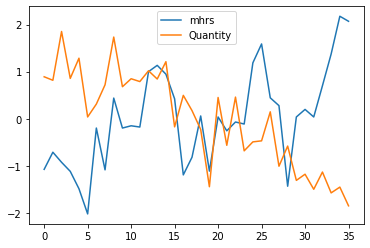

In [71]:
feature_to_compare = 'mhrs'
std_scaler = preprocessing.StandardScaler()  
temp_df = present_datasets_country['PRODUCT_B'][[feature_to_compare, 'Quantity']]
temp_df[[feature_to_compare, 'Quantity']] = std_scaler.fit_transform(temp_df[[feature_to_compare, 'Quantity']])
temp_df.plot.line()

## Feature Correlation

In [143]:
# feutures_based_on_city = ['GDP by City',
#  'life_expectancy',
#  'population',
#  'pop_growth',
#  'pop_density',
#  'pop_infants_and_toddlers',
#  '80+_male',
#  '65+_male',
#  '50+_male']

# feutures_redundant = [
#  'year_x',
#  'month',
#  'year_y']



# features_related_to_time_series = [x for x in present_df.columns if x not in feutures_based_on_city and x not in feutures_redundant]

# present_df_ist_time = present_df[present_df.Province == 'ISTANBUL'][features_related_to_time_series]

### Correlation Heat Map For Features

In [144]:
# import seaborn as sns
# for p in products:
#     fig, ax = plt.subplots(figsize=(50,50))
#     sns.heatmap(present_df_country[present_df_country.Product == p].corr(), annot=True, ax=ax, cmap='BrBG').set(title='Feature Correlation for '+p, xlabel='Columns', ylabel='Columns')
#     plt.show()

### Mutual Correlation Between Features And The Quantity Sold

In [72]:
from sklearn.feature_selection import mutual_info_regression
for p in products:
    numerical_features = present_df_country._get_numeric_data().columns
    numerical_features = [x for x in numerical_features if x not in ['Period', 'Quantity']]
    #print(numerical_features)
    mut_info_num_vars = mutual_info_regression(present_df_country[present_df_country.Product == p][numerical_features], present_df_country[present_df_country.Product == p]['Quantity'], n_neighbors=5)
    mut_info_num_vars_max_indices = np.flip(mut_info_num_vars.argsort())
    print('\n\n'+p)
    features_list_for_cr_product = []
    for i in mut_info_num_vars_max_indices:
        gap = ''
        for s in range(0,35-len(numerical_features[i])):
            gap += ' '
        print('{}:{}{}'.format(numerical_features[i], gap, mut_info_num_vars[i]))
        features_list_for_cr_product.append(numerical_features[i])
    print("\nfeatures_list_for_cr_product: {}".format(features_list_for_cr_product))



PRODUCT_A
NetSales_mioTL:                     0.738545636329361
Year:                               0.5844442175416344
year:                               0.5844442175416344
EUR/TRY_Price:                      0.5535903186705129
ilaç:                               0.5440973145893726
USD/TRY_Price:                      0.48088802137081643
SelcukEcza_BDS:                     0.42888931525336993
SelcukEcza_TAS:                     0.395897087381166
BioGaia:                            0.3920765501815735
Xatral:                             0.30079014728732245
Salofalk:                           0.29862064517915243
mw_USD:                             0.2863199788548103
üroloji randevu:                    0.2519874798854502
Vol._ECILC_std:                     0.19757769731995145
Vol._ECILC:                         0.19757769731995145
Vol._ECILC_rltv_to_BIST100:         0.19227530066411846
Yıllık Değişim ÜFE:                 0.1743136238938563
baş ağrısı:                         0.1685676059

## Selecting Most Relevant Features

### ANOVA f-value

In [22]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression


for p in products:
    cr_data = present_datasets_country[p].copy()


#     min_max_scaler = MinMaxScaler()
#     cr_data[cr_data.columns[2:]] = min_max_scaler.fit_transform(cr_data[cr_data.columns[2:]])

    X = present_datasets_country[p].drop(['Quantity'], axis = 1)
    y = present_datasets_country[p].Quantity
    
    cr_features_sorted = []
    vals = f_regression(X, y)
    arg_vals = sorted(range(len(vals[0])), key=lambda k: vals[0][k], reverse=True)
    print('\n\nproduct '+p)
    for i in arg_vals:
        print("{}: {}".format(cr_data.columns[i], vals[0][i]))
        cr_features_sorted.append(cr_data.columns[i])
    print(cr_features_sorted)
        
    print(arg_vals)
    
#     bestfeatures = SelectKBest(score_func=chi2, k=10)
#     fit = bestfeatures.fit(X,y)
#     dfscores = pd.DataFrame(fit.scores_)
#     dfcolumns = pd.DataFrame(X.columns)
#     featureScores = pd.concat([dfcolumns,dfscores],axis=1)
#     featureScores.columns = ['Specs','Score']  
#     print(featureScores.nlargest(10,'Score'))  



product PRODUCT_A
hastane randevu: 43.634228518851174
Period: 42.68081670893292
SelcukEcza_TAS: 42.560269885201286
Month: 41.86635710474445
monthly_retail_purchases_change: 41.86635710474445
Asec: 32.65916077363184
Biofenac: 29.121075537458097
year: 26.659206175030846
SelcukEcza_ADS: 25.92563068305748
USD/TRY_mov_Change%: 24.91527634338764
Vol._ECILC_std: 14.406112255349496
Price_ECILC_rltv_to_XPHARM3: 13.776123561978299
Open_ECILC_rltv_to_XPHARM3: 13.487955022510778
High_ECILC_rltv_to_XPHARM3: 12.91534417988173
Change_ECILC_rltv_to_BIST100: 11.97953806261833
mhrs: 11.891043542805928
ilaç: 10.572129308956065
salgın: 9.251811889985415
BioGaia: 9.064319185654558
Year: 8.264537956143093
Change_ECILC: 8.26453795614309
Medigard: 7.691369000858386
Open_ECILC_std: 6.7343222663258535
Open_ECILC: 6.734322266325846
üroloji randevu: 6.652684654327392
High_ECILC: 6.19873837436304
High_ECILC_std: 6.19873837436304
SelcukEcza_TPS: 6.171431899858485
Low_ECILC_rltv_to_XPHARM3: 6.112821371910922
open_

# Prediction

## Base Prediction With ARIMA

In [23]:
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error


def print_base_prediction_with_arima_by_product(product='PRODUCT_V', p=5, d=1, q=0):
    present_df_turkey = present_df_country[present_df_country.Product==product].groupby(['Period'])['Quantity'].sum().reset_index()['Quantity']
    
    X = present_df_turkey
    size = int(len(X) * 0.66)
    train, test = X[0:size], X[size:len(X)]
    test = test.reset_index(drop=True)
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=(p, d, q))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
    error = mean_squared_error(test, predictions)
    print('Test RMSE: %.3f' % math.sqrt(error))
    # plot
    pyplot.plot(test)
    pyplot.plot(predictions, color='red')
    pyplot.show()

<ipython-input-23-2df6cd92b679>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [148]:
#print_base_prediction_with_arima_by_product()

## Models

In [42]:
!pip install lazypredict

In [58]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import lazypredict
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR

In [25]:
present_df.columns[35:55]

Index(['ASACOL', 'Biofenac', 'BioGaia', 'gastroenteroloji randevu', 'Medigard',
       'mhrs', 'üroloji randevu', 'Xalfu', 'GDP by City', 'life_expectancy',
       'population', 'pop_growth', 'pop_density', 'year_x',
       'pop_infants_and_toddlers', '80+_male', '65+_male', '50+_male', 'month',
       'monthly_retail_purchases_change'],
      dtype='object')

In [73]:
present_df.pop_density = present_df.pop_density.apply(lambda x: float(str(x).replace(' ','')))
data_integrated.pop_density = data_integrated.pop_density.apply(lambda x: float(str(x).replace(' ','')))
future_df.pop_density = future_df.pop_density.apply(lambda x: float(str(x).replace(' ','')))

In [152]:
# present_df_product = {}

# for p in present_df_country.Product.unique():
#     present_df_product[p] = present_df_country[present_df_country.Product == p].drop(columns=['Product'])
    
# data_integrated_product = {}

# for p in data_integrated.Product.unique():
#     data_integrated_product[p] = data_integrated[data_integrated.Product == p].drop(columns=['Product'])

# future_df_product = {}

# for p in future_df_country.Product.unique():
#     future_df_product[p] = future_df_country[future_df_country.Product == p].drop(columns=['Product']).reset_index(drop=True)

In [74]:
def linear_regression_with_polynomial_features_test(data):
    X = data.drop(['Quantity'], axis = 1)
    y = data.Quantity
    quad = PolynomialFeatures (degree = 2)
    x_quad = quad.fit_transform(X)
    
    X_train,X_test,y_train,y_test = train_test_split(x_quad,y, random_state = 0)
    
    plr = LinearRegression().fit(X_train,y_train)
    
    y_train_pred = plr.predict(X_train)
    y_test_pred = plr.predict(X_test)
    
    print(plr.score(X_test,y_test))

In [154]:
#linear_regression_with_polynomial_features_test()

In [75]:
from statistics import mean
def mean_absolute_percentage_error(actual_values, predictions):
    if len(actual_values) != len(predictions):
        print('actual values and predicitions are not equal')
    elif len(actual_values) == 0:
        print('actual values or predicitions is empty')
        return -1.0
    percentages = []
    for a, p in zip(actual_values, predictions):
        if a != 0:
            cr_percentage = abs((a-p)/a)
            percentages.append(cr_percentage)
    return mean(percentages)
    

In [76]:
def print_RMSE_score_by_products(data_with_preds, p):
    #data_with_preds = data_with_preds[int((-1*len(data_with_preds))/4):]
    
    data_with_preds = data_with_preds[['Period','Quantity','Predictions']].groupby(['Period'])['Quantity','Predictions'].sum().reset_index()
    print("\n\n"+p)
    print(data_with_preds)
    vals = data_with_preds.Quantity
    predictions = data_with_preds.Predictions
    rmse = math.sqrt(mean_squared_error(vals, predictions))
    rmse_last_9 = math.sqrt(mean_squared_error(vals[-9:], predictions[-9:]))
    mape = mean_absolute_percentage_error(data_with_preds.Quantity.tolist()[:-9], data_with_preds.Predictions.tolist()[:-9])
    mape_last_9 = mean_absolute_percentage_error(data_with_preds.Quantity.tolist()[-9:], data_with_preds.Predictions.tolist()[-9:])
    print("\nRMSE: %.2f" % (rmse))
    print("MAPE: %.2f" % (mape))
    print("\nRMSE Validation: %.2f" % (rmse_last_9))
    print("MAPE Validation: %.2f" % (mape_last_9))
    
    #print("vals[-9:]: {}".format(vals[-9:]))
    
    
    df_series = data_with_preds
    #df_series['Period'] = df_series.Year.apply(lambda x: str(x)) + df_series.Month.apply(lambda x: str(x)) 
    df_series = df_series.set_index('Period')
    max_val = max(df_series.Quantity.max(), df_series.Predictions.max()) 
    df_series.plot(ylim=(0,max_val*1.18), title=p)
    

## Feature Selction With Boruta

In [31]:
! pip install boruta

In [77]:
from sklearn.feature_selection import *
from boruta import BorutaPy

def apply_boruta(model, X_train, Y_train):
    feat_selector = BorutaPy(model, n_estimators='auto', verbose=0, max_iter=60)
    
    boruta_fit = feat_selector.fit(X_train.values, Y_train.values)
    
    
    # check selected features - first 5 features are selected
    #print("\n\nfeat_selector.support_: {}".format(feat_selector.support_))

    # check ranking of features
    #print("\nfeat_selector.ranking_: {}".format(feat_selector.ranking_))
    
    return feat_selector.support_
    
    

In [90]:
def random_forest_regressor_test(data, future_data=None, n_estimators=160, test_size = 0.25, max_depth=None, min_samples_leaf=1, my_shuffle=False, func_shuffle=False, future=False, boruta=False):
    
    if my_shuffle:
        data = data.sample(frac=1).reset_index(drop=True)
    
    if future:
        test_size = 0.01
        data = data.append(future_data, ignore_index=True)

    
    X = data.drop(['Quantity'], axis = 1)
    y = data.Quantity
    
    X_train,X_test,y_train,y_test = train_test_split(X,y, random_state = 0,  test_size=test_size)
    
    #forest = Lasso(alpha=0.5)
    
    forest = AdaBoostRegressor(n_estimators = n_estimators)
    
    #forest = RandomForestRegressor(n_estimators = n_estimators,
    #                               criterion = 'mse',
    #                               max_depth = max_depth,
    #                               min_samples_leaf = min_samples_leaf,
    #                               random_state = 1,
    #                               n_jobs = -1)
    forest.fit(X_train,y_train)
    forest_train_pred = forest.predict(X_train)
    forest_test_pred = forest.predict(X_test)
    
    predictions = forest.predict(X)
    #print("predictions.shape: {}".format(predictions.shape))
    #print("predictions_type: {}".format(type(predictions)))
    #print("predictions: {}".format(predictions))
    #print("split shape: {}".format())
    data_with_predictions = data.copy()
    #pred_raw_df = pd.DataFrame(columns=['Predictions', 'P2'], data=predictions) 
    data_with_predictions['Predictions'] = predictions #pred_raw_df['Predictions']
    #data_with_predictions['Predictions'] = np.hsplit(predictions,2)[0].reshape(predictions.shape[0]).tolist()
    
    data_with_future_predictions = pd.DataFrame(columns=data_with_predictions.columns)

    
    
    print('RMSE train data: %.2f, RMSE test data: %.2f' % (
    math.sqrt(mean_squared_error(y_train, forest_train_pred)),
    math.sqrt(mean_squared_error(y_test, forest_test_pred))))
    print('R2 train data: %.2f, R2 test data: %.2f' % (
    r2_score(y_train, forest_train_pred),
    r2_score(y_test, forest_test_pred)))
    
    print('\n')
    
    if boruta:
        print('\nBoruta R.Forest Test')
        truth_list_for_good_features = apply_boruta(forest, X_train, y_train)
        good_features_list = [x for i,x in enumerate([y for y in data.columns if y != 'Quantity' and y != 'Period']) if truth_list_for_good_features[i]]
        print('good_features_list: {}'.format(good_features_list))
        good_features_list.append('Quantity')
        if len(good_features_list) == 0:
            good_features_list = ['Month', 'ilaç']
            
        random_forest_regressor_test(present_datasets_country[p][good_features_list], future_datasets_country[p][good_features_list], max_depth=max_depth_for_products[i], min_samples_leaf=min_samples_leaf_for_products[i], future=False)

    
    return data_with_predictions, forest

In [79]:
present_datasets_country

{'PRODUCT_A':     Period  Quantity  Month  Year  Price_ECILC  Open_ECILC  High_ECILC  \
 0   201701     12289      1  2017         0.04        0.00        0.02   
 1   201702     11583      2  2017         0.07        0.05        0.13   
 2   201703     12040      3  2017         0.17        0.07        0.13   
 3   201704     10902      4  2017         0.34        0.19        0.26   
 4   201705     12201      5  2017         0.65        0.38        0.63   
 5   201706     11453      6  2017         0.68        0.65        0.59   
 6   201707     12224      7  2017         0.70        0.73        0.58   
 7   201708     12313      8  2017         0.62        0.74        0.62   
 8   201709     14241      9  2017         0.53        0.65        0.60   
 9   201710     13246     10  2017         0.64        0.56        0.51   
 10  201711     12974     11  2017         0.49        0.69        0.59   
 11  201712     13628     12  2017         0.57        0.51        0.47   
 12  201801 

In [57]:
# AdaBoostRegressor => Product A
# SVR => Product V

In [55]:
from lazypredict.Supervised import LazyRegressor

X = present_datasets_country['PRODUCT_X'].drop(['Quantity'], axis = 1)
y = present_datasets_country['PRODUCT_X'].Quantity
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state = 0,  test_size=0.25)
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
models,predictions = reg.fit(X_train, X_test, y_train, y_test)

 74%|███████▍  | 32/43 [00:02<00:00, 12.38it/s]

RANSACRegressor model failed to execute
`min_samples` may not be larger than number of samples: n_samples = 27.


 95%|█████████▌| 41/43 [00:03<00:00, 13.72it/s]

StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'


100%|██████████| 43/43 [00:03<00:00, 12.12it/s]


In [56]:
models

,R-Squared,RMSE,Time Taken
Model,,,
RandomForestRegressor,0.05,3336.12,0.34
BaggingRegressor,0.05,3347.28,0.08
XGBRegressor,0.00,3424.64,0.09
LGBMRegressor,-0.10,3603.42,0.05
HistGradientBoostingRegressor,-0.10,3603.42,0.09
DummyRegressor,-0.10,3603.42,0.03
LassoLarsIC,-0.10,3603.42,0.06
SVR,-0.11,3616.31,0.03
AdaBoostRegressor,-0.21,3775.98,0.16


In [159]:
#linear_regression_test()

In [160]:
# for p in products:
#     data_with_predictions = random_forest_regressor_test(present_df_product[p])

In [92]:
# present_df_product
# data_integrated_product
# future_df_product
max_depth_for_products = [3, 3, 3, 4, 4]
min_samples_leaf_for_products = [3, 3, 3, 3, 3]
apply_boruta_for_products = [True, True, True, False, True]
product_forests = {}
for i,p in enumerate(products):                         #   apply_boruta_for_products[i]
        print("\n\n"+p+":")
        data_with_predictions ,data_with_future_predictions, forest = random_forest_regressor_test(present_datasets_country[p], future_datasets_country[p], max_depth=max_depth_for_products[i], min_samples_leaf=min_samples_leaf_for_products[i], future=True, boruta=False)
        product_forests[p] = forest
        # , data_with_future_predictions
        print_RMSE_score_by_products(data_with_predictions, p)
        #print("\nFUTURE > "+p)
        print_RMSE_score_by_products(data_with_future_predictions, p)



PRODUCT_A:
RMSE train data: 776.78, RMSE test data: 2033.90
R2 train data: 0.99, R2 test data: nan




ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
max_depth_for_products = [3, 3, 3, 4, 4]
min_samples_leaf_for_products = [3, 3, 3, 3, 3]
apply_boruta_for_products = [True, True, True, False, True]
product_forests = {}
for i,p in enumerate(products):                         #   apply_boruta_for_products[i]
        print("\n\n"+p+":")
        data_with_predictions ,forest = random_forest_regressor_test(present_datasets_country[p], future_datasets_country[p], max_depth=max_depth_for_products[i], min_samples_leaf=min_samples_leaf_for_products[i], future=True, boruta=apply_boruta_for_products[i])
        product_forests[p] = forest
        # , data_with_future_predictions
        print_RMSE_score_by_products(data_with_predictions, p)
        #print("\nFUTURE > "+p)
        print_RMSE_score_by_products(data_with_future_predictions, p)

## Parameter Tuning via Random Search CV

We at first considered to implement Grid Search CV. However, in order to be able to get the benefit from the time complexity of Random Search CV, we eventually decided on it.

{'n_estimators': [80, 293, 506, 720, 933, 1146, 1360, 1573, 1786, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, None], 'min_samples_split': [2, 3, 4, 5, 10], 'min_samples_leaf': [1, 2, 3, 4], 'bootstrap': [True, False]}


PRODUCT: PRODUCT_A
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   51.3s finished


Model Performance
Average Error: 1948.9667 degrees.
Accuracy = 87.84%.


PRODUCT_A
   Period  Quantity  Predictions
0  201904     17097      17281.7
1  201905     24023      17391.4
2  201906     16170      19306.6
3  201907     22815      19061.0
4  201908     19614      17035.3
5  201909     14322      14171.9
6  201910     25781      15268.9
7  201911     18540      12486.2
8  201912     19367      14364.9
actual values or predicitions is empty

RMSE: 5236.51
MAPE: -1.00

RMSE Validation: 5236.51
MAPE Validation: 0.20
Model Performance
Average Error: 1067.9060 degrees.
Accuracy = 93.44%.


PRODUCT_A
   Period  Quantity   Predictions
0  201904     17097  18870.933790
1  201905     24023  17073.815049
2  201906     16170  15907.248556
3  201907     22815  19759.701548
4  201908     19614  16024.446984
5  201909     14322  14317.181934
6  201910     25781  13942.349368
7  201911     18540  12480.486371
8  201912     19367  14002.891223
actual values or predicitions is empty

RMSE: 5571

/home/a/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/a/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.
/home/a/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/a/anaconda3/lib/python3.7/site-package

Model Performance
Average Error: 20501.4889 degrees.
Accuracy = 83.10%.


PRODUCT_B
   Period  Quantity  Predictions
0  201904     81397      77183.7
1  201905     97437      87329.5
2  201906     70122     131464.3
3  201907     75025      84465.8
4  201908     63026     104996.5
5  201909     76752     148605.1
6  201910     60157     141176.5
7  201911     64761     160537.3
8  201912     49862     148436.1
actual values or predicitions is empty

RMSE: 63552.62
MAPE: -1.00

RMSE Validation: 63552.62
MAPE Validation: 0.84


/home/a/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/a/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


Model Performance
Average Error: 21914.5441 degrees.
Accuracy = 82.11%.


PRODUCT_B
   Period  Quantity    Predictions
0  201904     81397   79573.740792
1  201905     97437   94409.568275
2  201906     70122  139863.985054
3  201907     75025   85088.759268
4  201908     63026   98258.244359
5  201909     76752  148039.248775
6  201910     60157  139177.027857
7  201911     64761  147548.463114
8  201912     49862  149145.466856
actual values or predicitions is empty

RMSE: 61694.62
MAPE: -1.00

RMSE Validation: 61694.62
MAPE Validation: 0.81
Improvement of -1.19%.

best random model parameters: {'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 2, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1360, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

/home/a/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/a/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.2min finished


Model Performance
Average Error: 1777.0444 degrees.
Accuracy = 96.43%.


PRODUCT_C
   Period  Quantity  Predictions
0  201904     43463      53226.0
1  201905     47654      55821.6
2  201906     40868      51074.5
3  201907     47800      48530.0
4  201908     49944      54749.0
5  201909     59116      52518.6
6  201910     52651      54320.1
7  201911     57790      48653.4
8  201912     55986      56579.6
actual values or predicitions is empty

RMSE: 6830.98
MAPE: -1.00

RMSE Validation: 6830.98
MAPE Validation: 0.12
Model Performance
Average Error: 1362.3289 degrees.
Accuracy = 97.32%.


PRODUCT_C
   Period  Quantity   Predictions
0  201904     43463  50458.102068
1  201905     47654  57870.306197
2  201906     40868  51207.370234
3  201907     47800  49159.041136
4  201908     49944  57173.414341
5  201909     59116  50627.224785
6  201910     52651  55323.980799
7  201911     57790  47530.099545
8  201912     55986  56705.161640
actual values or predicitions is empty

RMSE: 7448

/home/a/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/a/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.
/home/a/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/a/anaconda3/lib/python3.7/site-package

Model Performance
Average Error: 4615.0222 degrees.
Accuracy = 3.29%.


PRODUCT_V
   Period  Quantity  Predictions
0  201904      5883       6690.4
1  201905      7562      12223.7
2  201906      6370      13887.6
3  201907      2716      11310.6
4  201908      2102       6452.8
5  201909     12211      12566.7
6  201910      9364       9428.9
7  201911      8071       9325.3
8  201912      5048      10592.6
actual values or predicitions is empty

RMSE: 4762.60
MAPE: -1.00

RMSE Validation: 4762.60
MAPE Validation: 0.94
Model Performance
Average Error: 4005.8436 degrees.
Accuracy = 7.17%.


PRODUCT_V
   Period  Quantity   Predictions
0  201904      5883   8267.434741
1  201905      7562   8082.161414
2  201906      6370  10625.244633
3  201907      2716  10540.696620
4  201908      2102   7071.049515
5  201909     12211  12723.925525
6  201910      9364   9172.772090
7  201911      8071   9176.208021
8  201912      5048  10244.383295
actual values or predicitions is empty

RMSE: 3922.9

/home/a/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/a/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.
/home/a/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/a/anaconda3/lib/python3.7/site-package

Model Performance
Average Error: 2314.9222 degrees.
Accuracy = 84.27%.


PRODUCT_X
   Period  Quantity  Predictions
0  201904     23944      15512.3
1  201905     23790      21121.1
2  201906     17647      21366.0
3  201907     21151      17257.1
4  201908      9390      22069.8
5  201909       985      19037.7
6  201910     24762      21009.4
7  201911     20978      19073.8
8  201912     24368      20515.1
actual values or predicitions is empty

RMSE: 8342.93
MAPE: -1.00

RMSE Validation: 8342.93
MAPE Validation: 2.33
Model Performance
Average Error: 2322.0895 degrees.
Accuracy = 81.74%.


PRODUCT_X
   Period  Quantity   Predictions
0  201904     23944  19795.570969
1  201905     23790  19675.591171
2  201906     17647  19689.007148
3  201907     21151  20274.305427
4  201908      9390  20220.969375
5  201909       985  18244.437604
6  201910     24762  18772.783039
7  201911     20978  18436.971077
8  201912     24368  18555.821834
actual values or predicitions is empty

RMSE: 7676

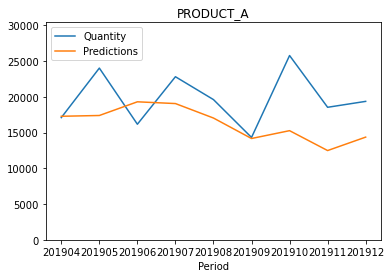

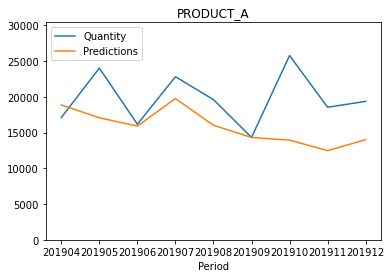

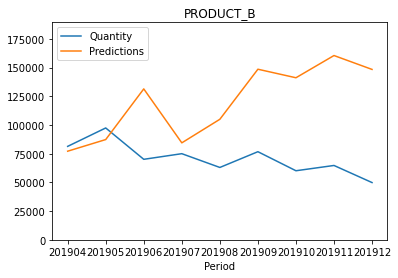

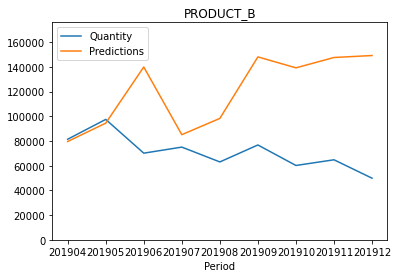

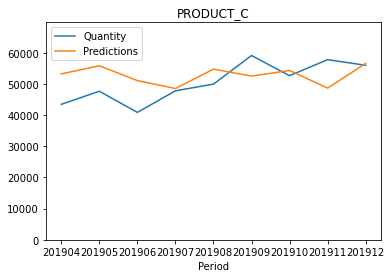

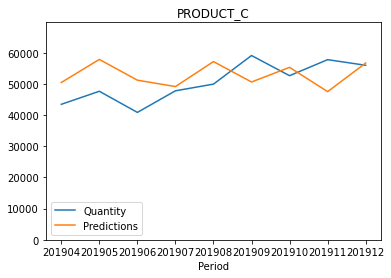

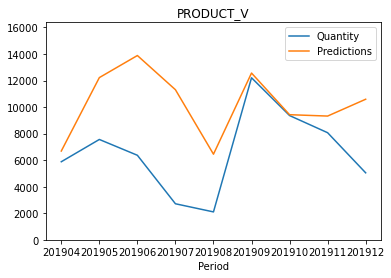

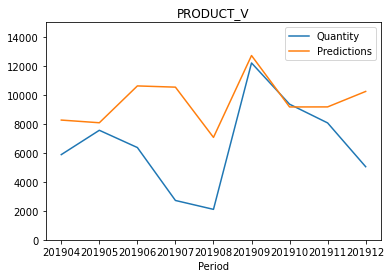

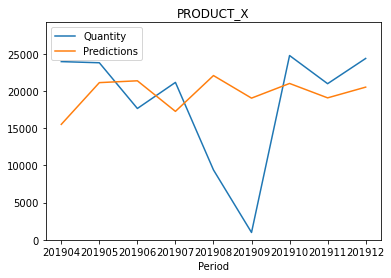

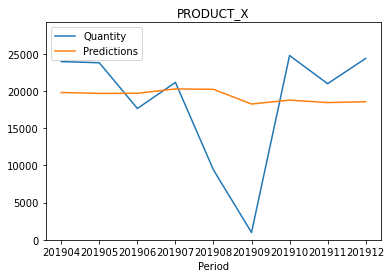

In [162]:
from sklearn.model_selection import RandomizedSearchCV



# Number of trees in the ensamble
n_estimators = [int(x) for x in np.linspace(start = 80, stop = 2000, num = 10)]
# MAX FEATURES to be utilized in every split
max_features = ['auto', 'sqrt']
# DEPTH of Tree
max_depth = [int(x) for x in np.linspace(2, 20, num = 1)]
max_depth.append(None)
# Minimum nymber of samples to use to form a node
min_samples_split = [2, 3, 4, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)


def evaluate(model, test_features, test_labels, p, data):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    data_with_predictions = data[-1*y_test.shape[0]:]
    data_with_predictions['Predictions'] = predictions
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    print_RMSE_score_by_products(data_with_predictions, p)
    
    return accuracy

for p in products:
    data = present_datasets_country[p]
    X = data.drop(['Quantity'], axis = 1)
    y = data.Quantity

    X_train,X_test,y_train,y_test = train_test_split(X,y, random_state = 0,  test_size=0.25)

    print("\n\nPRODUCT: {}".format(p))

    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestRegressor()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
    rf_random.fit(X_train, y_train)
    
    
    base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
    base_model.fit(X_train, y_train)
    base_accuracy = evaluate(base_model, X_test, y_test, p, data)
    
    best_random = rf_random.best_estimator_
    random_accuracy = evaluate(best_random, X_test, y_test, p, data)
    
    print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))
    
    print("\nbest random model parameters: {}".format(best_random.get_params()))

## Visualizing The Decision Tree Samples In our Random Forest Regressor

PRODUCT_A


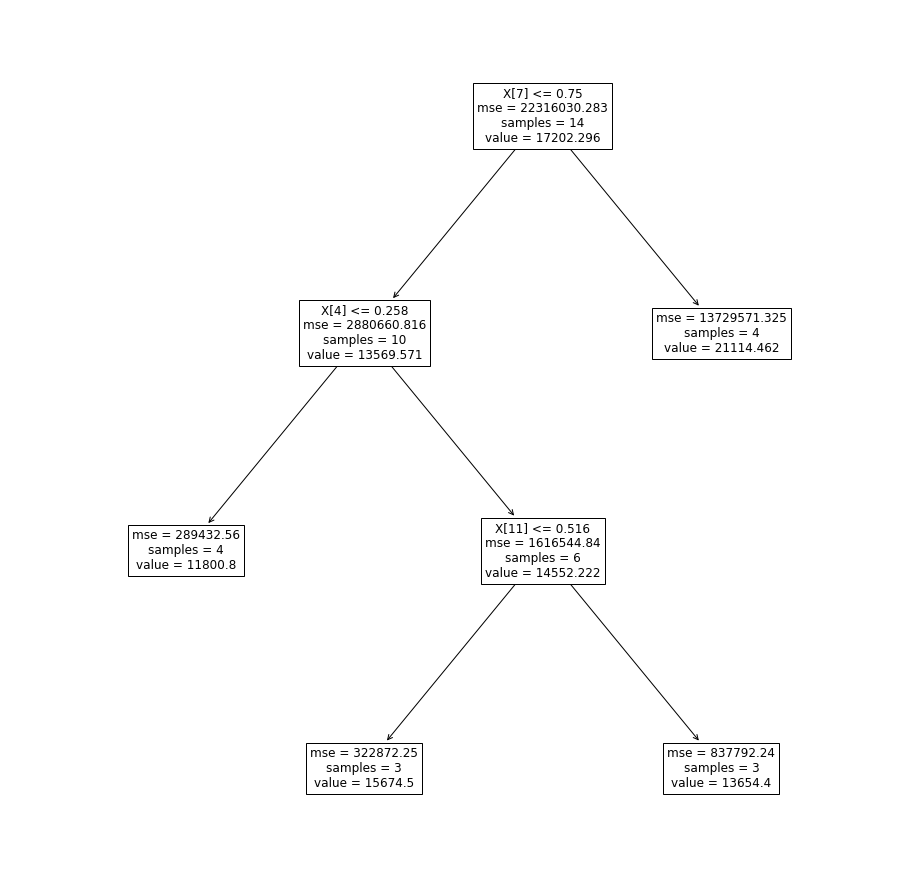

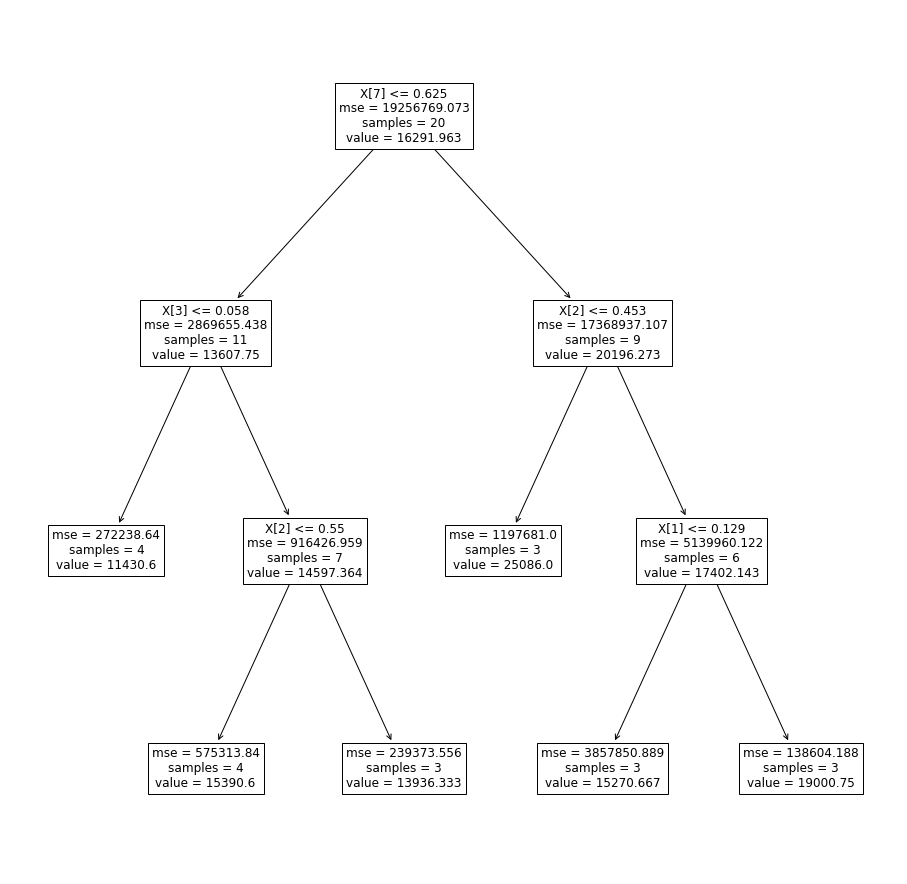

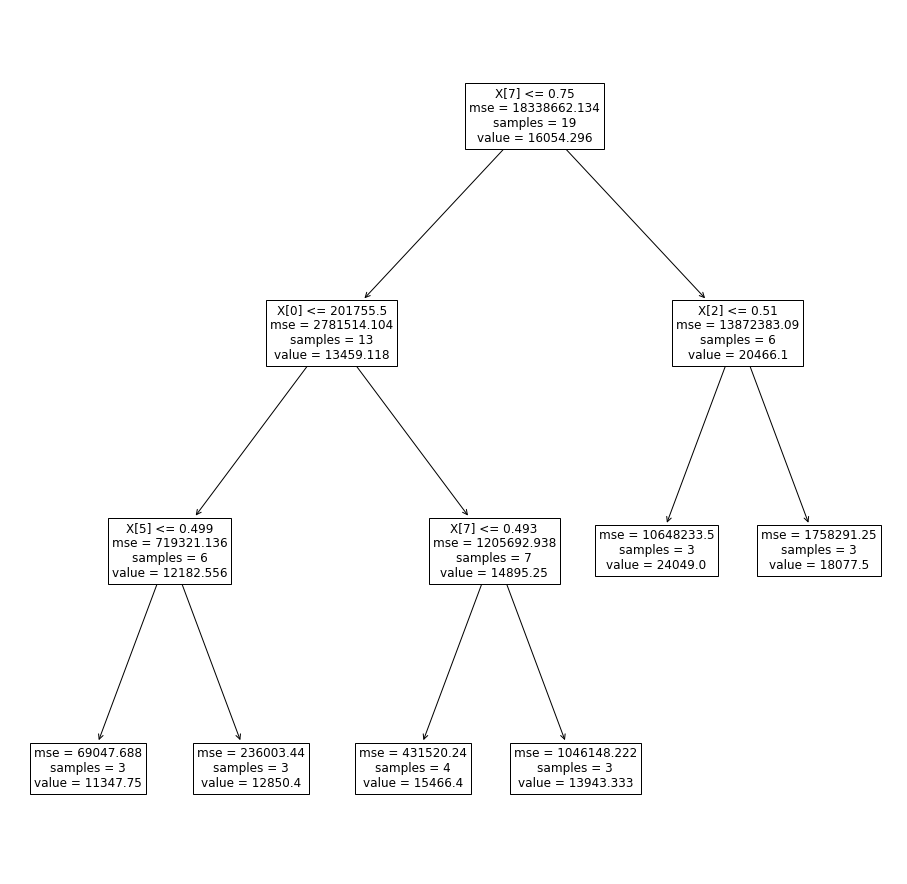

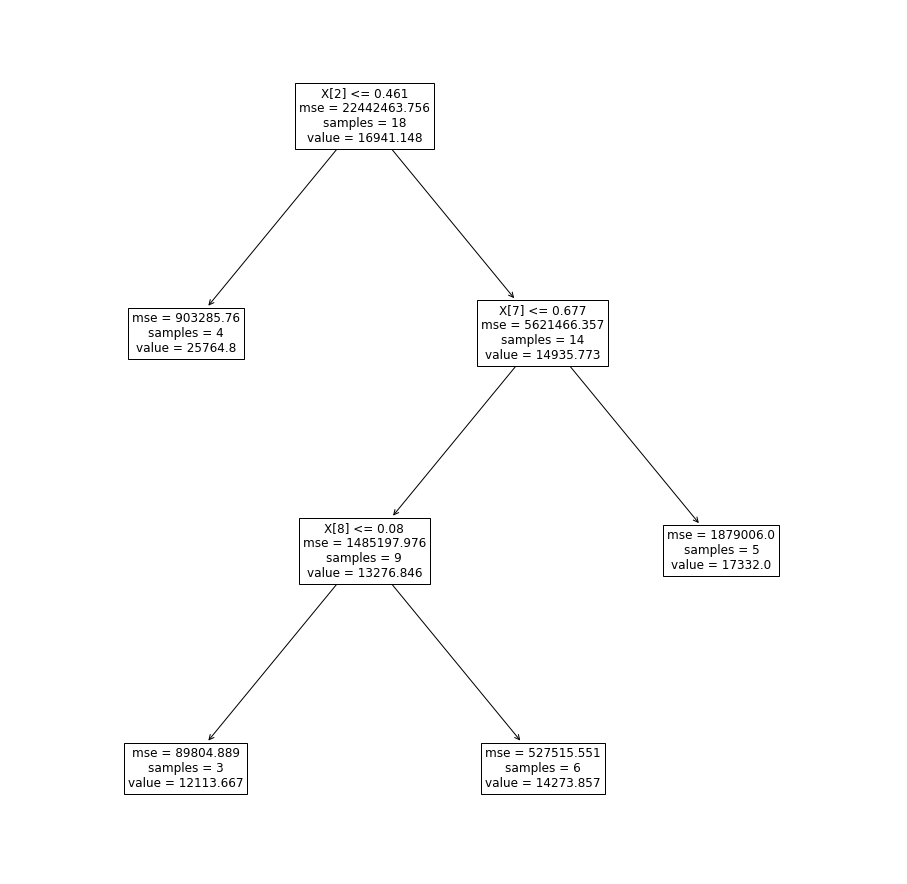

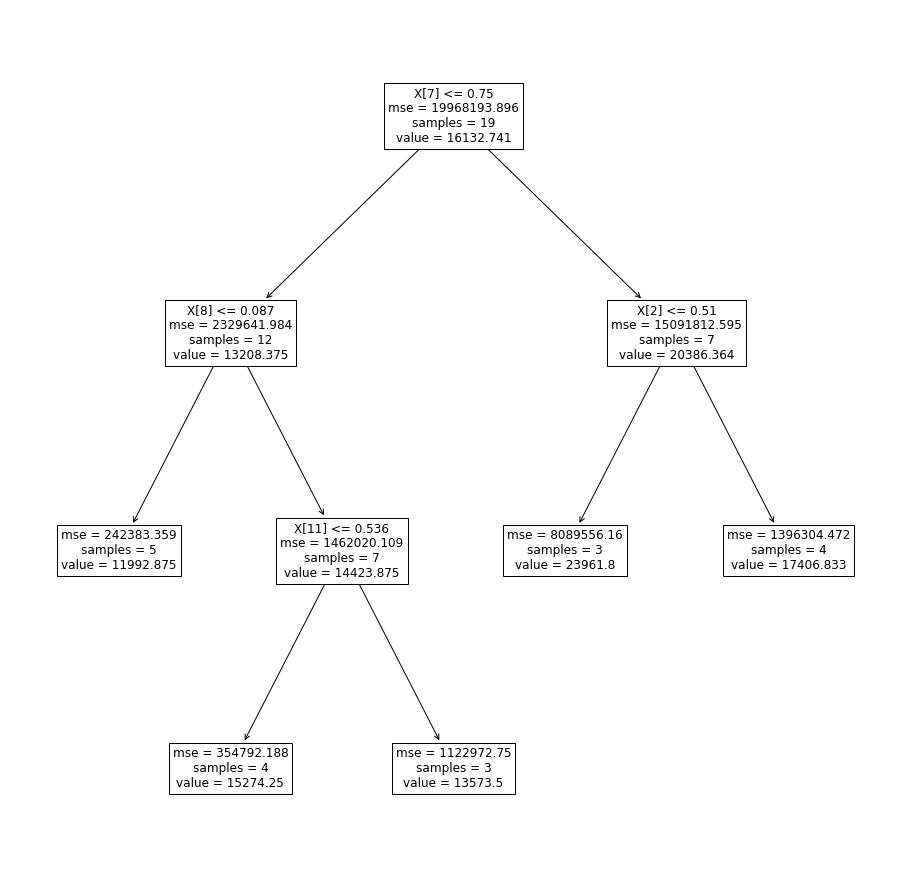

PRODUCT_B


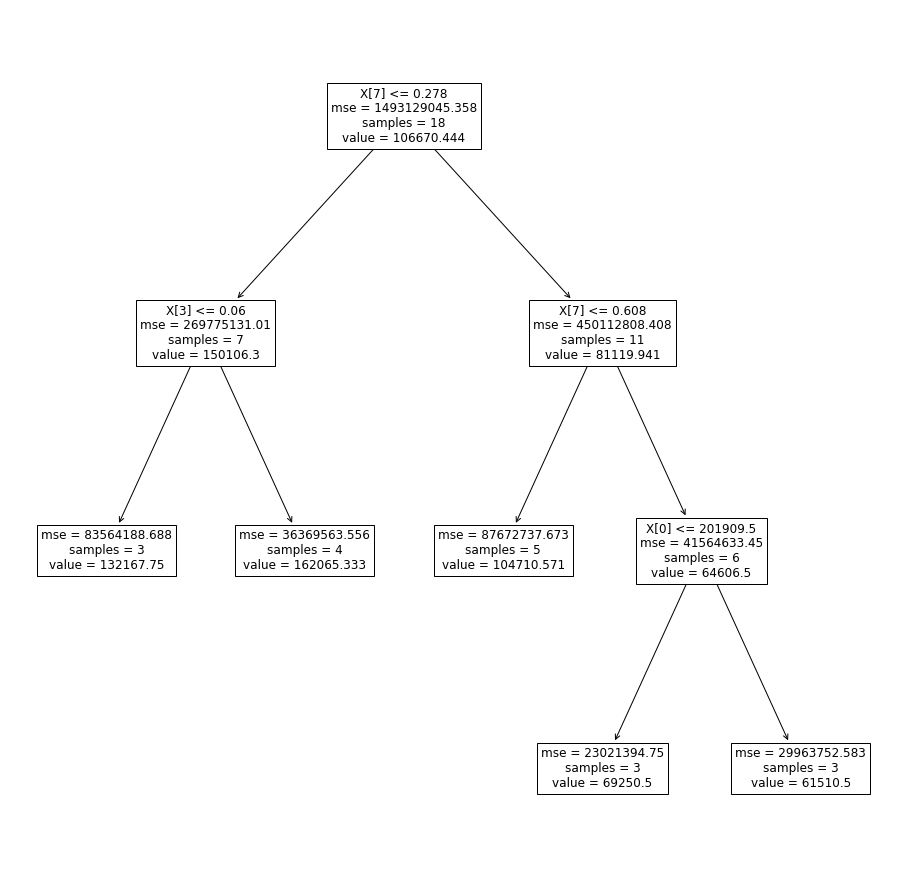

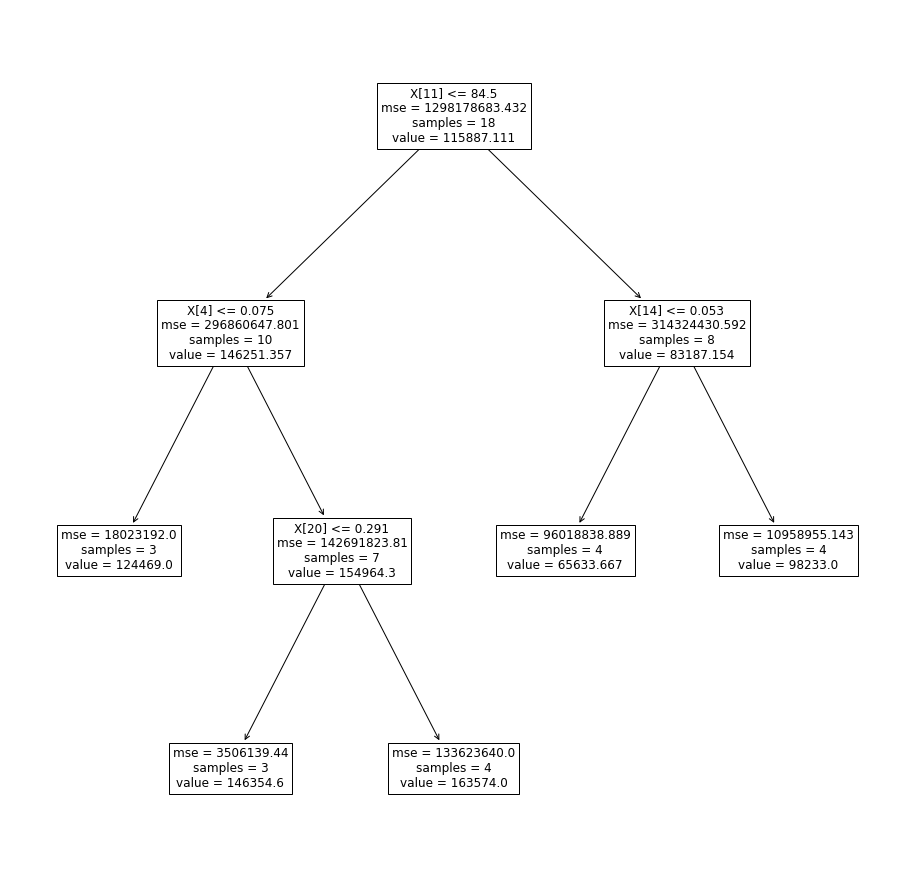

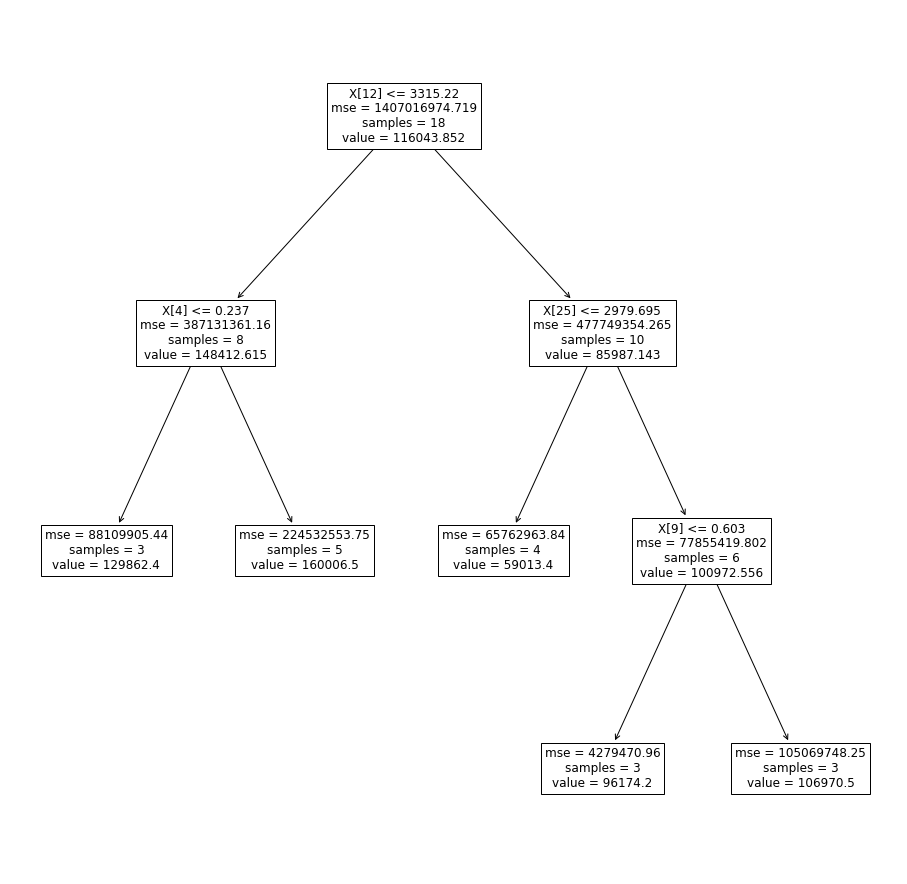

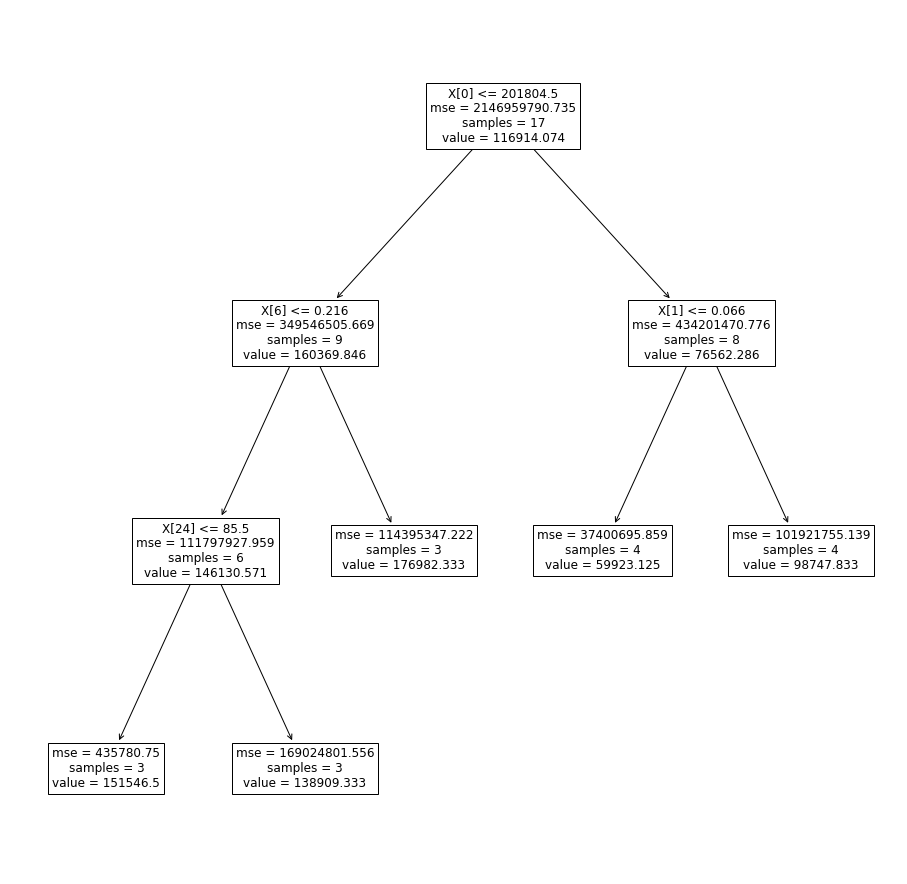

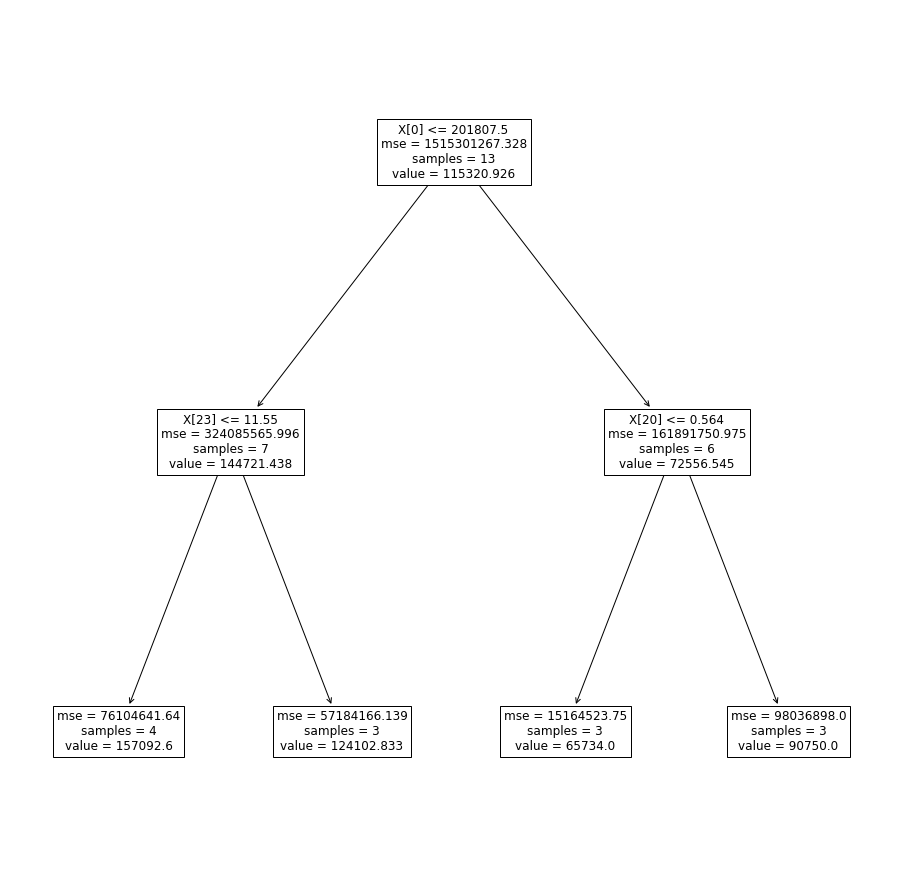

PRODUCT_C


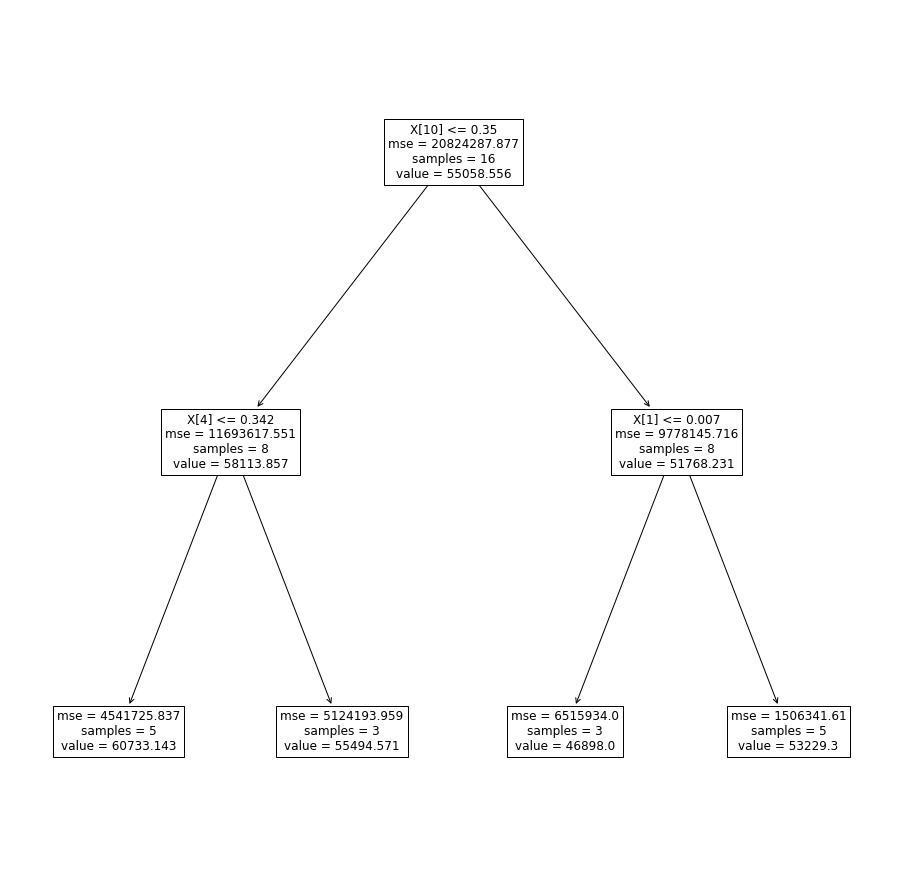

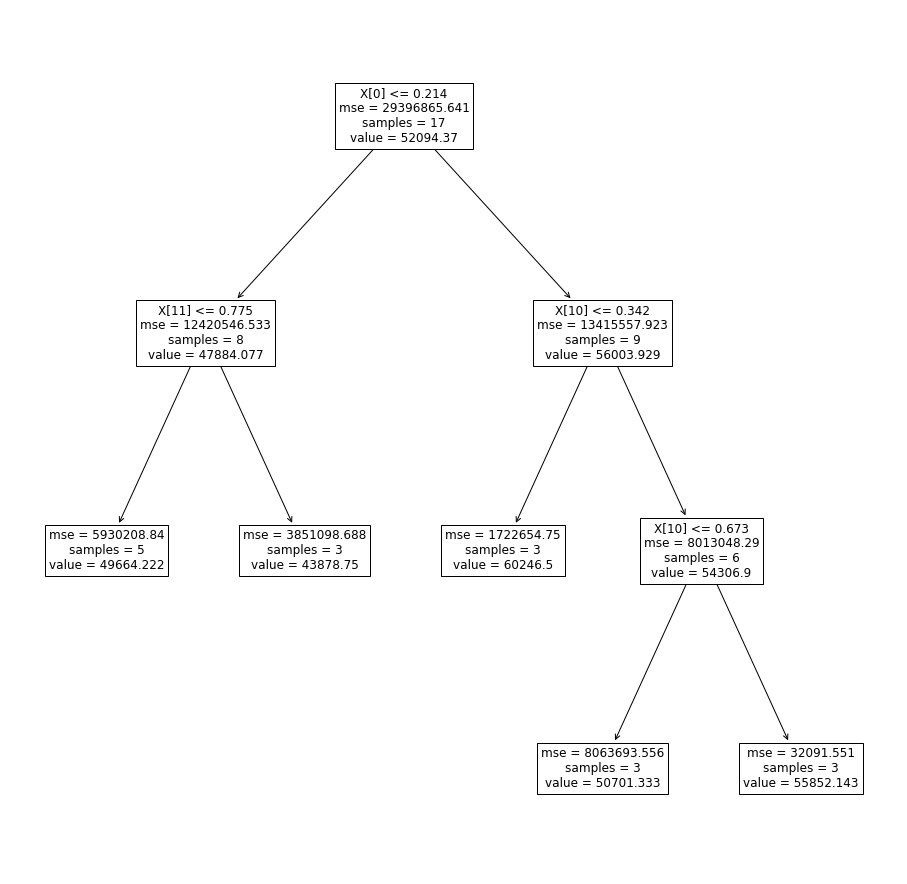

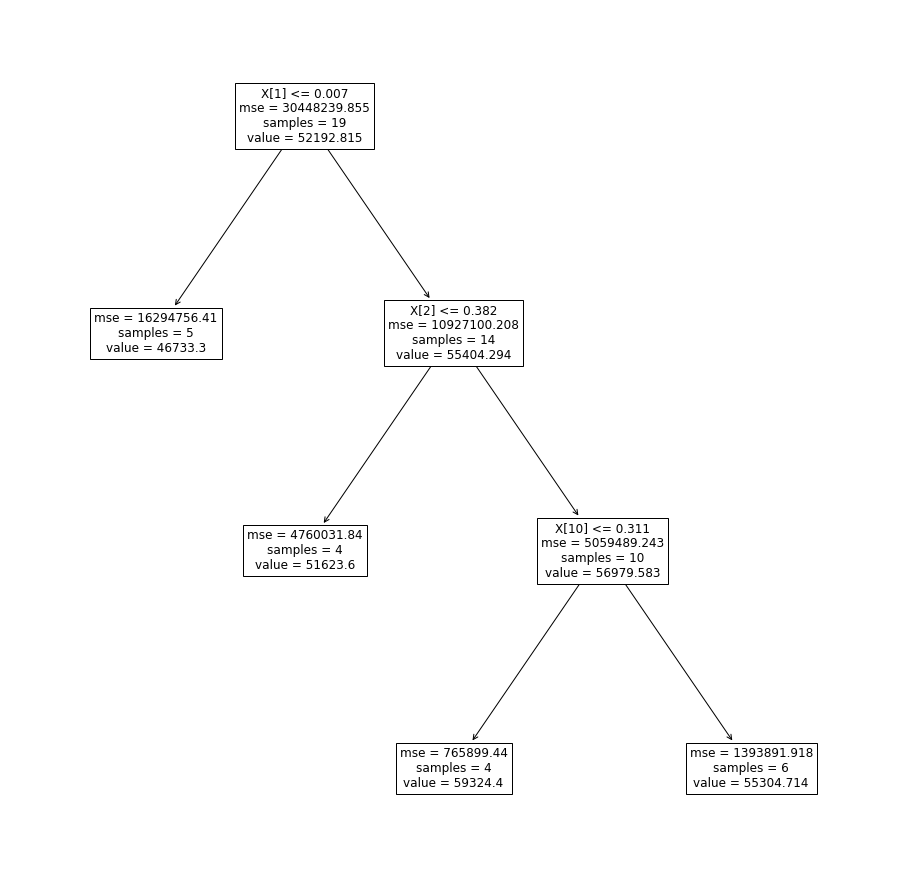

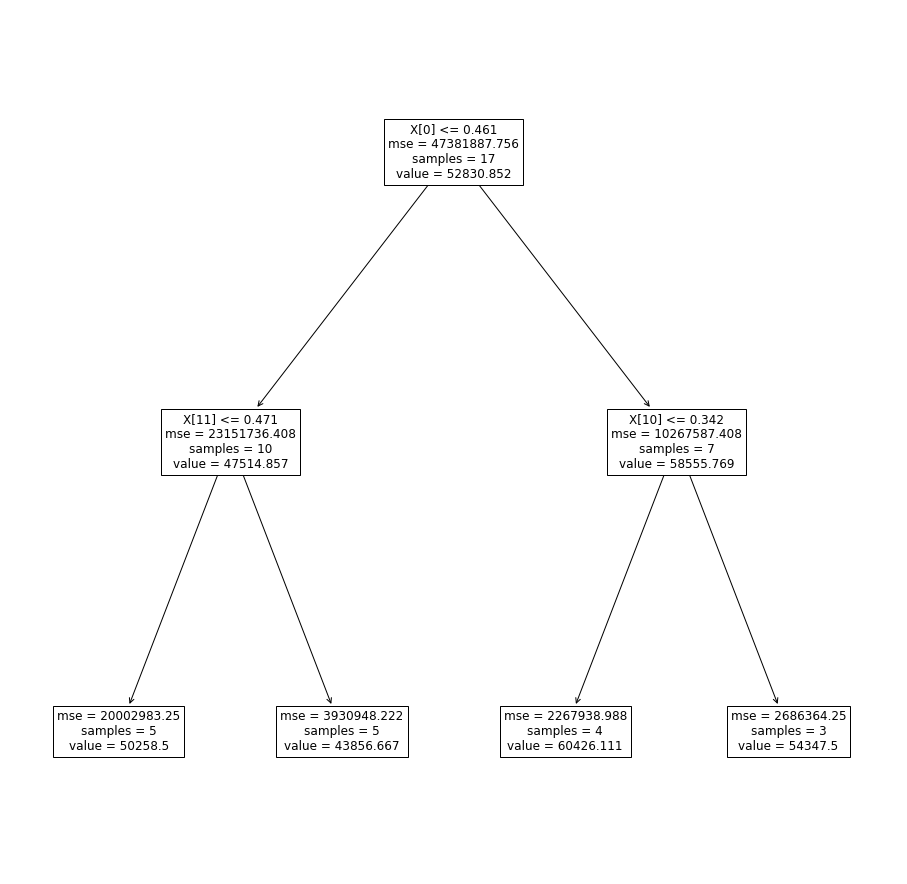

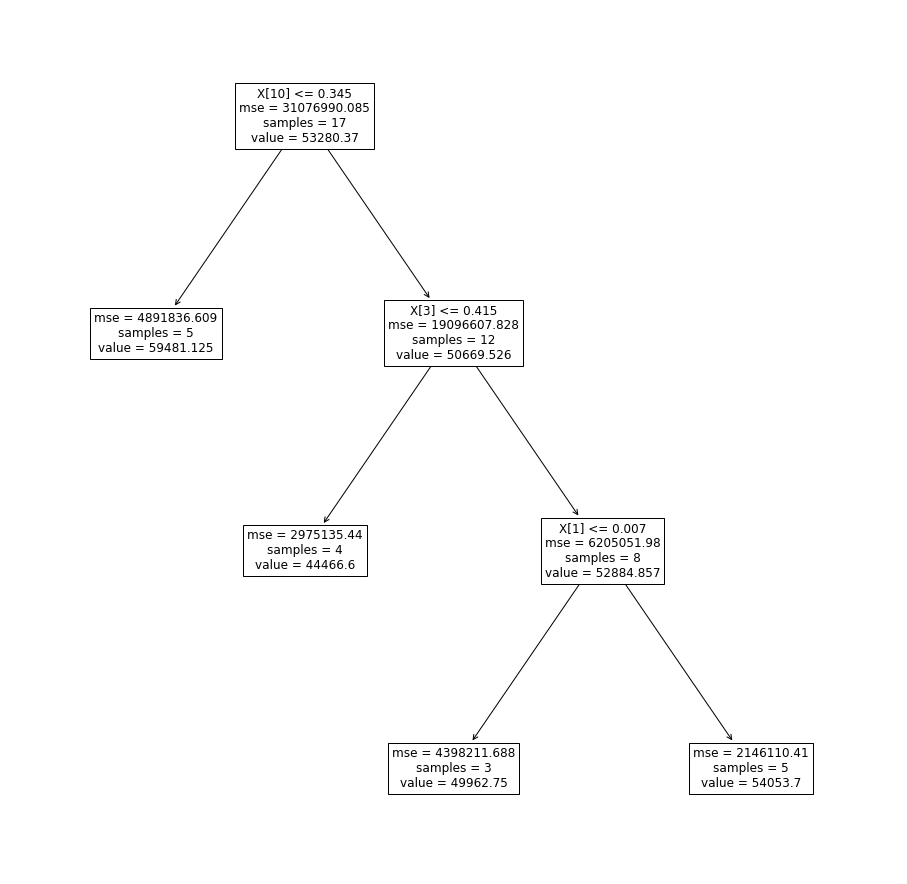

PRODUCT_V


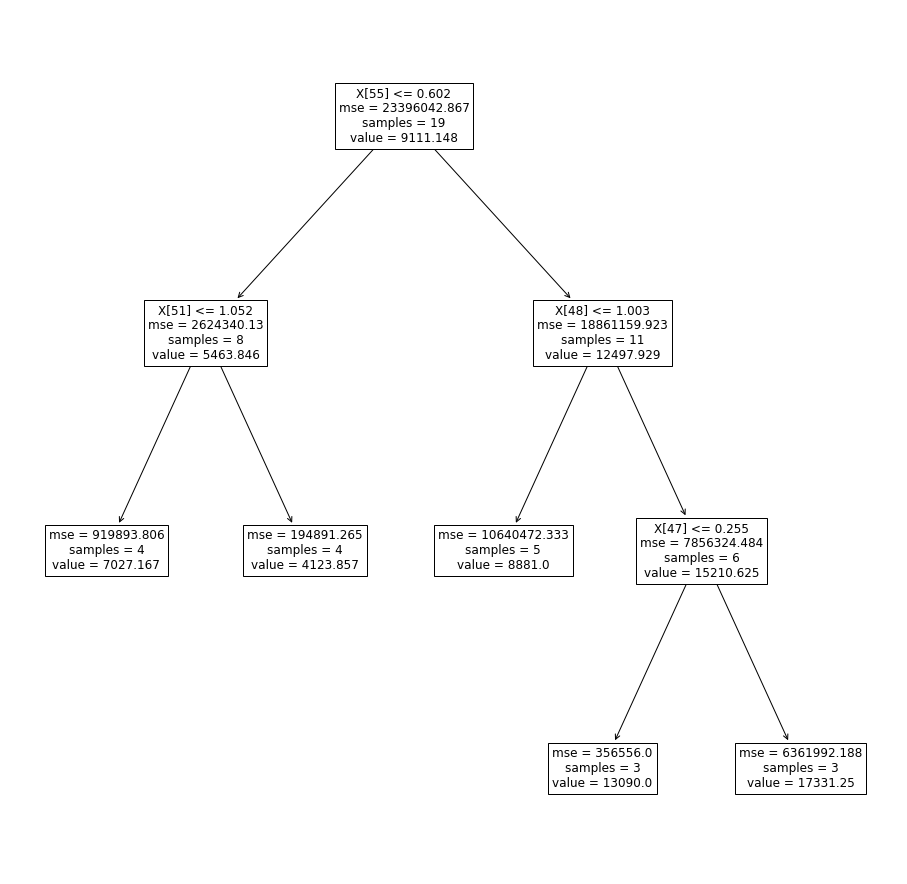

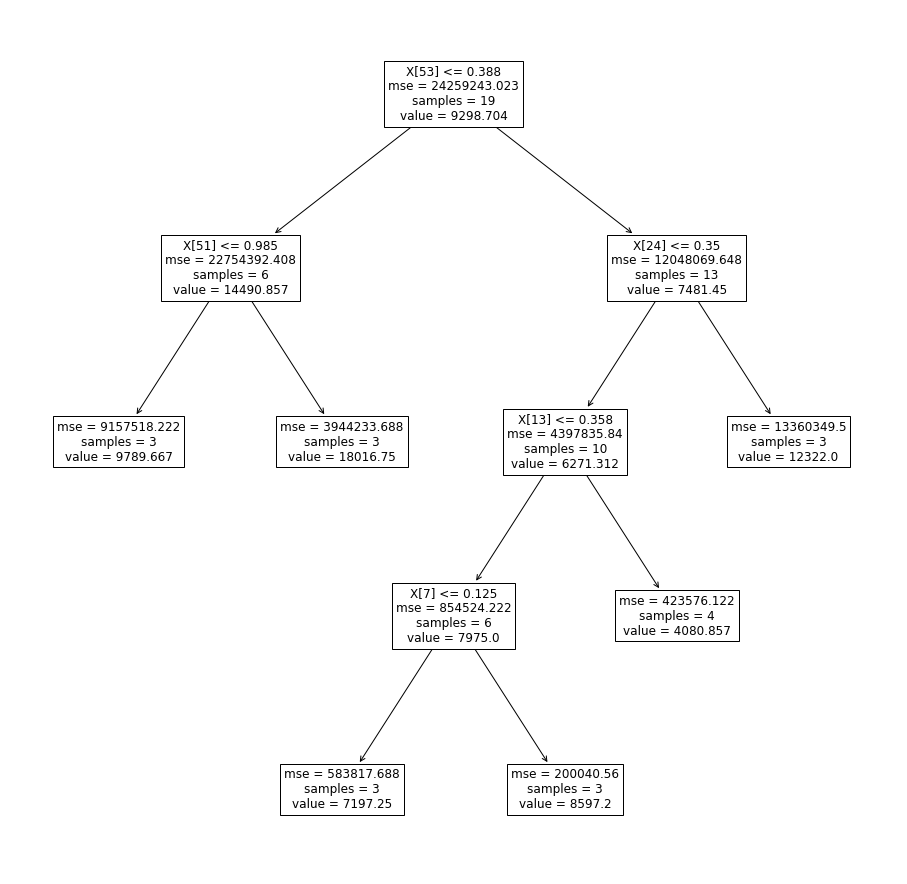

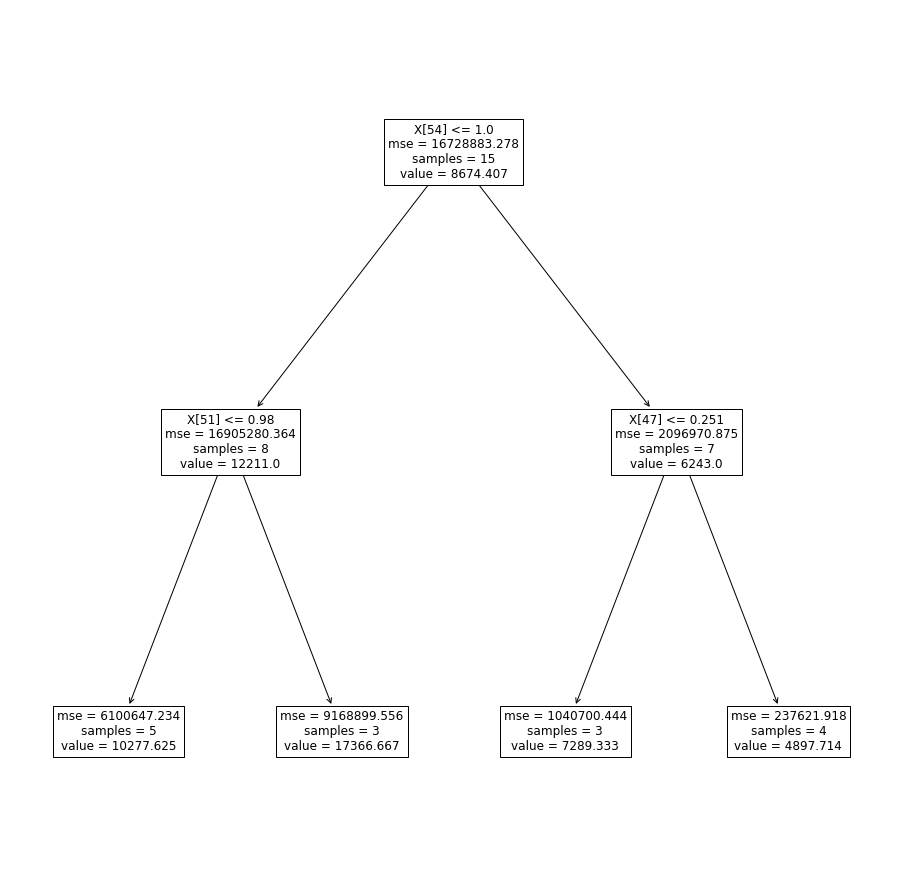

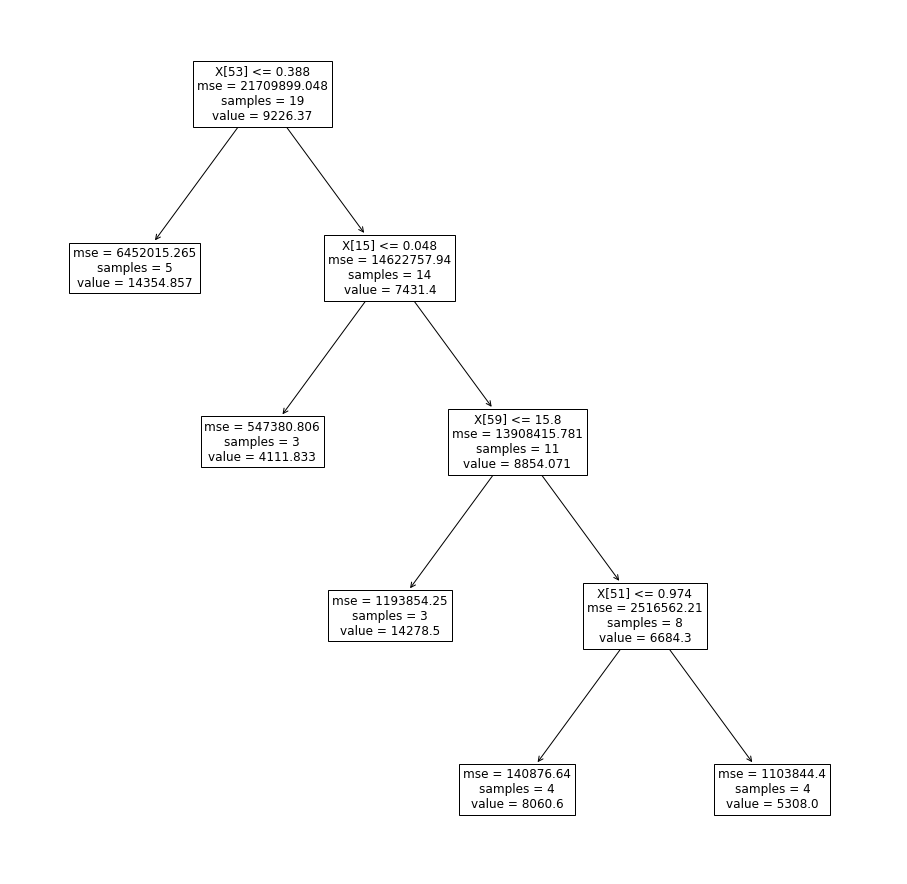

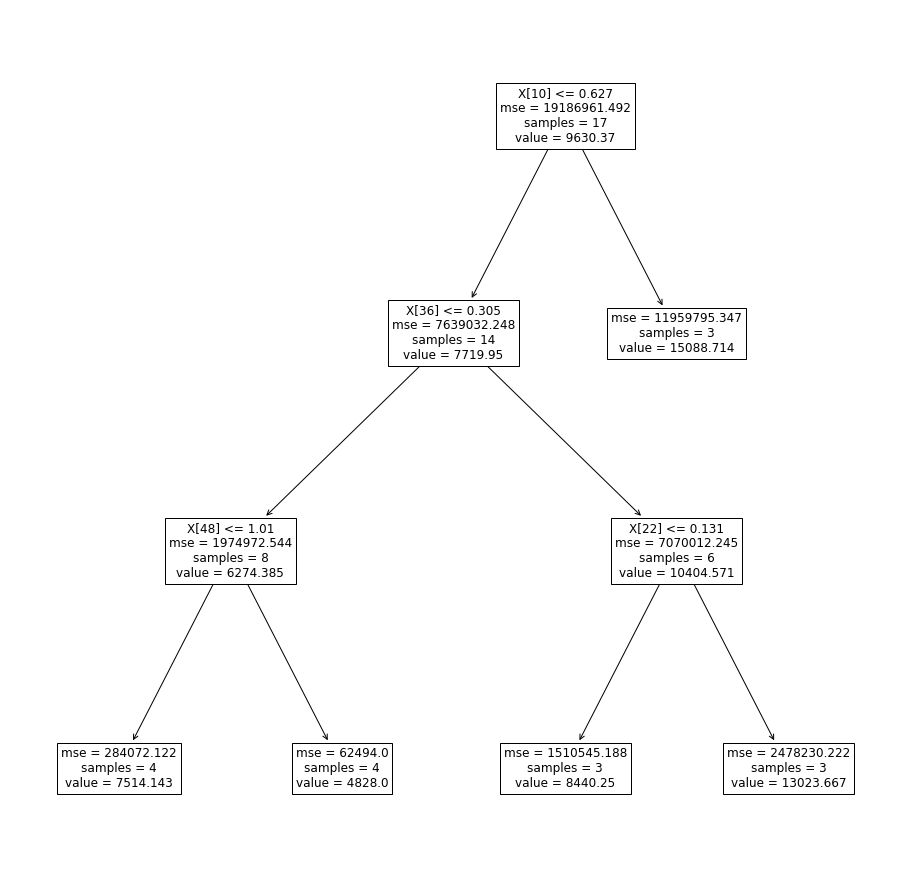

PRODUCT_X


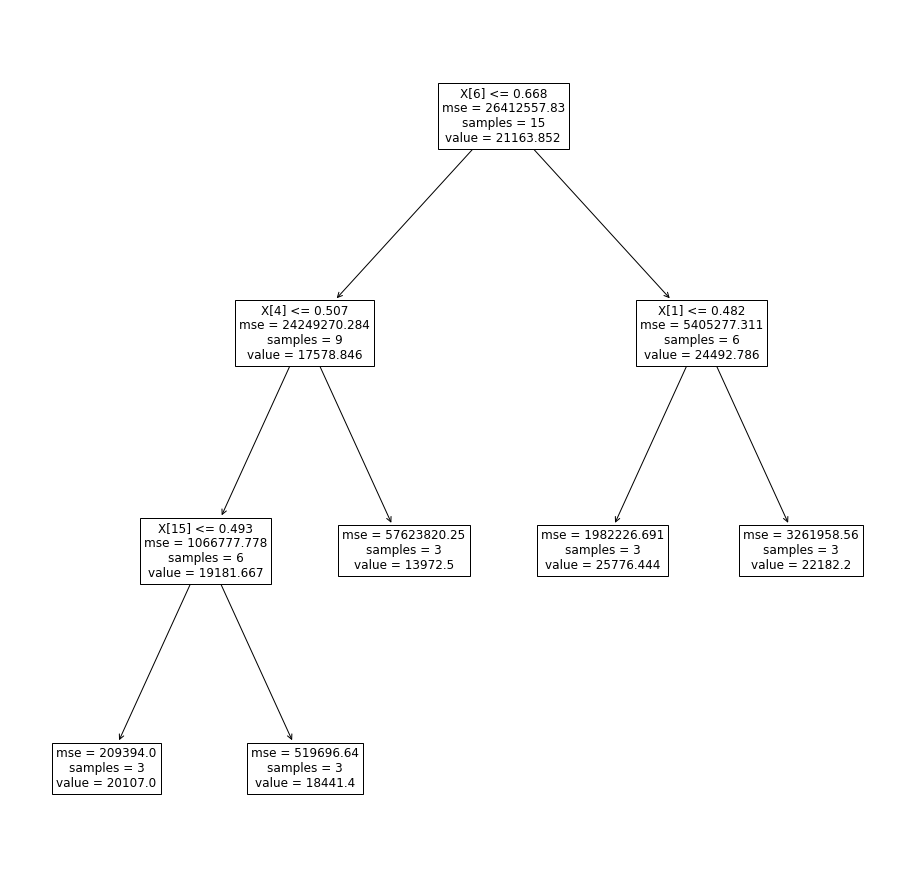

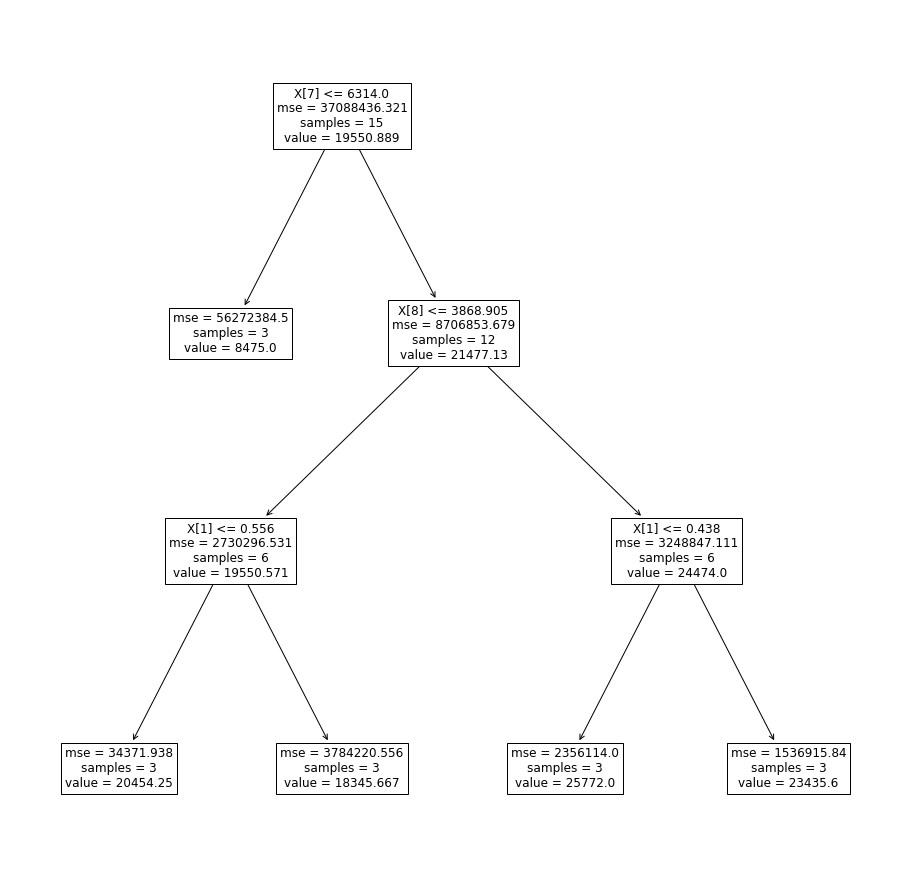

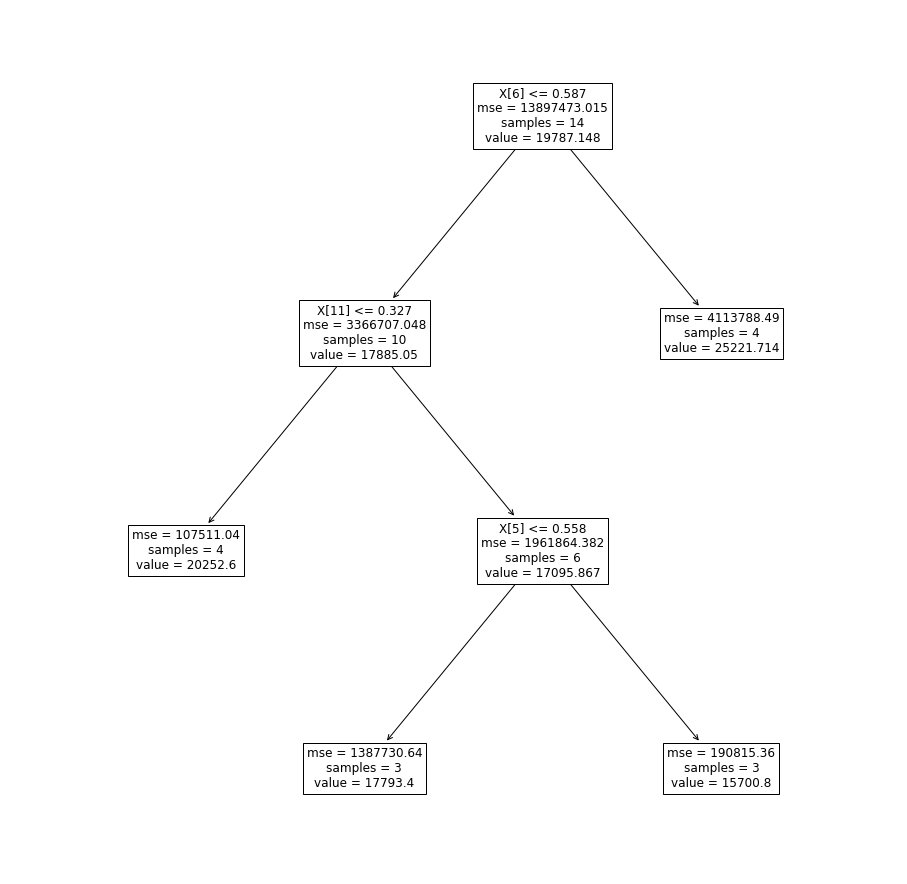

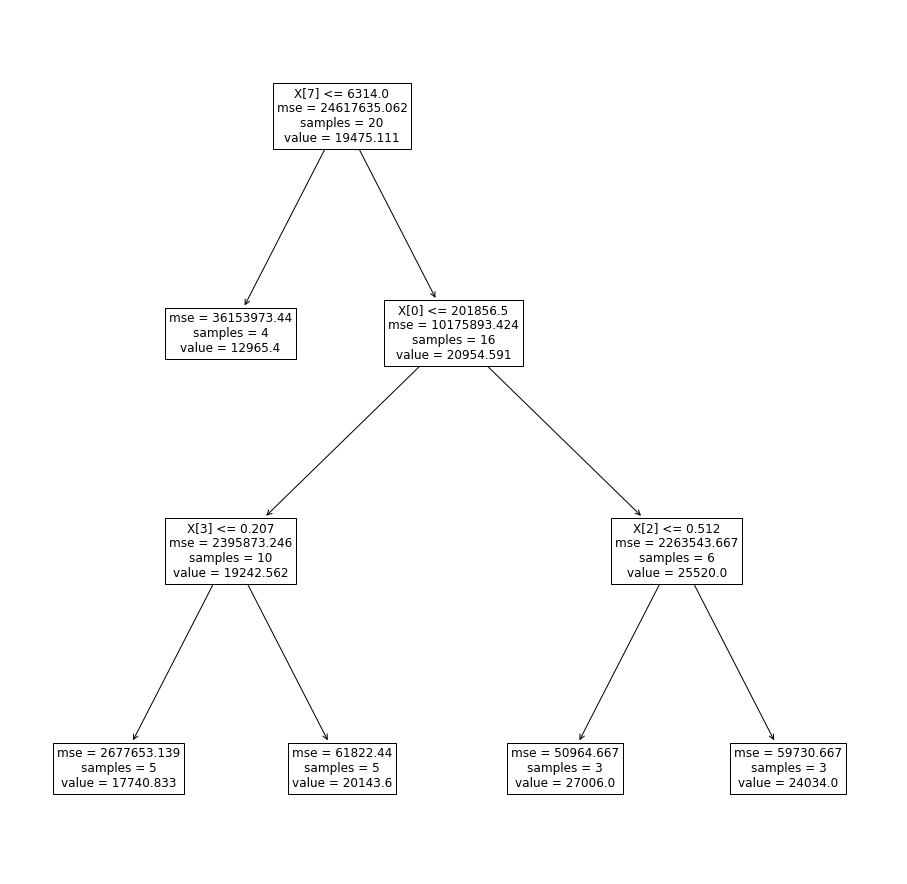

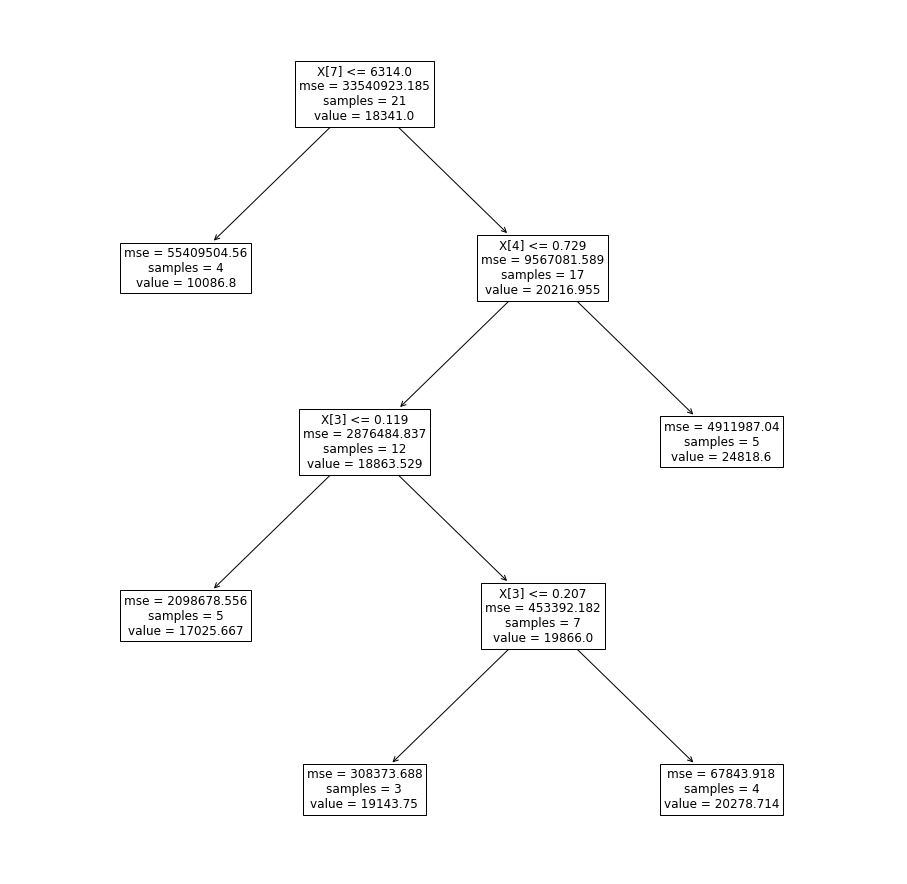

In [163]:
# (please look at reference #27)
from sklearn import tree
from sklearn.tree import export_graphviz
for p in products:
    print(p)
    for i in range(5):
        fig, ax = plt.subplots(figsize=(16, 16))
        tree.plot_tree(product_forests[p].estimators_[i], fontsize=12)
        plt.show()

In [164]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.linear_model import BayesianRidge, LinearRegression

def do_it(data):
# #############################################################################
    
    X = data.drop(['Quantity'], axis = 1)
    y = data.Quantity
    
    X_train,X_test,y_train,y_test = train_test_split(X,y, random_state = 0, test_size=0.25)
    br = BayesianRidge().fit(X_train,y_train)
    
    y_train_pred = br.predict(X_train)
    y_test_pred = br.predict(X_test)
    
    print(br.score(X_test,y_test))
    
    graph_df = pd.DataFrame(data=data['Period'][-9,:], columns=['Period'])
    graph_df['Value'] = y_test
    graph_df['Predictions'] = y_test_pred
    graph_df = graph_df.set_index('Period')
    graph_df.plot()

# # #############################################################################
# # Fit the Bayesian Ridge Regression and an OLS for comparison
# clf = BayesianRidge(compute_score=True)
# clf.fit(X, y)

# clf_predict = reg.predict([[1, 0.]])


# ols = LinearRegression()
# ols.fit(X, y)


# # Plotting some predictions for polynomial regression
# def f(x, noise_amount):
#     y = np.sqrt(x) * np.sin(x)
#     noise = np.random.normal(0, 1, len(x))
#     return y + noise_amount * noise


# degree = 10
# X = np.linspace(0, 10, 100)
# y = f(X, noise_amount=0.1)
# clf_poly = BayesianRidge()
# clf_poly.fit(np.vander(X, degree), y)

# X_plot = np.linspace(0, 11, 25)
# y_plot = f(X_plot, noise_amount=0)
# y_mean, y_std = clf_poly.predict(np.vander(X_plot, degree), return_std=True)
# plt.figure(figsize=(6, 5))
# plt.errorbar(X_plot, y_mean, y_std, color='navy',
#              label="Polynomial Bayesian Ridge Regression", linewidth=lw)
# plt.plot(X_plot, y_plot, color='gold', linewidth=lw,
#          label="Ground Truth")
# plt.ylabel("Output y")
# plt.xlabel("Feature X")
# plt.legend(loc="lower left")
# plt.show()

In [165]:
do_it(present_datasets_country[p])

-0.3710549680051074


ValueError: Can only tuple-index with a MultiIndex

## LSTM

In [ ]:
import keras
import tensorflow as tf
#from keras.layers import Dense
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Activation, Dropout

import statsmodels.api as sm
import statsmodels.tsa.api as smt


In [ ]:
def lstm_model(data, future_data, p, future=False):
    # Call helper functions to create X & y and scale data
    train_data = data[:int(-1*len(data)/12)]
    test_data = data[int(-1*len(data)/12):]
    
    
    if future:
        train_data = data
        test_data = future_data
    
    
    
    
    #X = data.drop(['Quantity'], axis = 1)
    #y = data.Quantity
    
    X_train = train_data.drop(['Quantity'], axis = 1)
    X_test = test_data.drop(['Quantity'], axis = 1)
    y_train = train_data.Quantity
    y_test = test_data.Quantity
    
    #X_train,X_test,y_train,y_test = train_test_split(X,y, random_state = 0)
    
    
    
    X_train,X_test,y_train,y_test = X_train.values, X_test.values, y_train.values, y_test.values
    
    
    #X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)  
    
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    
    
    
    # Build LSTM
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], 
                                         X_train.shape[2]), 
                                         stateful=True))
    model.add(Dense(1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=2, batch_size=1, verbose=1, 
              shuffle=False)
    
    
    
    print("X_train.shape: {}".format(X_train.shape))
    print("X_test.shape: {}".format(X_test.shape))
    
    preds_train = model.predict(X_train, batch_size=1)
    preds_test = model.predict(X_test, batch_size=1)
    
    rmse = math.sqrt(mean_squared_error(y_test, preds_test))
    print("\nRMSE: %.2f" % (rmse))
    
    
    train_data['Predictions'] = preds_train
    test_data['Predictions'] = preds_test
    #print("train_data: {}".format(train_data))
    print_RMSE_score_by_products(train_data, p)
    
    
    # Call helper functions to undo scaling & create prediction df
    #original_df = pd.read_csv(temp_data_dir) #load_data('../data/monthly_data.csv')
    #unscaled_train = undo_scaling(preds_train, X_train, scaler_object, lstm=True)
    #unscaled_test = undo_scaling(preds_test, X_test, scaler_object, lstm=True)
    #unscaled_df_train = predict_df(unscaled_train, original_df)    
    #unscaled_df_test = predict_df(unscaled_test, original_df)    
    # Call helper functions to print scores and plot results
    #get_scores(unscaled_df, original_df, 'LSTM')
    #plot_results(unscaled_df, original_df, 'LSTM')
    
    
    
    
    #predictions = pd.Series(unscaled_train.tolist()+unscaled_test.tolist())
    #data_with_predictions = data.copy()
    #data_with_predictions['Predictions'] = predictions
    
    
    return preds_train, preds_test, train_data, test_data #data_with_predictions

In [ ]:
for p in products:
    if p == 'PRODUCT_A':
        print("\n\n"+p)
        p_train, p_test, train_data, test_data = lstm_model(present_datasets_country[p][['Period', 'Quantity']], future_datasets_country[p][['Period', 'Quantity']], p, future=True)
        break

In [ ]:
def scale_data(train_set, test_set):
    """Scales data using MinMaxScaler and separates data into X_train, y_train,
    X_test, and y_test.
    Keyword Arguments:
    -- train_set: dataset used to train the model
    -- test_set: dataset used to test the model
    """

    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)

    # reshape training set

    train_set = train_set.values.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)

    # reshape test set
    test_set = test_set.values.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)

    
    
    X_train, y_train = train_set_scaled[:, 2:], train_set[:, 1:2].ravel()
    X_test, y_test = test_set_scaled[:, 2:], test_set[:, 1:2].ravel()
    
    #X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    #X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()

    return X_train, y_train, X_test, y_test, scaler

In [ ]:
def undo_scaling(y_pred, x_test, scaler_obj, lstm=False):
    """For visualizing and comparing results, undoes the scaling effect on
    predictions.
    Keyword arguments:
    -- y_pred: model predictions
    -- x_test: features from the test set used for predictions
    -- scaler_obj: the scaler objects used for min-max scaling
    -- lstm: indicate if the model run is the lstm. If True, additional
             transformation occurs
    """
    
    #reshape y_pred
    y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)
    
    if not lstm:
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
    
    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0, len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index], x_test[index]],
                                            axis=1))
    
    #reshape pred_test_set
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0],
                                          pred_test_set.shape[2])
    
    print("pred_test_set.shape: {}".format(pred_test_set.shape))
    
    #inverse transform
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)
    
    return pred_test_set_inverted


In [ ]:
def predict_df(unscaled_predictions, original_df, is_arima=False, is_test=True):
    """Generates a dataframe that shows the predicted sales for each day
    for plotting results.
    Keyword arguments:
    -- unscaled_predictions: the model predictions that do not have min-max or
                             other scaling applied
    -- original_df: the original daily sales dataframe
    """
    
    #create dataframe that shows the predicted sales
    result_list = []
    #sales_dates = list(original_df[-29:].date)
    sales_dates = list(original_df[-29:].index)
    
    act_sales = list(original_df[-29:].sales)

    for index in range(0, len(unscaled_predictions)):
        result_dict = {}
        
        if not is_arima:
            result_dict['pred_value'] = int(unscaled_predictions[index][0] +
                                        act_sales[index])
        else:
            result_dict['pred_value'] = int(unscaled_predictions.iloc[index][0] +
                                        act_sales[index])
            
        result_dict['date'] = sales_dates[index+1]
        result_list.append(result_dict)

    df_result = pd.DataFrame(result_list)
    df_result.set_index(["date"],drop=True, inplace=True)
    return df_result


In [ ]:
model_scores = {}

def get_scores(unscaled_df, original_df, model_name):
    """Prints the root mean squared error, mean absolute error, and r2 scores
    for each model. Saves all results in a model_scores dictionary for
    comparison.
    Keyword arguments:
    -- unscaled_predictions: the model predictions that do not have min-max or
                             other scaling applied
    -- original_df: the original daily sales dataframe
    -- model_name: the name that will be used to store model scores
    """
    rmse = np.sqrt(mean_squared_error(original_df.sales[-28:], unscaled_df.pred_value[-28:]))
    mae = mean_absolute_error(original_df.sales[-28:], unscaled_df.pred_value[-28:])
    r2 = r2_score(original_df.sales[-28:], unscaled_df.pred_value[-28:])
    
    rmsse_score = rmsse(np.array(ground_truth), np.array(unscaled_df), np.array(train_series), 0)
    
    model_scores[model_name] = [rmse, mae, r2, rmsse_score]
    
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")
    print(f"rmsse: {rmsse_score}")


In [ ]:
def plot_results(results, original_df, model_name):
    """Plots predictions over original data to visualize results. Saves each
    plot as a png.
    Keyword arguments:
    -- results: a dataframe with unscaled predictions
    -- original_df: the original daily sales dataframe
    -- model_name: the name that will be used in the plot title
    """
    fig, ax = plt.subplots(figsize=(25, 7))

    original_df_plot = original_df.iloc[-28:, :]
    sns.lineplot(original_df_plot.index, original_df_plot.sales, data=original_df_plot, ax=ax,
                 label='Original', color='mediumblue')

    sns.lineplot(results.index, results.pred_value, data=results, ax=ax,
                 label='Predicted', color='red')
    ax.set(xlabel="Date",
           ylabel="Sales",
           title=f"{model_name} Sales Forecasting Prediction")
    ax.legend()
    sns.despine()

## Resources & References

1. Coordinates json file for the cities of Turkey:
   - https://github.com/cihadturhan/tr-geojson/tree/master/geo
2. An open source geographical heat map library used for data visualization
   - https://github.com/python-visualization/folium
3. ECILC / eczacibasi ilac monthly historical data
   - https://www.investing.com/equities/eczacibasi-ilac-historical-data
4. Borsa Istanbul monthly historical data
   - https://www.investing.com/indices/ise-100
5. DEVA Holding monthly historical data
   - https://www.investing.com/equities/deva-holding
6. Selçuk Ecza Deposu monthly historical data
   - https://www.investing.com/equities/selcuk-ecza-deposu
7. TUIK Gross Domestic Product By City (2018)
   - https://biruni.tuik.gov.tr/medas/?kn=116&locale=tr
8. TUIK Average Life Expectancy By City
   - http://www.tuik.gov.tr/PreIstatistikTablo.do?istab_id=2294
9. TUIK Population By City (2018)
   - http://www.tuik.gov.tr/PreIstatistikTablo.do?istab_id=1590
10. TUIK Population Growth Rate And Population Density By City (2017-2019)
   - http://www.tuik.gov.tr/PreIstatistikTablo.do?istab_id=1591
11. 1 - EnGenius Proje Sunumu.pdf
12. TUIK Children Count by Age And City (2017-2019)
   - https://biruni.tuik.gov.tr/medas/?kn=206&locale=tr
13. Prostate cancer incidence in Turkey: an epidemiological study (Zorlu et al., 2014)
   - https://pubmed.ncbi.nlm.nih.gov/25422189/
14. Prostate Enlargement According To Group of Age (Prof. Dr. Murat BİNBAY, 2010) 
   - https://www.memorial.com.tr/saglik-rehberleri/prostat-nedir-prostat-tedavisi-nasil-yapilir/
15. XALFU XL - Prospectus
   - https://www.eczacibasiilac.com.tr/EIP/media/EIP_Media/PDF/XALFU-KT.pdf
16. XALFU XL - Brief Product Information
   - https://www.eczacibasiilac.com.tr/EIP/media/EIP_Media/PDF/XALFU-KUB.pdf
17. ARVİLA® 250 mg tablet - Prospectus
   - https://www.eczacibasiilac.com.tr/EIP/media/EIP_Media/PDF/ARVILA_KT.pdf
18. ARVİLA® 250 mg tablet - Brief Product Information
   - https://www.eczacibasiilac.com.tr/EIP/media/EIP_Media/PDF/ARVILA_KUB.pdf
19. TUIK Retail Purchases Monthly Change With WAT Without Seasonal Influences Base 2015 Prices
   - https://biruni.tuik.gov.tr/medas/?kn=70&locale=tr
20. Law No. 6197 on Permacies and Pharmacists, Article 24 and 28
   - https://www.mevzuat.gov.tr/MevzuatMetin/1.3.6197.pdf
21. Pharmaceuticals and Medical Considerations Law No. 1262, Article 2 Clause B Subsection IV
   - https://www.mevzuat.gov.tr/MevzuatMetin/1.3.1262.pdf
22. TUIK Population Data by City Gender And Age Groups (2017-2019)
   - https://biruni.tuik.gov.tr/medas/?kn=95&locale=tr
23. An Open Source Python Library For Google Trends
   - https://pypi.org/project/pytrends/
24. Capital Market Law, Article 106
   - https://www.mevzuat.gov.tr/MevzuatMetin/1.5.6362.pdf
25. Random Forest Regressor Documentation
   - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
26. Google Search Trends Predicting Disease Outbreaks: An Analysis from India (Verma et al., 2018)
   - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6230529/
27. Pandarallel - An open source library which enables the pandas dataframe run in parallel threads
   - https://github.com/nalepae/pandarallel
28. Search Results for Visualizing Decision Tree Regressor
 - https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html
 - https://stackoverflow.com/questions/59447378/sklearn-plot-tree-plot-is-too-small
 - https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c
29. Quantitive Stats of Selcuk Ecza Deposu
 - http://selcukecza.com.tr/mob/sayfaselcukeczadetay.php?sayfa=yatirimci-iliskileri/operasyonel---finansal-veriler/faaliyet-raporlari
30. TCMB - Producer Price Index
 - https://www.tcmb.gov.tr/wps/wcm/connect/TR/TCMB+TR/Main+Menu/Istatistikler/Enflasyon+Verileri/Uretici+Fiyatlari
31. TCMB - Consumer Price Index
 - https://www.tcmb.gov.tr/wps/wcm/connect/TR/TCMB+TR/Main+Menu/Istatistikler/Enflasyon+Verileri/Tuketici+Fiyatlari
32. Boruta.py - Feature Selection Library
 - https://github.com/scikit-learn-contrib/boruta_py
33. Research on The Comparison of Randomized Search CV And Grid Search CV in Hyperparameter Tuning
https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
34. Randomized Search CV Documentation - SKLearn 
 - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

<font color='Navy'>
<font color='RoyalBlue'>
####font colors hidden above